<a href="https://colab.research.google.com/github/lirandepira/paoa-simulations/blob/main/PAOA_simulations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Introducing PAOA: Sub-universal Variational Circuits for Combinatorial Optimization Problems**

*Gal Weitz, Lirandë Pira, Chris Ferrie, Joshua Combes*

This code designs and implements the probabilistic approximate optimization algorithm (PAOA). PAOA can be seen as the classical analogue of the well-known quantum approximate optimization algorithm (QAOA).

In this simulation, we benchmark PAOA and its reduced versions, in comparison with the QAOA in three different layer configurations (1, 3, 6). We also provide comparisons with brute force and random guessing.

In [ ]:
# Install Pennylane, a Python library for quantum machine learning
!pip install pennylane --quiet

# Install NoisyOpt, a Python library for derivative-free optimization
!pip install noisyopt --quiet

# Install Qiskit, an open-source quantum computing framework
!pip install qiskit --quiet

# Install Tabulate
!pip install tabulate

In [ ]:
# Import necessary libraries

import qiskit
import numpy as np
import math
import random
import time
import networkx as nx
from numpy.random import choice
import itertools
from scipy import optimize
from scipy.optimize import dual_annealing
from scipy.optimize import minimize
from noisyopt import minimizeSPSA
from collections import defaultdict
from operator import itemgetter
from matplotlib import pyplot as plt
import tabulate
from IPython.display import display, HTML
from tqdm import tqdm

In [ ]:
# Import plot library
import matplotlib.pyplot as plt

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

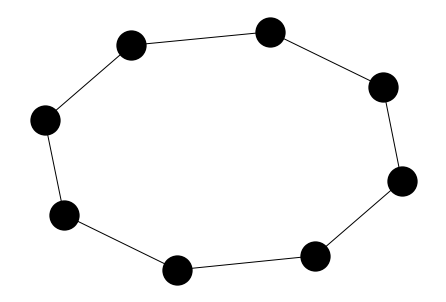

In [ ]:
# Generate a random regular graph of degree 2 with 8 nodes and a fixed seed for reproducibility
G = nx.generators.random_graphs.random_regular_graph(2, 8, seed=0)

# Define visualization options for the graph nodes and edges
options = {"node_size": 800, "edgecolors": "k", "linewidths": 2.0}

# Draw the graph with black nodes and the defined options
nx.draw(G, node_color='k', **options)

plt.show()

In [ ]:
def cut_size(x, G):
    # Computes the cut size of a given solution x on graph G
    cut = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            cut -= 1  # If the nodes i and j are in different groups, add -1 to the cut size
    return cut


def av_cut_size(xs, G):
    # Computes the average cut size of a set of solutions xs on graph G
    av_cut = 0

    for x in xs:
        av_cut += cut_size(x, G)  # Compute the cut size of each solution and add them up

    return av_cut / xs.shape[0]  # Divide the total cut size by the number of solutions


def plot_graph_cut(G, cut):
    # Plots the graph G with nodes colored based on the cut
    color_map = []
    for idx in range(cut.shape[0]):
        if cut[idx] == 0:
            color_map.append('w')  # If node idx is in the 0 group, set its color to white
        else:
            color_map.append('k')  # Otherwise, set its color to black

    options = {"node_size": 800, "edgecolors": "k", "linewidths": 2.0}
    nx.draw(G, nodelist=range(cut.shape[0]), node_color=color_map,
            **options)  # Draw the graph with specified options and color map
    plt.show()


The size of this cut is 4.


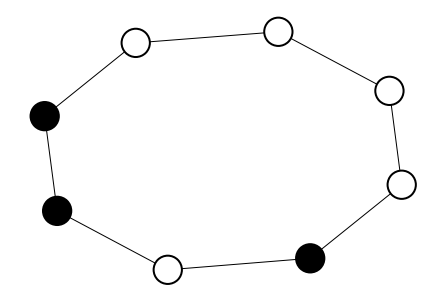

In [ ]:
# Randomly generate a cut for graph G
random_cut = np.random.choice(2, size = G.number_of_nodes())

# Calculate the size of the cut
cut = cut_size(random_cut, G)

# Print the size of the cut (note that the cut size is negative because it is the complement of the actual cut)
print("The size of this cut is {}.".format(-cut))

# Plot the graph with the cut highlighted
plot_graph_cut(G, random_cut)

In [ ]:
def random_trials(G, num_trials=100):
    # Generate random solutions
    all_guesses = np.random.choice(2, size=(num_trials, G.number_of_nodes()))

    # Calculate the cost of each solution
    all_cuts = np.array([cut_size(x, G) for x in all_guesses])

    # Find the best solution
    best = np.argmin(all_cuts)
    best_solution = all_guesses[best]
    best_cost = all_cuts[best]

    # Compute statistics
    statistics = {}
    statistics['all_cuts'] = all_cuts
    statistics['av_cost'] = -all_cuts.mean() # average cost
    statistics['min_cost'] = -best_cost # minimum cost
    statistics['maxcut_obj'] = all_cuts.mean() / best_cost # ratio of mean cost to best cost
    statistics['variance'] = all_cuts.var() # variance of cost
    statistics['best_solution'] = best_solution # best solution found

    return statistics

The size of the average cut is -4.0.
The variance of the cuts is 2.16.
The cost function value is 0.6666666666666666.
The size of the minimum cut is -6.


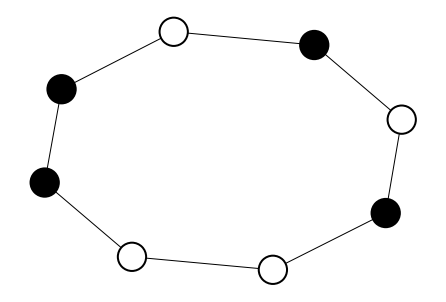

In [ ]:
# Conduct 100 random trials to find the best cut.

results = random_trials(G,100)

print("The size of the average cut is {}.".format(-results['av_cost']))

print("The variance of the cuts is {}.".format(results['variance']))

print("The cost function value is {}.".format(results['maxcut_obj']))

print("The size of the minimum cut is {}.".format(-results['min_cost']))

plot_graph_cut(G,results['best_solution'])

In [ ]:
def iterate_bit_strings(n):
    """
    This function generates all possible bit strings of length n.

    Parameters:
    n (int): length of the bit strings

    Returns:
    Generator object: generates bit strings of length n as numpy arrays
    """
    for i in range(2**n):  # loop over all integers from 0 to 2^n - 1
        bit_string = bin(i)[2:].zfill(n)  # convert i to binary and pad with zeros to get a bit string of length n
        yield np.array([int(c) for c in bit_string], dtype=int)  # convert the bit string to a numpy array of integers and yield it

# Define a function to solve the Max-Cut problem using brute force
def bruteforce(G):

    # Compute all possible bit strings of length G.number_of_nodes() and evaluate the cut size for each one
    all_cuts = np.array([cut_size(x,G) for x in iterate_bit_strings(G.number_of_nodes())])

    # Find the index of the bit string with the smallest cut size, and use it to get the best solution and its cost
    best = np.argmin(all_cuts)
    best_solution = np.array([b for b in bin(best)[2:].zfill(G.number_of_nodes())], dtype=int)
    best_cost = all_cuts[best]

    # Compute various statistics related to the solutions and return them in a dictionary
    statistics = {}
    statistics['all_cuts'] = all_cuts
    statistics['av_cost'] = -all_cuts.mean()
    statistics['min_cost'] = -best_cost
    statistics['maxcut_obj'] = all_cuts.mean() / best_cost
    statistics['variance'] = all_cuts.var()
    statistics['best_solution'] = best_solution

    return statistics

The size of the average cut is -4.0.
The variance of the cuts is 2.0.
The cost function value is 0.5.
The size of the minimum cut is -8.


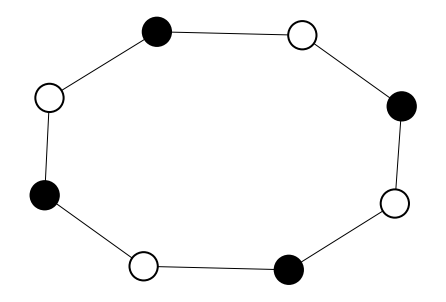

In [ ]:
results = bruteforce(G) # Computes the results of the brute-force method for the given graph G.

print("The size of the average cut is {}.".format(-results['av_cost']))

print("The variance of the cuts is {}.".format(results['variance']))

print("The cost function value is {}.".format(results['maxcut_obj']))

print("The size of the minimum cut is {}.".format(-results['min_cost']))

plot_graph_cut(G,results['best_solution'])

In [ ]:
def run_circuit(starting_bits, circuit, num_trials = 100):
    """
    Run a quantum circuit with a given set of starting bits for a specified number of trials.

    Args:
        starting_bits (numpy.ndarray): A 1-dimensional numpy array of starting bits, represented as 0 or 1.
        circuit (list): A list of tuples representing the quantum circuit to be run. Each tuple contains two elements:
                        1. A 1-dimensional numpy array of integers representing the indices of the bits to be changed in the current timestep.
                        2. A 2-dimensional numpy array representing the stochastic matrix to be applied in the current timestep.
        num_trials (int): The number of trials to run the circuit for.

    Returns:
        numpy.ndarray: A 2-dimensional numpy array where each row represents the final bit values for a single trial of the circuit.
    """

    # Determine the number of timesteps in the circuit
    num_timesteps = len(circuit)

    # Create a 2-dimensional numpy array to store the final bit values for each trial
    data = np.zeros([num_trials,starting_bits.shape[0]])

    # Run the circuit for the specified number of trials
    for j in range(num_trials):
        # Set the current bit values to the starting bit values
        bits = starting_bits

        # Iterate over each timestep in the circuit
        for i in range(num_timesteps):
            # Get the bit changes and the stochastic matrix for the current timestep
            bit_changes, matrix = circuit[i]

            # Create a vector to store the current bit values
            current_bits = np.zeros(4)

            # Set the values of the current bits according to the bit changes and little-endian bit ordering
            current_bits[bits[bit_changes == 1]@[2,1]] = 1

            # Multiply the current bits by the matrix to get a vector of probabilities
            result = matrix@current_bits

            # Sample a new index from the vector of probabilities
            sampled_index = np.random.choice(4, p=result)

            # Calculate the new bit values by performing modular arithmetic
            new_bits = (sampled_index // np.array([2,1])) % 2

            # Update the values of the bits according to the bit changes
            bits[bit_changes == 1] = new_bits

        # Store the final bit values for the current trial in the data array
        data[j] = bits

    # Return the final bit values for all trials as a 2-dimensional numpy array
    return(data)

In [ ]:
def paoa_circuit(G, p, layers=1):
    """
    Construct the circuit for the Probability Amplitude Amplification (PAmplifyOpt) algorithm.
    Args:
        G (networkx.Graph): The input graph.
        p (numpy.array): The parameters to use in the PAmplifyOpt algorithm.
        layers (int): The number of layers of the circuit. Defaults to 1.

    Returns:
        dict: A dictionary representing the quantum circuit.

    """
    # get the number of nodes in the graph
    num_pbits = G.number_of_nodes()

    # initialize an empty circuit dictionary
    circuit = {}
    ###### ERROR ####
    k=0
    # loop over the layers of the circuit
    for l in range(layers):
        # loop over the edges of the graph
        for i, j in G.edges():
            # initialize an array of zeros with the length of the number of nodes in the graph
            bit_changes = np.zeros(num_pbits, dtype=int)
            # set the values at the indices i and j to 1
            bit_changes[[i, j]] = 1

            # initialize a 4x4 matrix of zeros
            matrix = np.zeros((4, 4))

            # set the second row of the matrix to the values of p[k:k+4]
            matrix[1, :] = p[k:k+4]
            # set the third row of the matrix to the complement of the values of p[k:k+4]
            matrix[2, :] = 1 - p[k:k+4]

            # store the bit_changes and matrix in the circuit dictionary at the index k//4
            circuit[k//4] = (bit_changes, matrix)

            # increment k by 4 to move to the next set of 4 parameters
            k += 4

    # return the circuit dictionary
    return circuit


In [ ]:
def get_black_box_objective(G, layers = 1, num_trials = 100, reduced = 0):
    """
    Returns an objective function for use in optimization algorithms.
    The objective function is based on the output of a PAOA circuit with given parameters
    and the average cut size of the resulting graph.

    Parameters:
    - G: networkx.Graph object representing the graph to optimize.
    - layers: integer representing the number of layers to use in the PAOA circuit. Default is 1.
    - num_trials: integer representing the number of trials to use when running the circuit. Default is 100.
    - reduced: integer representing the type of PAOA circuit to use. If 0, use paoa_circuit. If 1, use reduced_paoa_circuit.
               If 2, use minimum_paoa_circuit. Default is 0.

    Returns:
    - f: function that takes in a list of parameters and returns the average cut size of the resulting graph.
    """

    n = G.number_of_nodes() # number of nodes in the graph

    # Choose the type of PAOA circuit to use based on the reduced parameter
    if reduced == 1:
        circuit_choice = reduced_paoa_circuit
    elif reduced == 2:
        circuit_choice = minimum_paoa_circuit
    else:
        circuit_choice = paoa_circuit

    def f(ps):
        """
        Objective function that takes in a list of parameters and returns the average cut size of the resulting graph
        using a PAOA circuit.

        Parameters:
        - ps: list of parameters used in the PAOA circuit.

        Returns:
        - av_cut_size: float representing the average cut size of the resulting graph.
        """
        # Generate a PAOA circuit using the given parameters and number of layers
        circuit = circuit_choice(G, ps, layers = layers)

        # Run the circuit using a random input and the given number of trials
        output = run_circuit(np.random.choice((0,1),size = n), circuit, num_trials = num_trials)

        # Calculate the average cut size of the resulting graph
        av_cut_sizey = av_cut_size(output, G)

        return av_cut_sizey

    return f

In [ ]:
# Function to perform an experiment on a given graph G, using the specified parameters
def experiment(G, num_trials = 100, num_iter = 100, layers = 1, reduced = 0):

    # Determine which PAOA circuit function to use based on the value of reduced
    if reduced == 1:
      circuit_choice = reduced_paoa_circuit
      p = np.random.rand(layers * G.number_of_edges())

    elif reduced == 2:
      circuit_choice = minimum_paoa_circuit
      p = np.random.rand(2 * layers)

    else:
      circuit_choice = paoa_circuit
      p = np.random.rand(4 * layers * G.number_of_edges())

    # Define the objective function f using the black box objective method, with the specified parameters
    f = get_black_box_objective(G, num_trials=num_trials, layers=layers, reduced=reduced)

    # Run the SPSA optimization algorithm to minimize the objective function
    result = minimizeSPSA(f, bounds=[(0, 1)] * p.shape[0],
                          x0=p,
                          niter=num_iter,
                          paired=False,
                          a=1e-1,
                          c=1e-1)

    return result


# Function to calculate statistics for a given graph G and optimization result
def get_statistics(G, result, num_trials= 100, layers = 1, reduced = 0):

    # Determine which PAOA circuit function to use based on the value of reduced
    if reduced == 1:
      circuit_choice = reduced_paoa_circuit

    elif reduced == 2:
      circuit_choice = minimum_paoa_circuit

    else:
      circuit_choice = paoa_circuit

    # Generate outputs by running the PAOA circuit on the graph with the optimized parameters
    outputs = run_circuit(np.random.choice((0, 1), size=G.number_of_nodes()),
                         circuit_choice(G, result['x']),
                         num_trials=num_trials)

    # Calculate the cut sizes for all outputs
    all_cuts = np.array([cut_size(x,G) for x in outputs])

    # Determine the best solution and its cost
    best = np.argmin(all_cuts)
    best_solution = outputs[best]
    best_cost = all_cuts[best]

    # Calculate statistics based on the cut sizes and best solution
    statistics = {}
    statistics['all_cuts'] = all_cuts
    statistics['av_cost'] = -all_cuts.mean()  # Average cut size (negative value)
    statistics['min_cost'] = -best_cost  # Minimum cut size (negative value)
    statistics['maxcut_obj'] = all_cuts.mean() / best_cost  # Approximate maximum cut value
    statistics['variance'] = all_cuts.var()  # Variance of cut sizes
    statistics['best_solution'] = best_solution  # Best solution found by the optimization algorithm

    return statistics


In [ ]:
# Run experiment to find optimal solution using default parameters (PAOA)
optimal = experiment(G)
results = get_statistics(G,optimal)

The size of the average cut is -6.42.
The variance of the cuts is 1.2236000000000002.
The cost function value is 0.8025.
The size of the minimum cut is -8.


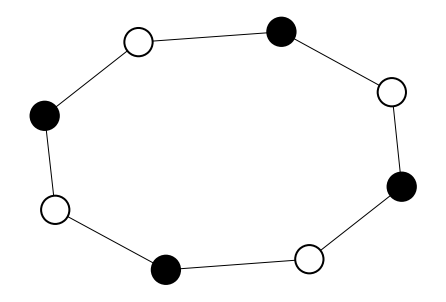

In [ ]:
# Print the size of the average cut using the results dictionary returned from get_statistics function.
# The negative sign is used to convert from maximizing the cut to minimizing it.
print("The size of the average cut is {}.".format(-results['av_cost']))

# Print the variance of the cuts using the results dictionary returned from get_statistics function.
print("The variance of the cuts is {}.".format(results['variance']))

# Print the cost function value using the results dictionary returned from get_statistics function.
print("The cost function value is {}.".format(results['maxcut_obj']))

# Print the size of the minimum cut using the results dictionary returned from get_statistics function.
# The negative sign is used to convert from maximizing the cut to minimizing it.
print("The size of the minimum cut is {}.".format(-results['min_cost']))

# Plot the best solution cut found by the algorithm using the plot_graph_cut function.
plot_graph_cut(G,results['best_solution'])

In [ ]:
def reduced_paoa_circuit(G, p, layers = 1):
    # Get the number of nodes in the graph
    num_pbits = G.number_of_nodes()

    # Initialize an empty circuit dictionary
    circuit = {}

    # Initialize the counter variable
    k = 0

    # Loop over the specified number of layers
    for l in range(layers):

        # Loop over the edges in the graph
        for i,j in G.edges():
            # Initialize the bit changes to be zero for all nodes
            bit_changes = np.zeros(num_pbits, dtype=int)
            # Set the bit changes for the two nodes involved in the edge to be 1
            bit_changes[[i,j]] = 1

            # Initialize a 4x4 matrix with all elements set to zero
            matrix = np.zeros((4,4))

            # Fill in the values of the matrix based on the given parameter value
            matrix[1,0] =  matrix[2,3] = p[k]
            matrix[2,0] =  matrix[1,3] = 1 - p[k]
            matrix[1,1] =  matrix[2,2] = p[k]
            matrix[1,2] =  matrix[2,1] = 1 - p[k]

            # Add the gate to the circuit dictionary with the corresponding bit changes and matrix
            circuit[k] = (bit_changes,matrix)
            k += 1

    # Return the circuit dictionary
    return circuit


def minimum_paoa_circuit(G, p, layers = 1):
    # Get the number of nodes in the graph
    num_pbits = G.number_of_nodes()

    # Initialize an empty circuit dictionary
    circuit = {}

    # Initialize the counter variable for the circuit dictionary
    k = 0
    # Initialize the counter variable for the parameter array
    m = 0

    # Loop over the specified number of layers
    for l in range(layers):

        # Loop over the edges in the graph
        for i,j in G.edges():
            # Initialize the bit changes to be zero for all nodes
            bit_changes = np.zeros(num_pbits, dtype=int)
            # Set the bit changes for the two nodes involved in the edge to be 1
            bit_changes[[i,j]] = 1

            # Initialize a 4x4 matrix with all elements set to zero
            matrix = np.zeros((4,4))

            # Fill in the values of the matrix based on the given parameter values
            matrix[1,0] =  matrix[2,3] = p[m]
            matrix[2,0] =  matrix[1,3] = 1 - p[m]
            matrix[1,1] =  matrix[2,2] = p[m+1]
            matrix[1,2] =  matrix[2,1] = 1 - p[m+1]

            # Add the gate to the circuit dictionary with the corresponding bit changes and matrix
            circuit[k] = (bit_changes,matrix)
            k += 1

        # Increment the counter variable for the parameter array by 2 for every layer
        m += 2

    # Return the circuit dictionary
    return circuit


In [ ]:
# Run the experiment function on graph G with reduced option set to 1 (Reduced PAOA)
optimal = experiment(G, reduced = 1)

results = get_statistics(G,optimal, reduced = 1)

The size of the average cut is -6.34.
The variance of the cuts is 0.8844000000000001.
The cost function value is 0.7925.
The size of the minimum cut is -8.


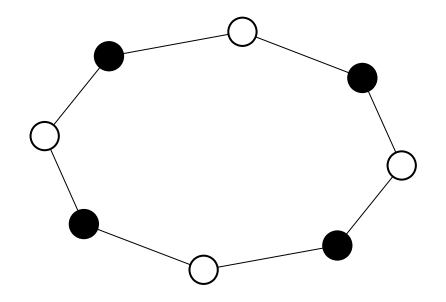

In [ ]:
# Print the corresponding metrics returned from get_statistics function

print("The size of the average cut is {}.".format(-results['av_cost']))

print("The variance of the cuts is {}.".format(results['variance']))

print("The cost function value is {}.".format(results['maxcut_obj']))

print("The size of the minimum cut is {}.".format(-results['min_cost']))

plot_graph_cut(G,results['best_solution'])

In [ ]:
# Run the experiment function on graph G with reduced option set to 2 and layer set to 1 (MinPAOA 1)
optimal = experiment(G, layers = 1, reduced = 2)
results = get_statistics(G,optimal, layers = 1, reduced = 2)

The size of the average cut is -8.0.
The variance of the cuts is 0.0.
The cost function value is 1.0.
The size of the minimum cut is -8.


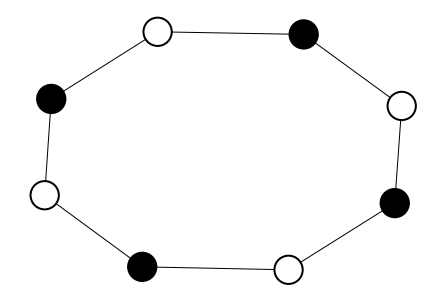

In [ ]:
# Print the corresponding metrics returned from get_statistics function

print("The size of the average cut is {}.".format(-results['av_cost']))

print("The variance of the cuts is {}.".format(results['variance']))

print("The cost function value is {}.".format(results['maxcut_obj']))

print("The size of the minimum cut is {}.".format(-results['min_cost']))

plot_graph_cut(G,results['best_solution'])

In [ ]:
# Run the experiment function on graph G with reduced option set to 2 and layer set to 3 (Min PAOA 3)
optimal = experiment(G, layers = 3, num_iter = int(1e2), reduced = 2)
results = get_statistics(G,optimal, layers = 3, reduced = 2)

The size of the average cut is -4.36.
The variance of the cuts is 1.3904000000000005.
The cost function value is 0.7266666666666667.
The size of the minimum cut is -6.


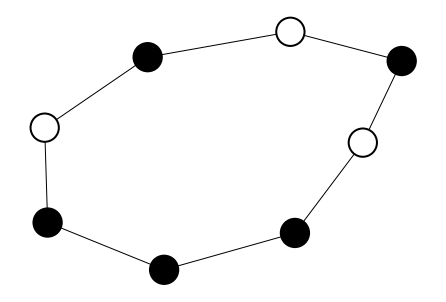

In [ ]:
# Print the corresponding metrics returned from get_statistics function

print("The size of the average cut is {}.".format(-results['av_cost']))

print("The variance of the cuts is {}.".format(results['variance']))

print("The cost function value is {}.".format(results['maxcut_obj']))

print("The size of the minimum cut is {}.".format(-results['min_cost']))

plot_graph_cut(G,results['best_solution'])

In [ ]:
def qaoa_circ(G, x):
    """
    This function creates a QAOA circuit for a given graph G and set of parameters x.
    """
    n_qubits = G.number_of_nodes()  # get the number of nodes in the graph
    p = len(x)//2  # get the number of layers (i.e., p = len(x)/2 since x is a concatenation of beta and gamma parameters)

    qc = qiskit.QuantumCircuit(n_qubits)  # create an empty quantum circuit

    beta = x[:p]  # get the first half of the parameters (i.e., beta parameters)
    gamma = x[p:]  # get the second half of the parameters (i.e., gamma parameters)

    # apply a Hadamard gate to each qubit to create a superposition state
    for idx in range(0, n_qubits):
        qc.h(idx)

    # apply problem unitary and mixer unitary for each layer
    for irep in range(0, p):
        # apply the problem unitary (i.e., a controlled-Rz gate for each edge in G)
        for edge in G.edges():
            qc.rzz(2 * gamma[irep], edge[0], edge[1])
        # apply the mixer unitary (i.e., an X-rotation gate for each qubit)
        for idx in range(0, n_qubits):
            qc.rx(2 * beta[irep], idx)

    qc.measure_all()  # measure all qubits in the circuit

    return qc


def qaoa_obj(G, num_trials=100):
    """
    This function returns an objective function for the QAOA algorithm with the graph G and the specified number of trials.
    """
    n = G.number_of_nodes()  # get the number of nodes in the graph

    def f(x):
        """
        This function evaluates the objective function for a given set of parameters x.
        """
        qc = qaoa_circ(G, x)  # create a QAOA circuit for the given graph and parameters

        backend = qiskit.Aer.get_backend('aer_simulator')  # set the backend to the Aer simulator

        # execute the circuit on the backend and get the results
        output = qiskit.execute(qc, backend, shots=num_trials, memory=True)

        # convert the results to an array of bitstrings and calculate the average cut size
        results = np.array([list(map(int, number)) for number in output.result().get_memory()])
        return av_cut_size(results, G)

    return f

def get_qaoa_stats(G, num_trials = 100, num_iter = 100, layers = 1):
    """
    This function runs the QAOA algorithm on the graph G with the specified number of trials, iterations, and layers.
    """

    # Set up the initial values for the angles used in the QAOA algorithm
    x0 = np.ones(2*layers)

    # Define the objective function used in the QAOA algorithm
    f = qaoa_obj(G, num_trials=num_trials)

    # Minimize the objective function using SPSA optimization, and save the results
    result = minimizeSPSA(f,
                          x0=x0,
                          niter=num_iter,
                          paired=False,
                          a=1e-1,
                          c=1e-1)

    # Use Qiskit to execute the QAOA circuit with the optimized angles on a simulated quantum backend
    backend = qiskit.Aer.get_backend('aer_simulator')
    temp = qiskit.execute(qaoa_circ(G,result['x']), backend, shots=num_trials, memory=True)

    # Extract the output bitstrings from the Qiskit simulation and convert them into a numpy array
    outputs = np.array([list(map(int, number)) for number in temp.result().get_memory()])

    # Calculate the "cut size" for each bitstring output by the Qiskit simulation and save as a numpy array
    all_cuts = np.array([cut_size(x,G) for x in outputs])

    # Determine the bitstring with the lowest cut size, and save its index, bitstring, and cut size
    best = np.argmin(all_cuts)
    best_solution = outputs[best]
    best_cost = all_cuts[best]

    # Calculate various statistics about the output bitstrings and return them in a dictionary
    statistics = {}
    statistics['all_cuts'] = all_cuts
    statistics['av_cost'] = -all_cuts.mean() # average negative cut size
    statistics['min_cost'] = -best_cost # negative cut size of the best bitstring
    statistics['maxcut_obj'] = all_cuts.mean() / best_cost # ratio of average cut size to best cut size
    statistics['variance'] = all_cuts.var() # variance of the cut sizes
    statistics['best_solution'] = best_solution # the bitstring with the best cut size

    return statistics

In [ ]:
# Define a function to compare different methods for solving a graph optimization problem
def compare_methods(G, num_trials = 100):
  # Define the headers for the table
  headers = ["Method","Average","Variance","Best","Approx. Ratio", "Cut Dist"]

  # Initialize the data list with the results of a random algorithm
  randomtrials = random_trials(G, num_trials)
  data = [["Random",randomtrials['av_cost'],randomtrials['variance'],randomtrials['min_cost'],randomtrials['maxcut_obj'], randomtrials['all_cuts']]]

  # Add the results of a brute force algorithm to the data list
  bruteforce_sol = bruteforce(G)
  data.append(["Brute force",bruteforce_sol['av_cost'],bruteforce_sol['variance'],bruteforce_sol['min_cost'],bruteforce_sol['maxcut_obj'], bruteforce_sol['all_cuts']])

  # Plot the graph cut for the best solution found by the brute force algorithm
  plot_graph_cut(G,bruteforce_sol['best_solution'])

  # Add the results of a PAOA algorithm to the data list
  paoa = get_statistics(G,experiment(G))
  data.append(["PAOA",paoa['av_cost'],paoa['variance'],paoa['min_cost'],paoa['maxcut_obj'], paoa['all_cuts']])

  # Add the results of a reduced PAOA algorithm to the data list
  paoa_reduced = get_statistics(G,experiment(G,reduced = 1), reduced = 1)
  data.append(["Reduced PAOA",paoa_reduced['av_cost'],paoa_reduced['variance'],paoa_reduced['min_cost'],paoa_reduced['maxcut_obj'], paoa_reduced['all_cuts']])

  # Add the results of a minimum PAOA algorithm to the data list
  paoa_min = get_statistics(G,experiment(G,reduced = 2), reduced = 2)
  data.append(["Min PAOA (1 layer)",paoa_min['av_cost'],paoa_min['variance'],paoa_min['min_cost'],paoa_min['maxcut_obj'], paoa_min['all_cuts']])

  # Add the results of a minimum PAOA algorithm with 3 layers to the data list
  paoa_min3 = get_statistics(G,experiment(G,layers = 3, reduced = 2), layers = 3, reduced = 2)
  data.append(["Min PAOA (3 layers)",paoa_min3['av_cost'],paoa_min3['variance'],paoa_min3['min_cost'],paoa_min3['maxcut_obj'], paoa_min3['all_cuts']])

  # Add the results of a QAOA algorithm with 1 layer to the data list
  qaoa1 = get_qaoa_stats(G, layers = 1)
  data.append(["QAOA (1 layer)",qaoa1['av_cost'],qaoa1['variance'],qaoa1['min_cost'],qaoa1['maxcut_obj'], qaoa1['all_cuts']])

  # Add the results of a QAOA algorithm with 3 layers to the data list
  qaoa3 = get_qaoa_stats(G, layers = 3)
  data.append(["QAOA (3 layers)",qaoa3['av_cost'],qaoa3['variance'],qaoa3['min_cost'],qaoa3['maxcut_obj'], qaoa3['all_cuts']])

  # Add the results of a QAOA algorithm with 6 layers to the data list
  qaoa6 = get_qaoa_stats(G, layers = 6)
  data.append(["QAOA (6 layers)",qaoa6['av_cost'],qaoa6['variance'],qaoa6['min_cost'],qaoa6['maxcut_obj'], qaoa6['all_cuts']])

  # Use the tabulate library to create an HTML table from a two-dimensional list of data and a list of headers
  table = tabulate.tabulate(data, headers=headers, tablefmt='html', floatfmt=".2f")
  display(HTML(table))
  return data

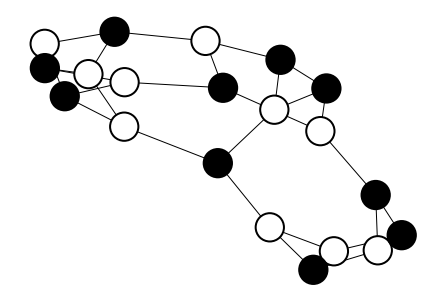

Method,Average,Variance,Best,Approx. Ratio,Cut Dist
Random,15.24,10.42,21.00,0.73,[-16 -8 -18 -19 -19 -16 -16 -14 -21 -18 -19 -17 -10 -18 -14 -21 -14 -15 -13 -14 -17 -15 -14 -13 -18 -20 -16 -13 -14 -16 -17 -17 -19 -11 -19 -9 -17 -11 -11 -16 -12 -16 -19 -21 -17 -16 -15 -16 -7 -11 -14 -8 -18 -10 -16 -10 -17 -13 -13 -17 -14 -10 -18 -16 -16 -16 -16 -13 -17 -17 -13 -20 -15 -17 -9 -18 -14 -17 -14 -11 -15 -14 -16 -15 -16 -15 -17 -16 -18 -16 -14 -19 -15 -18 -4 -17 -16 -21 -16 -16]
Brute force,15.00,7.50,26.00,0.58,[ 0 -3 -3 ... -3 -3 0]
PAOA,18.98,5.22,23.00,0.83,[-20 -21 -18 -16 -17 -19 -21 -16 -21 -18 -19 -20 -23 -18 -18 -23 -19 -19 -17 -20 -15 -18 -14 -20 -19 -20 -15 -18 -19 -16 -20 -20 -22 -15 -20 -17 -19 -15 -15 -22 -18 -18 -22 -21 -17 -21 -17 -17 -20 -21 -20 -23 -17 -23 -19 -19 -19 -15 -22 -20 -17 -18 -14 -16 -20 -20 -23 -20 -16 -20 -20 -22 -20 -18 -21 -21 -18 -19 -19 -18 -19 -20 -19 -21 -13 -20 -17 -19 -19 -22 -19 -20 -21 -19 -21 -17 -15 -23 -21 -22]
Reduced PAOA,18.38,6.78,24.00,0.77,[-15 -21 -19 -18 -20 -20 -18 -20 -17 -18 -19 -17 -23 -17 -17 -12 -17 -19 -22 -20 -17 -20 -18 -15 -20 -20 -18 -15 -14 -19 -21 -17 -21 -21 -19 -18 -19 -20 -19 -24 -16 -18 -15 -15 -13 -18 -13 -21 -15 -15 -18 -17 -17 -18 -18 -16 -20 -17 -19 -17 -18 -24 -19 -22 -21 -15 -23 -21 -20 -18 -19 -18 -20 -16 -19 -21 -19 -20 -15 -16 -17 -23 -19 -22 -19 -20 -14 -13 -12 -17 -18 -19 -21 -22 -19 -19 -17 -24 -19 -20]
Min PAOA (1 layer),21.55,2.65,24.00,0.90,[-18 -21 -23 -20 -20 -20 -21 -17 -20 -24 -24 -23 -22 -21 -20 -21 -22 -22 -22 -21 -21 -22 -22 -22 -23 -22 -22 -23 -22 -21 -22 -22 -20 -20 -16 -21 -21 -19 -22 -18 -24 -24 -23 -22 -21 -21 -19 -23 -22 -24 -23 -24 -22 -21 -23 -17 -22 -23 -21 -22 -20 -22 -23 -23 -24 -23 -24 -23 -22 -21 -23 -22 -21 -23 -21 -22 -21 -20 -21 -20 -21 -20 -24 -22 -24 -23 -21 -22 -23 -21 -24 -22 -18 -21 -21 -21 -21 -21 -21 -21]
Min PAOA (3 layers),16.68,6.92,23.00,0.73,[-18 -16 -19 -16 -19 -15 -15 -18 -18 -15 -17 -22 -18 -22 -18 -12 -18 -18 -19 -16 -14 -18 -17 -21 -18 -18 -17 -14 -16 -18 -18 -15 -18 -18 -17 -21 -18 -13 -18 -13 -15 -16 -20 -13 -14 -14 -15 -15 -12 -14 -18 -14 -18 -12 -16 -16 -17 -19 -14 -19 -16 -17 -14 -15 -13 -19 -16 -18 -18 -15 -12 -19 -13 -19 -11 -17 -17 -23 -15 -13 -20 -21 -12 -17 -16 -18 -20 -16 -14 -22 -18 -16 -13 -18 -18 -15 -17 -14 -21 -22]
QAOA (1 layer),17.12,5.89,23.00,0.74,[-17 -14 -17 -18 -15 -19 -16 -20 -19 -19 -14 -19 -14 -17 -15 -17 -16 -17 -15 -20 -20 -18 -18 -22 -18 -17 -11 -16 -14 -19 -16 -19 -17 -17 -18 -15 -16 -17 -14 -18 -18 -19 -15 -18 -15 -14 -20 -13 -17 -17 -17 -20 -21 -14 -16 -14 -19 -21 -20 -16 -21 -18 -21 -20 -17 -15 -18 -14 -16 -19 -16 -18 -14 -17 -14 -18 -14 -14 -20 -22 -19 -15 -14 -15 -19 -11 -23 -16 -16 -14 -18 -18 -17 -22 -17 -20 -18 -17 -19 -16]
QAOA (3 layers),18.73,5.74,25.00,0.75,[-22 -18 -18 -15 -16 -21 -17 -22 -22 -16 -22 -17 -19 -18 -20 -19 -22 -16 -16 -19 -22 -14 -17 -19 -21 -18 -18 -20 -18 -21 -21 -20 -19 -18 -21 -13 -17 -25 -17 -17 -21 -22 -19 -17 -15 -18 -20 -18 -23 -19 -16 -19 -18 -21 -15 -20 -17 -22 -19 -15 -17 -13 -21 -20 -13 -19 -18 -20 -22 -17 -19 -17 -21 -23 -17 -15 -22 -16 -18 -20 -20 -17 -21 -19 -18 -19 -20 -19 -20 -21 -21 -16 -20 -22 -17 -19 -17 -17 -19 -18]
QAOA (6 layers),17.06,8.78,23.00,0.74,[-13 -18 -17 -15 -22 -18 -19 -19 -18 -19 -12 -20 -17 -16 -15 -20 -15 -18 -15 -21 -18 -14 -15 -23 -21 -19 -16 -19 -16 -16 -17 -21 -20 -13 -18 -17 -17 -22 -19 -17 -15 -14 -21 -19 -19 -15 -17 -13 -16 -12 -15 -17 -19 -16 -17 -21 -13 -19 -15 -15 -12 -20 -16 -19 -16 -19 -21 -13 -21 -11 -22 -18 -20 -17 -14 -15 -11 -18 -13 -16 -14 -20 -23 -14 -17 -15 -16 -18 -15 -17 -14 -16 -23 -10 -19 -14 -23 -20 -15 -18]


[['Random',
  15.24,
  10.422400000000003,
  21,
  0.7257142857142858,
  array([-16,  -8, -18, -19, -19, -16, -16, -14, -21, -18, -19, -17, -10,
         -18, -14, -21, -14, -15, -13, -14, -17, -15, -14, -13, -18, -20,
         -16, -13, -14, -16, -17, -17, -19, -11, -19,  -9, -17, -11, -11,
         -16, -12, -16, -19, -21, -17, -16, -15, -16,  -7, -11, -14,  -8,
         -18, -10, -16, -10, -17, -13, -13, -17, -14, -10, -18, -16, -16,
         -16, -16, -13, -17, -17, -13, -20, -15, -17,  -9, -18, -14, -17,
         -14, -11, -15, -14, -16, -15, -16, -15, -17, -16, -18, -16, -14,
         -19, -15, -18,  -4, -17, -16, -21, -16, -16])],
 ['Brute force',
  15.0,
  7.5,
  26,
  0.5769230769230769,
  array([ 0, -3, -3, ..., -3, -3,  0])],
 ['PAOA',
  18.98,
  5.219599999999999,
  23,
  0.8252173913043478,
  array([-20, -21, -18, -16, -17, -19, -21, -16, -21, -18, -19, -20, -23,
         -18, -18, -23, -19, -19, -17, -20, -15, -18, -14, -20, -19, -20,
         -15, -18, -19, -16, -20, -20

In [ ]:
# Generate a random regular graph with 20 nodes and degree 3, using a seed of 0 for reproducibility
G = nx.generators.random_graphs.random_regular_graph(3, 20, seed=0)
compare_methods(G)

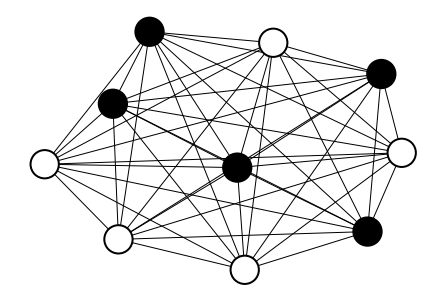

Method,Average,Variance,Best,Cost
Random,22.51,8.65,25.00,0.90
Brute force,22.50,11.25,25.00,0.90
PAOA,24.13,1.55,25.00,0.97
Reduced PAOA,23.03,5.65,25.00,0.92
Min PAOA (1 layer),25.00,0.00,25.00,1.00
Min PAOA (3 layers),24.29,1.05,25.00,0.97
QAOA (1 layer),22.24,13.98,25.00,0.89
QAOA (3 layers),21.42,24.36,25.00,0.86
QAOA (6 layers),20.22,67.01,25.00,0.81


In [ ]:
# Generate a complete graph with 10 nodes
G = nx.generators.complete_graph(10)
compare_methods(G)

In [ ]:
# Generate an Erdos-Renyi random graph with 20 nodes and edge probability 0.5
G = nx.generators.erdos_renyi_graph(20, 0.5, seed=0)
compare_methods(G)

In [ ]:
# Generate a Barabasi-Albert random graph with 20 nodes and average degree 2
G = nx.generators.barabasi_albert_graph(20, 2, seed=0)
compare_methods(G)

In [ ]:
# Generate a regular random graph with 20 nodes and degree 2
G = nx.generators.random_graphs.random_regular_graph(2, 20, seed=0)
compare_methods(G)

## 3 regular graphs

In [ ]:
# Create empty dictionaries to store data for PAOA and random algorithms
data_dict_PAOA = {}
data_dict_random = {}

# Loop through different values of the number of nodes in the graph
for id_g in tqdm(range(50,251,50)):

  # Initialize nested dictionaries for each simulation
  data_dict_PAOA[id_g] = {}
  data_dict_random[id_g] = {}

  # Run 10 simulations for each value of id_g
  for id_sim in range(10):

    # Generate a random regular graph with 2 neighbors for each node and id_g nodes
    G =  nx.generators.random_graphs.random_regular_graph(3, id_g)

    # Run the experiment using the PAOA algorithm with the reduced flag set to True
    data = get_statistics(G,experiment(G,reduced = 1), reduced = 1)

    # Store the results in the data_dict_PAOA dictionary
    for key, value in data.items():
        data_dict_PAOA[id_g].setdefault(key, []).append(value)

    # Run 100 random trials on the same graph and store the results in the data_dict_random dictionary
    data = random_trials(G, 100)
    for key, value in data.items():
        data_dict_random[id_g].setdefault(key, []).append(value)

100%|█████████████████████████████████████████| 5/5 [2:09:32<00:00, 1554.60s/it]


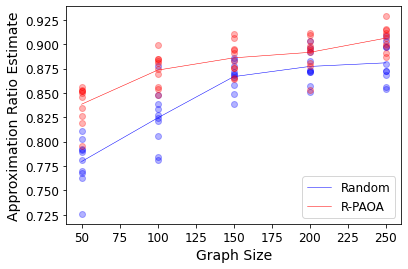

In [ ]:
# Get the list of graph sizes
graph_sizes = list(data_dict_random.keys())

# Extract the maxcut_obj values for the random algorithm, and convert them into a numpy array
maxcut_obj_values_r = np.array([entry['maxcut_obj'] for entry in data_dict_random.values()])

# Plot the maxcut_obj values for the random algorithm as individual points, with blue color and alpha transparency of 0.3
plt.plot(graph_sizes, maxcut_obj_values_r, marker='o', mfc = 'b', mec = 'b', linestyle='None', alpha = 0.3)

# Plot the mean of the maxcut_obj values for the random algorithm as a solid blue line
plt.plot(graph_sizes, maxcut_obj_values_r.mean(axis=1), 'b', linewidth = 0.5, label ="Random")

# Extract the maxcut_obj values for the PAOA algorithm, and convert them into a numpy array
maxcut_obj_values_p = np.array([entry['maxcut_obj'] for entry in data_dict_PAOA.values()])

# Plot the maxcut_obj values for the PAOA algorithm as individual points, with red color and alpha transparency of 0.3
plt.plot(graph_sizes, maxcut_obj_values_p, marker='o', mfc = 'r', mec = 'r', linestyle='None', alpha = 0.3)

# Plot the mean of the maxcut_obj values for the PAOA algorithm as a solid red line
plt.plot(graph_sizes, maxcut_obj_values_p.mean(axis=1), 'r', linewidth = 0.5, label ="R-PAOA")

plt.xlabel('Graph Size')
plt.ylabel('Approximation Ratio Estimate')
plt.legend();

plt.savefig('three_reg_approx_ratio_vs_graph_size_rand_n_PAOA.png', dpi=300,bbox_inches='tight')
plt.savefig('three_reg_approx_ratio_vs_graph_size_rand_n_PAOA.pdf', bbox_inches='tight')

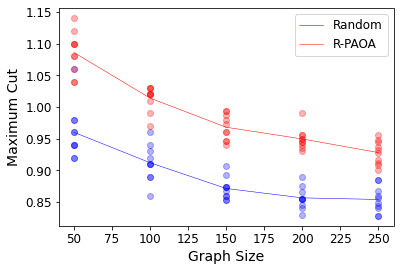

In [ ]:
# Convert keys of data_dict_random to an array
graph_sizes = np.array(list(data_dict_random.keys()))

# Extract minimum costs of all random graphs from data_dict_random
min_values_r = np.array([entry['min_cost'] for entry in data_dict_random.values()])

# Plot a scatter plot of minimum costs for each graph size
plt.plot(graph_sizes, min_values_r/graph_sizes[...,np.newaxis], marker='o', mfc = 'b', mec = 'b', linestyle='None', alpha = 0.3)

# Plot a line graph of the average minimum cost for each graph size
plt.plot(graph_sizes, min_values_r.mean(axis=1)/graph_sizes, 'b', linewidth = 0.5, label ="Random")

# Extract minimum costs of all PAOA-generated graphs from data_dict_PAOA
min_values_p = np.array([entry['min_cost'] for entry in data_dict_PAOA.values()])

# Plot a scatter plot of minimum costs for each graph size
plt.plot(graph_sizes, min_values_p/graph_sizes[...,np.newaxis], marker='o', mfc = 'r', mec = 'r', linestyle='None', alpha = 0.3)

# Plot a line graph of the average minimum cost for each graph size
plt.plot(graph_sizes, min_values_p.mean(axis=1)/graph_sizes, 'r', linewidth = 0.5, label ="R-PAOA")

plt.xlabel('Graph Size')
plt.ylabel('Maximum Cut')
plt.legend();
plt.savefig('three_reg_max_cut_vs_graph_size_rand_n_PAOA.png', dpi=300,bbox_inches='tight')
plt.savefig('three_reg_max_cut_vs_graph_size_rand_n_PAOA.pdf', bbox_inches='tight')

## 2 regular graph

In [ ]:
# Create empty dictionaries to store data for PAOA and random algorithms
data_dict_PAOA = {}
data_dict_random = {}

# Loop through different values of the number of nodes in the graph
for id_g in range(50,251,50):

  # Initialize nested dictionaries for each simulation
  data_dict_PAOA[id_g] = {}
  data_dict_random[id_g] = {}

  # Run 10 simulations for each value of id_g
  for id_sim in range(10):

    # Generate a random regular graph with 2 neighbors for each node and id_g nodes
    G = nx.generators.random_graphs.random_regular_graph(2, id_g, seed=0)

    # Run the experiment using the PAOA algorithm with the reduced flag set to True
    data = get_statistics(G,experiment(G,reduced = 1), reduced = 1)

    # Store the results in the data_dict_PAOA dictionary
    for key, value in data.items():
        data_dict_PAOA[id_g].setdefault(key, []).append(value)

    # Run 100 random trials on the same graph and store the results in the data_dict_random dictionary
    data = random_trials(G, 100)
    for key, value in data.items():
        data_dict_random[id_g].setdefault(key, []).append(value)

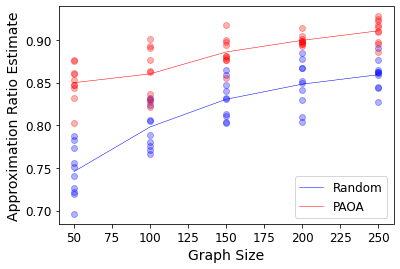

In [ ]:
# Get the list of graph sizes
graph_sizes = list(data_dict_random.keys())

# Extract the maxcut_obj values for the random algorithm, and convert them into a numpy array
maxcut_obj_values_r = np.array([entry['maxcut_obj'] for entry in data_dict_random.values()])

# Plot the maxcut_obj values for the random algorithm as individual points, with blue color and alpha transparency of 0.3
plt.plot(graph_sizes, maxcut_obj_values_r, marker='o', mfc = 'b', mec = 'b', linestyle='None', alpha = 0.3)

# Plot the mean of the maxcut_obj values for the random algorithm as a solid blue line
plt.plot(graph_sizes, maxcut_obj_values_r.mean(axis=1), 'b', linewidth = 0.5, label ="Random")

# Extract the maxcut_obj values for the PAOA algorithm, and convert them into a numpy array
maxcut_obj_values_p = np.array([entry['maxcut_obj'] for entry in data_dict_PAOA.values()])

# Plot the maxcut_obj values for the PAOA algorithm as individual points, with red color and alpha transparency of 0.3
plt.plot(graph_sizes, maxcut_obj_values_p, marker='o', mfc = 'r', mec = 'r', linestyle='None', alpha = 0.3)

# Plot the mean of the maxcut_obj values for the PAOA algorithm as a solid red line
plt.plot(graph_sizes, maxcut_obj_values_p.mean(axis=1), 'r', linewidth = 0.5, label ="R-PAOA")

plt.xlabel('Graph Size')
plt.ylabel('Approximation Ratio Estimate')
plt.legend();

plt.savefig('two_reg_approx_ratio_vs_graph_size_rand_n_PAOA.png', dpi=300,bbox_inches='tight')
plt.savefig('two_reg_approx_ratio_vs_graph_size_rand_n_PAOA.pdf', bbox_inches='tight')

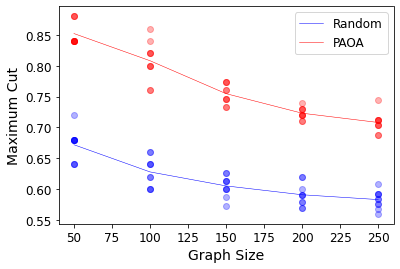

In [ ]:
# Convert keys of data_dict_random to an array
graph_sizes = np.array(list(data_dict_random.keys()))

# Extract minimum costs of all random graphs from data_dict_random
min_values_r = np.array([entry['min_cost'] for entry in data_dict_random.values()])

# Plot a scatter plot of minimum costs for each graph size
plt.plot(graph_sizes, min_values_r/graph_sizes[...,np.newaxis], marker='o', mfc = 'b', mec = 'b', linestyle='None', alpha = 0.3)

# Plot a line graph of the average minimum cost for each graph size
plt.plot(graph_sizes, min_values_r.mean(axis=1)/graph_sizes, 'b', linewidth = 0.5, label ="Random")

# Extract minimum costs of all PAOA-generated graphs from data_dict_PAOA
min_values_p = np.array([entry['min_cost'] for entry in data_dict_PAOA.values()])

# Plot a scatter plot of minimum costs for each graph size
plt.plot(graph_sizes, min_values_p/graph_sizes[...,np.newaxis], marker='o', mfc = 'r', mec = 'r', linestyle='None', alpha = 0.3)

# Plot a line graph of the average minimum cost for each graph size
plt.plot(graph_sizes, min_values_p.mean(axis=1)/graph_sizes, 'r', linewidth = 0.5, label ="R-PAOA")

plt.xlabel('Graph Size')
plt.ylabel('Maximum Cut')
plt.legend();
plt.savefig('two_reg_max_cut_vs_graph_size_rand_n_PAOA.png', dpi=300,bbox_inches='tight')
plt.savefig('two_reg_max_cut_vs_graph_size_rand_n_PAOA.pdf', bbox_inches='tight')

##  Barabási–Albert Graph

In [ ]:
# Create empty dictionaries to store data for PAOA and random algorithms
data_dict_PAOA = {}
data_dict_random = {}

# Loop through graph sizes from 50 to 250 in steps of 50
for id_g in range(50,251,50):
  # Initialize dictionaries for each graph size
  data_dict_PAOA[id_g] = {}
  data_dict_random[id_g] = {}

  # Loop through simulation ids from 0 to 9
  for id_sim in range(10):

    # Generate a Barabasi-Albert random graph with 20 nodes and degree 1
    G = nx.generators.random_graphs.barabasi_albert_graph(20,1,seed = 0)

    # Run the PAOA algorithm and store statistics in data_dict_PAOA
    data = get_statistics(G,experiment(G,reduced = 1), reduced = 1)
    for key, value in data.items():
        data_dict_PAOA[id_g].setdefault(key, []).append(value)

    # Run 100 random trials and store statistics in data_dict_random
    data = random_trials(G, 100)
    for key, value in data.items():
        data_dict_random[id_g].setdefault(key, []).append(value)

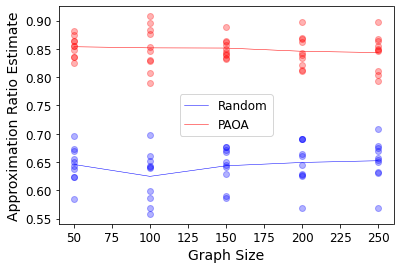

In [ ]:
# Get the list of graph sizes from the keys of the random data dictionary
graph_sizes = list(data_dict_random.keys())

# Extract the maxcut objective values from the random data dictionary values and convert them to a numpy array
maxcut_obj_values_r = np.array([entry['maxcut_obj'] for entry in data_dict_random.values()])

# Plot the maxcut objective values for the random graphs
# - marker='o': plot circles at each data point
# - mfc='b': fill the markers with blue color
# - mec='b': draw the marker edges with blue color
# - linestyle='None': do not draw a line connecting the data points
# - alpha=0.3: set the transparency level to 0.3
plt.plot(graph_sizes, maxcut_obj_values_r, marker='o', mfc='b', mec='b', linestyle='None', alpha=0.3)

# Plot the mean maxcut objective values for the random graphs
# - linewidth=0.5: set the line width to 0.5
# - label="Random": set the label for the legend to "Random"
plt.plot(graph_sizes, maxcut_obj_values_r.mean(axis=1), 'b', linewidth=0.5, label="Random")

# Extract the maxcut objective values from the PAOA data dictionary values and convert them to a numpy array
maxcut_obj_values_p = np.array([entry['maxcut_obj'] for entry in data_dict_PAOA.values()])

# Plot the maxcut objective values for the PAOA graphs
# - marker='o': plot circles at each data point
# - mfc='r': fill the markers with red color
# - mec='r': draw the marker edges with red color
# - linestyle='None': do not draw a line connecting the data points
# - alpha=0.3: set the transparency level to 0.3
plt.plot(graph_sizes, maxcut_obj_values_p, marker='o', mfc='r', mec='r', linestyle='None', alpha=0.3)

# Plot the mean maxcut objective values for the PAOA graphs
# - linewidth=0.5: set the line width to 0.5
# - label="PAOA": set the label for the legend to "PAOA"
plt.plot(graph_sizes, maxcut_obj_values_p.mean(axis=1), 'r', linewidth=0.5, label="R-PAOA")

# Set the x-axis label to "Graph Size"
plt.xlabel('Graph Size')

# Set the y-axis label to "Approximation Ratio Estimate"
plt.ylabel('Approximation Ratio Estimate')

# Display the legend
plt.legend();
plt.savefig('approx_albert_bar_vs_graph_size_rand_n_PAOA.png', dpi=300,bbox_inches='tight')
plt.savefig('approx_albert_bar_vs_graph_size_rand_n_PAOA.pdf', bbox_inches='tight')

## Numerics for small graphs

In [ ]:
# Generate a random regular graph with 20 nodes and degree 3, using a seed of 0 for reproducibility
G = nx.generators.random_graphs.random_regular_graph(3, 20, seed=0)
compare_methods(G)

### Find unique graphs

In [ ]:
# Define the number of graphs and sizes wanted
num_of_graphs = 1300

graph_sizes = [4,6,8,10]

all_unique_graphs = [] # Initialize a list to store lists of unique graphs for each size

for graph_size in graph_sizes:
    # Generate num_of_graphs random graphs of the specified size
    RandGraphs = [nx.generators.random_graphs.random_regular_graph(3, graph_size) for idx in range(num_of_graphs)]
    unique_graphs = [RandGraphs[0]]

    for G2 in RandGraphs:
        unique = False
        # Compare the current graph with the unique graphs generated so far
        for G1 in unique_graphs:
            if not nx.is_isomorphic(G1,G2):
                unique = True
            else:
                unique = False
                break
        # If the unique flag is still True, the current graph is unique, add it to the list
        if unique == True:
            unique_graphs.append(G2)
    all_unique_graphs.append(unique_graphs)

In [ ]:
# Results:
# |E| =  4    6    8    10
# num =  1    2    6    21

[len(x) for x in all_unique_graphs]

[1, 2, 6, 21]

  0%|                                                     | 0/4 [00:00<?, ?it/s]

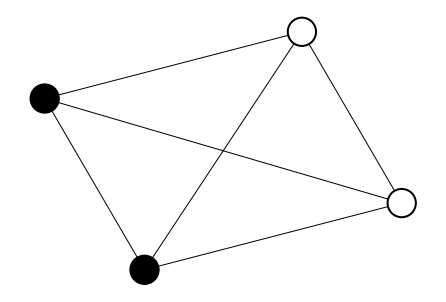

Method,Average,Variance,Best,Approx. Ratio,Cut Dist
Random,2.91,1.70,4.00,0.73,[-4 -3 -4 -4 -3 -3 -3 -4 -3 -3 -3 -4 -3 0 -3 0 -3 -4 -3 -4 -4 -4 0 0 -3 -4 -4 -3 -3 -4 -3 -4 -3 -4 -4 -3 -3 -4 0 -3 -3 -3 -3 -3 -4 0 -3 -3 0 -4 -3 -3 -4 -4 -4 -3 -4 -3 -4 0 -3 -4 -3 0 0 -3 -4 -3 -4 -4 -3 -3 -3 -3 -4 0 -4 0 -3 -3 0 -4 -3 -3 -3 -3 0 -4 -3 -4 -4 -4 -4 -4 -3 -3 -3 -3 -3 0]
Brute force,3.00,1.50,4.00,0.75,[ 0 -3 -3 -4 -3 -4 -4 -3 -3 -4 -4 -3 -4 -3 -3 0]
PAOA,3.74,0.19,4.00,0.94,[-4 -4 -4 -3 -4 -4 -4 -4 -3 -4 -4 -3 -4 -4 -4 -4 -4 -3 -3 -4 -4 -4 -4 -3 -4 -4 -4 -4 -4 -4 -4 -4 -4 -3 -4 -4 -4 -4 -4 -3 -4 -3 -3 -3 -4 -4 -4 -4 -4 -4 -4 -3 -4 -4 -4 -4 -4 -3 -4 -4 -4 -3 -3 -4 -4 -4 -4 -4 -4 -3 -4 -3 -4 -4 -3 -3 -4 -4 -3 -4 -3 -4 -3 -4 -3 -4 -4 -4 -3 -4 -4 -4 -3 -4 -4 -3 -4 -4 -4 -4]
Reduced PAOA,4.00,0.00,4.00,1.00,[-4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4]
Min PAOA (1 layer),4.00,0.00,4.00,1.00,[-4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4]
Min PAOA (3 layers),3.80,0.16,4.00,0.95,[-3 -4 -4 -4 -3 -4 -4 -3 -4 -4 -4 -4 -4 -4 -3 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -3 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -3 -4 -4 -4 -4 -3 -3 -3 -4 -4 -4 -4 -4 -3 -3 -4 -4 -4 -4 -4 -4 -4 -4 -3 -4 -4 -4 -4 -4 -4 -3 -4 -4 -4 -4 -4 -3 -4 -4 -4 -4 -4 -4 -4 -4 -3 -4 -4 -4 -4 -3 -4 -3 -4 -4 -3 -3 -3 -4 -4]
QAOA (1 layer),3.66,0.22,4.00,0.92,[-4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -3 -4 -4 -4 -4 -3 -3 -3 -3 -3 -3 -4 -4 -4 -4 -4 -3 -4 -4 -4 -3 -4 -3 -3 -4 -3 -4 -4 -3 -4 -4 -4 -4 -4 -4 -3 -4 -3 -4 -3 -4 -4 -4 -4 -3 -4 -3 -3 -3 -3 -4 -4 -4 -4 -3 -3 -3 -3 -4 -3 -4 -4 -3 -4 -4 -4 -4 -4 -3 -4 -3 -3 -4 -4 -4 -3 -4 -3 -3 -4 -4 -4 -3 -4 -4 -4 -4 -4 -4 -4]
QAOA (3 layers),3.98,0.02,4.00,0.99,[-4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -3 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -3 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4]
QAOA (6 layers),3.98,0.02,4.00,0.99,[-4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -3 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -3 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4]


 25%|███████████▎                                 | 1/4 [00:36<01:49, 36.63s/it]

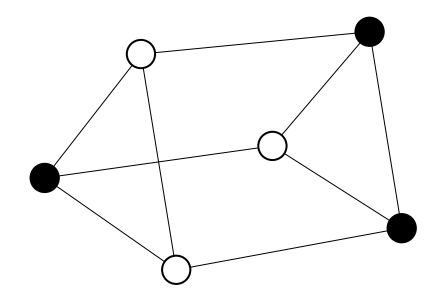

Method,Average,Variance,Best,Approx. Ratio,Cut Dist
Random,4.43,2.15,7.00,0.63,[-4 -6 -3 -5 -3 -5 -4 -6 -6 -6 -3 -5 -4 -7 0 -3 -3 0 -6 -3 -3 -3 -4 -6 -3 -3 -6 -5 -3 -4 -6 -5 -3 -3 -3 -3 -5 -4 -6 -5 -6 -5 -4 -7 -4 -3 -5 -4 -5 -3 -6 -4 -5 -3 -4 -6 -7 -3 -4 -6 -5 -3 -4 -5 -6 -5 -6 -5 -4 -6 -5 -6 -5 -3 -4 -6 -7 -4 -4 -6 -3 -5 -3 0 -3 -6 -7 -5 -3 -5 -4 -4 -6 -4 -4 -7 -5 -3 -4 -4]
Brute force,4.50,2.25,7.00,0.64,[ 0 -3 -3 -4 -3 -6 -4 -5 -3 -4 -6 -5 -4 -5 -5 -4 -3 -6 -6 -7 -4 -7 -5 -6 -4 -5 -7 -6 -3 -4 -4 -3 -3 -4 -4 -3 -6 -7 -5 -4 -6 -5 -7 -4 -7 -6 -6 -3 -4 -5 -5 -4 -5 -6 -4 -3 -5 -4 -6 -3 -4 -3 -3 0]
PAOA,5.91,1.36,7.00,0.84,[-6 -6 -6 -6 -6 -7 -6 -5 -7 -6 -3 -7 -6 -6 -5 -7 -6 -7 -6 -6 -7 -6 -6 -6 -6 -5 -3 -7 -6 -7 -6 -3 -6 -7 -6 -5 -7 -6 -6 -7 -6 -7 -6 -6 -7 -3 -5 -6 -6 -5 -7 -6 -3 -3 -3 -7 -5 -7 -6 -6 -7 -6 -5 -6 -7 -6 -7 -6 -3 -7 -3 -7 -6 -3 -4 -6 -7 -7 -7 -6 -5 -6 -6 -6 -7 -7 -5 -6 -7 -7 -6 -6 -7 -6 -7 -7 -7 -6 -6 -7]
Reduced PAOA,6.39,0.44,7.00,0.91,[-6 -7 -6 -7 -6 -6 -7 -7 -7 -7 -7 -6 -7 -7 -6 -7 -6 -6 -5 -6 -6 -6 -7 -7 -7 -7 -7 -6 -6 -6 -6 -7 -6 -6 -6 -7 -6 -7 -6 -6 -6 -6 -6 -7 -6 -3 -6 -6 -7 -7 -7 -7 -6 -6 -6 -6 -6 -6 -7 -6 -7 -6 -7 -6 -7 -7 -6 -6 -4 -7 -6 -6 -7 -7 -6 -7 -7 -7 -7 -6 -6 -7 -6 -6 -7 -7 -6 -7 -7 -7 -7 -6 -6 -6 -7 -7 -6 -6 -6 -7]
Min PAOA (1 layer),5.00,0.00,5.00,1.00,[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Min PAOA (3 layers),5.40,2.04,7.00,0.77,[-3 -7 -6 -5 -5 -7 -3 -5 -4 -5 -5 -7 -3 -7 -6 -3 -3 -7 -7 -6 -6 -3 -7 -6 -6 -7 -6 -7 -6 -3 -7 -4 -5 -4 -6 -7 -7 -4 -7 -6 -5 -5 -7 -7 -6 -7 -5 -7 -5 -7 -6 -4 -7 -4 -6 -4 -7 -6 -6 -4 -5 -4 -7 -5 -5 -7 -6 -6 -5 -5 -7 -3 -3 -7 -7 -6 -5 -7 -3 -3 -5 -6 -3 -3 -3 -5 -7 -4 -7 -6 -6 -6 -4 -7 -6 -3 -7 -3 -6 -4]
QAOA (1 layer),5.19,1.49,7.00,0.74,[-4 0 -4 -5 -4 -6 -6 -5 -7 -6 -5 -4 -4 -6 -5 -5 -5 -3 -5 -4 -4 -6 -6 -7 -5 -4 -4 -7 -6 -5 -4 -6 -7 -4 -5 -5 -7 -4 -7 -5 -5 -5 -6 -5 -7 -4 -6 -4 -4 -5 -7 -4 -3 -5 -5 -5 -4 -4 -5 -7 -7 -6 -5 -5 -6 -5 -4 -4 -5 -7 -7 -7 -5 -7 -6 -6 -5 -6 -4 -5 -7 -4 -5 -4 -7 -6 -6 -6 -7 -4 -6 -4 -5 -5 -4 -4 -6 -4 -7 -5]
QAOA (3 layers),5.20,1.42,7.00,0.74,[-4 -5 -5 -5 -7 -7 -7 -5 -4 -6 -6 -7 -6 -4 -4 -4 -5 -5 -4 -4 -5 -5 -7 -4 -7 -6 -7 -5 -5 -7 -6 -5 -5 0 -4 -5 -4 -5 -5 -6 -4 -5 -5 -7 -6 -5 -7 -5 -4 -4 -4 -4 -4 -5 -4 -7 -6 -4 -5 -4 -4 -3 -5 -7 -5 -5 -6 -7 -4 -6 -5 -6 -4 -7 -6 -7 -4 -7 -5 -6 -5 -5 -6 -4 -4 -5 -6 -5 -7 -6 -5 -6 -6 -4 -5 -5 -7 -5 -5 -4]
QAOA (6 layers),5.01,1.53,7.00,0.72,[-5 -3 -5 -7 -5 -5 -7 -5 -6 -5 -4 -5 -4 -5 -5 -5 -4 -4 -5 -4 -4 -5 -6 -4 -5 -3 -5 -4 -4 -4 -7 -7 -3 -4 -5 -4 -5 -5 -5 -5 -5 -5 -4 -5 -5 -7 -5 -7 -5 -5 -4 -5 -7 -7 -7 -4 -5 -3 -6 -5 -5 -5 -7 -6 -5 -5 -5 -7 -4 -5 0 -4 -5 -4 -5 -7 -4 -6 -6 -3 -4 -7 -5 -5 -5 -7 -3 -5 -5 -7 -4 -4 -3 -6 -5 -4 -6 -6 -7 -7]


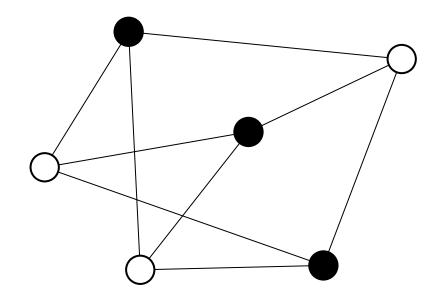

Method,Average,Variance,Best,Approx. Ratio,Cut Dist
Random,4.43,1.57,9.00,0.49,[-4 -6 -4 -3 -4 -4 -6 -5 -3 -4 -4 -5 -5 -3 -4 -5 -4 0 -3 -3 -3 -5 -3 -4 -6 -6 -3 -9 -6 -4 -4 -3 -3 -5 -4 -5 -4 -6 -5 -5 -4 -6 -3 -5 -5 -4 -6 -6 -3 -4 -6 -3 -5 -4 -4 -5 -6 -3 -5 -4 -5 -5 -3 -5 -6 -6 -5 -6 -4 -9 -5 -4 -5 -5 -5 -4 -4 -5 -3 -5 -4 -3 -5 -3 -5 -4 -3 -3 -3 -4 -5 -3 -4 -5 -5 -4 -4 -5 -4 -5]
Brute force,4.50,2.25,9.00,0.50,[ 0 -3 -3 -6 -3 -6 -6 -9 -3 -4 -4 -5 -4 -5 -5 -6 -3 -4 -4 -5 -4 -5 -5 -6 -6 -5 -5 -4 -5 -4 -4 -3 -3 -4 -4 -5 -4 -5 -5 -6 -6 -5 -5 -4 -5 -4 -4 -3 -6 -5 -5 -4 -5 -4 -4 -3 -9 -6 -6 -3 -6 -3 -3 0]
PAOA,6.26,3.33,9.00,0.70,[-6 -6 -5 -5 -6 -4 -9 -6 -5 -5 -6 -6 -6 -6 -9 -4 -9 -9 -5 -5 -4 -9 -9 -5 -5 -9 -9 -9 -9 -9 -9 -5 -6 -6 -5 -9 -5 -4 -9 -4 -6 -5 -9 -5 -5 -9 -5 -6 -3 -9 -9 -5 -6 -6 -9 -5 -6 -3 -5 -6 -4 -6 -9 -3 -6 -6 -6 -6 -6 -4 -9 -6 -9 -6 -4 -6 -4 -6 -6 -5 -6 -6 -9 -6 -4 -9 -6 -5 -5 -9 -6 -4 -9 -5 -6 -6 -6 -4 -9 -6]
Reduced PAOA,5.49,4.19,9.00,0.61,[-9 -3 -3 -9 -6 -9 -3 -3 -6 -3 -6 -3 -9 -6 -6 -9 -3 -6 -4 -6 -6 -6 -6 -9 -9 -9 -3 -3 -3 -3 -9 -6 -5 -6 -6 -9 -5 -6 -9 -6 -6 -3 -3 -6 -6 -6 -6 -6 -4 -6 -6 -3 -9 -3 -6 -6 -4 -3 -6 -3 -9 -3 -6 -3 -3 -9 -6 -3 -3 -9 -3 -4 -3 -6 -6 -6 -9 -6 -3 -6 -6 -4 -3 -6 -6 -6 -6 -3 -6 -3 -6 -6 -6 -3 -6 -6 -6 -9 -3 -6]
Min PAOA (1 layer),9.00,0.00,9.00,1.00,[-9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9]
Min PAOA (3 layers),5.69,3.63,9.00,0.63,[-6 -4 -4 -6 -9 -9 -6 -5 -6 -9 -9 -5 -9 -9 -6 -9 -6 -6 -3 -6 -6 -3 -4 -3 -6 -9 -5 -9 -9 -6 -6 -3 -4 -3 -6 -6 -4 -3 -4 -9 -4 -5 -6 -5 -6 -6 -3 -3 -9 -5 -5 -3 -9 -6 -6 -3 -5 -6 -5 -3 -6 -3 -3 -6 -9 -5 -6 -6 -3 -6 -9 -4 -6 -9 -6 -3 -4 -9 -9 -6 -3 -3 -6 -6 -6 -6 -6 -6 -6 -6 -6 -6 -5 -6 -5 -6 -6 -5 -3 -6]
QAOA (1 layer),6.45,3.97,9.00,0.72,[-9 -5 -5 -3 -5 -6 -9 -9 -5 -6 -9 -5 -5 -6 -9 -5 -9 -6 -9 -5 -6 -5 -9 -9 -5 -9 -5 -5 -5 -5 -5 -6 -9 -5 -9 -5 -9 -5 -9 -9 -9 -6 -9 -6 -5 -6 -5 -9 -5 -9 -6 -5 -9 -5 -6 -5 -5 -5 -5 -5 -5 -9 -9 -5 -9 -9 -9 -5 -3 -5 -9 -5 -9 -5 -5 -4 -5 -9 -5 -5 -5 -9 -9 -4 -5 -5 -9 -9 -9 -3 -5 -3 -5 -9 -9 -9 -5 -5 -4 -6]
QAOA (3 layers),4.57,3.61,9.00,0.51,[ 0 -5 -3 -5 -9 -5 -5 -5 -3 -3 -3 -9 -5 -5 -9 -5 -4 -3 -5 -5 -5 -5 -5 -4 -5 -5 -5 -3 -6 -3 -4 -3 -5 -9 -9 -3 -4 -3 -5 -4 -5 -4 -3 -5 -5 -4 -3 -5 -3 -5 -5 -5 -5 -3 -4 -4 -5 -9 0 -5 -3 -3 -4 -3 -4 0 -5 -3 -9 -3 -5 -4 -5 -5 -9 -3 -5 -4 -3 -5 -5 -9 -3 -9 -3 -4 -5 -4 -9 -4 -4 -3 -5 -3 -4 -3 -5 -3 -5 -4]
QAOA (6 layers),6.34,2.26,9.00,0.70,[-6 -6 -5 -5 -6 -9 -9 -9 -6 -6 -6 -6 -9 -6 -9 -6 -6 -6 -5 -9 -6 -9 -9 -6 -6 -6 -5 -9 -5 -5 -6 -6 -5 -6 -6 -6 -5 -5 -9 -9 -4 -9 -6 -6 -6 -9 -5 -5 -6 -9 -6 -6 -5 -6 -9 -6 -6 -9 -5 -6 -6 -6 -5 -6 -9 -6 -5 -3 -6 -5 -6 -6 -5 -5 -5 -6 -6 -6 -5 -6 -6 -5 -5 -5 -6 -9 -9 -6 -9 -9 -6 -6 -5 -6 -6 -6 -5 -5 -5 -9]


 50%|██████████████████████▌                      | 2/4 [02:27<02:40, 80.41s/it]

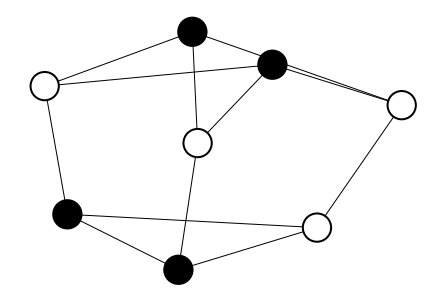

Method,Average,Variance,Best,Approx. Ratio,Cut Dist
Random,5.89,2.78,10.00,0.59,[ -5 -5 -6 -8 -6 -6 -6 -5 -5 -7 -7 -8 -7 -7 -6 -3 -3 -10 -6 -6 -7 -3 -4 -7 -8 -4 -5 -6 -7 -7 -6 -8 -6 -7 -5 -7 -5 -6 -6 -7 -3 -6 -4 -9 -6 -3 -7 -9 -5 -5 -5 -5 -8 -3 -4 -4 -8 -4 -7 -4 -9 -7 -8 -7 -3 -6 -4 -4 -5 -5 -7 -7 -5 -7 -7 -4 -6 -6 -6 -4 -6 -6 -4 -8 -7 -6 -7 -3 -5 -7 -7 -6 -7 -7 -3 -8 -9 -3 -8 -3]
Brute force,6.00,3.00,10.00,0.60,[ 0 -3 -3 -4 -3 -6 -4 -5 -3 -6 -6 -7 -6 -9 -7 -8 -3 -4 -6 -5 -4 -5 -5 -4 -6 -7 -9 -8 -7 -8 -8 -7 -3 -6 -4 -5 -6 -9 -5 -6 -4 -7 -5 -6 -7 -10 -6 -7 -6 -7 -7 -6 -7 -8 -6 -5 -7 -8 -8 -7 -8 -9 -7 -6 -3 -4 -6 -5 -4 -5 -5 -4 -4 -5 -7 -6 -5 -6 -6 -5 -6 -5 -9 -6 -5 -4 -6 -3 -7 -6 -10 -7 -6 -5 -7 -4 -6 -7 -7 -6 -7 -8 -6 -5 -5 -6 -6 -5 -6 -7 -5 -4 -9 -8 -10 -7 -8 -7 -7 -4 -8 -7 -9 -6 -7 -6 -6 -3 -3 -6 -6 -7 -6 -9 -7 -8 -4 -7 -7 -8 -7 -10 -8 -9 -4 -5 -7 -6 -5 -6 -6 -5 -5 -6 -8 -7 -6 -7 -7 -6 -4 -7 -5 -6 -7 -10 -6 -7 -3 -6 -4 -5 -6 -9 -5 -6 -5 -6 -6 -5 -6 -7 -5 -4 -4 -5 -5 -4 -5 -6 -4 -3 -6 -7 -9 -8 -7 -8 -8 -7 -5 -6 -8 -7 -6 -7 -7 -6 -7 -6 -10 -7 -6 -5 -7 -4 -6 -5 -9 -6 -5 -4 -6 -3 -7 -8 -8 -7 -8 -9 -7 -6 -4 -5 -5 -4 -5 -6 -4 -3 -8 -7 -9 -6 -7 -6 -6 -3 -5 -4 -6 -3 -4 -3 -3 0]
PAOA,8.80,1.80,10.00,0.88,[ -9 -9 -10 -7 -9 -7 -7 -4 -6 -7 -9 -6 -10 -7 -10 -10 -7 -9 -6 -9 -9 -8 -9 -9 -10 -10 -7 -8 -7 -9 -7 -7 -10 -8 -9 -6 -9 -10 -10 -10 -10 -9 -10 -10 -10 -10 -7 -10 -10 -9 -9 -8 -8 -10 -7 -10 -8 -10 -10 -10 -10 -9 -9 -10 -9 -9 -10 -9 -10 -7 -10 -10 -10 -9 -9 -7 -10 -9 -9 -10 -10 -10 -10 -10 -9 -9 -7 -9 -9 -10 -9 -10 -9 -10 -7 -9 -6 -10 -7 -10]
Reduced PAOA,8.17,2.40,10.00,0.82,[-10 -10 -10 -7 -9 -10 -7 -7 -9 -9 -9 -7 -7 -9 -9 -8 -7 -10 -8 -8 -7 -7 -6 -8 -7 -7 -10 -10 -9 -9 -6 -7 -4 -7 -10 -8 -8 -9 -8 -9 -7 -4 -9 -9 -7 -10 -9 -7 -10 -8 -10 -4 -4 -9 -8 -7 -7 -10 -10 -9 -8 -7 -7 -9 -10 -9 -10 -7 -8 -10 -10 -7 -7 -10 -7 -10 -7 -9 -7 -10 -10 -10 -7 -8 -8 -10 -10 -10 -7 -9 -9 -4 -9 -7 -9 -7 -7 -7 -9 -7]
Min PAOA (1 layer),8.71,1.15,10.00,0.87,[ -8 -9 -10 -9 -9 -10 -10 -10 -9 -7 -9 -8 -10 -8 -8 -9 -10 -6 -8 -8 -10 -9 -10 -9 -8 -8 -8 -8 -9 -10 -10 -10 -8 -10 -8 -8 -10 -8 -8 -8 -8 -8 -8 -8 -8 -9 -7 -8 -7 -8 -7 -8 -7 -8 -8 -8 -7 -8 -8 -8 -7 -9 -10 -10 -9 -8 -10 -10 -10 -10 -10 -10 -10 -10 -8 -8 -8 -7 -8 -9 -10 -10 -10 -10 -8 -10 -10 -8 -10 -10 -10 -10 -9 -9 -7 -10 -7 -8 -8 -8]
Min PAOA (3 layers),6.64,2.39,10.00,0.66,[ -5 -7 -5 -7 -5 -7 -4 -7 -8 -6 -6 -8 -6 -7 -6 -7 -4 -7 -6 -10 -7 -8 -7 -4 -9 -6 -6 -6 -9 -4 -7 -5 -10 -7 -7 -6 -9 -9 -4 -5 -4 -4 -5 -8 -8 -7 -4 -7 -7 -8 -6 -5 -4 -6 -8 -7 -7 -9 -6 -7 -7 -8 -7 -7 -7 -8 -7 -10 -7 -4 -7 -5 -7 -7 -6 -6 -6 -6 -6 -7 -4 -8 -9 -6 -8 -8 -9 -7 -5 -4 -7 -10 -7 -7 -5 -6 -5 -9 -8 -7]
QAOA (1 layer),6.66,2.10,10.00,0.67,[-10 -6 -7 -7 -5 -6 -6 -6 -4 -5 -7 -10 -5 -6 -7 -7 -5 -6 -6 -7 -7 -6 -5 -9 -7 -6 -7 -8 -4 -8 -6 -7 -6 -6 -6 -6 -5 -7 -6 -10 -6 -8 -8 -8 -6 -7 -6 -10 -5 -6 -4 -6 -7 -6 -6 -10 -5 -5 -7 -6 -10 -7 -8 -6 -6 -8 -6 -6 -6 -6 -9 -6 -7 -8 -6 -8 -7 -6 -10 -5 -5 -8 -7 -4 -5 -5 -6 -10 -6 -8 -7 -6 -7 -6 -5 -8 -8 -8 -7 -7]
QAOA (3 layers),6.61,1.94,10.00,0.66,[ -6 -8 -6 -5 -5 -8 -6 -6 -8 -6 -5 -6 -6 -6 -9 -7 -6 -7 -8 -6 -7 -5 -5 -7 -6 -10 -10 -7 -6 -5 -7 -8 -5 -6 -6 -5 -6 -5 -8 -8 -7 -6 -6 -6 -5 -7 -6 -7 -6 -9 -6 -6 -5 -6 -7 -5 -6 -6 -7 -6 -6 -8 -10 -8 -6 -6 -5 -7 -7 -9 -6 -5 -10 -10 -5 -6 -5 -5 -6 -6 -8 -8 -5 -6 -9 -6 -9 -5 -6 -10 -7 -6 -7 -7 -7 -9 -6 -6 -6 -5]
QAOA (6 layers),6.27,2.18,10.00,0.63,[ -6 -7 -8 -7 -5 -8 -5 -7 -7 -6 -6 -6 -10 0 -4 -6 -5 -3 -8 -6 -6 -7 -6 -6 -8 -8 -6 -6 -4 -6 -6 -5 -4 -5 -10 -6 -5 -6 -7 -5 -6 -8 -5 -7 -9 -9 -6 -7 -7 -7 -6 -6 -6 -5 -6 -7 -6 -7 -6 -6 -7 -6 -7 -6 -6 -6 -8 -7 -6 -5 -8 -5 -9 -6 -7 -7 -6 -4 -5 -7 -7 -6 -7 -8 -9 -6 -7 -6 -7 -5 -7 -8 -6 -5 -3 -6 -3 -6 -7 -6]


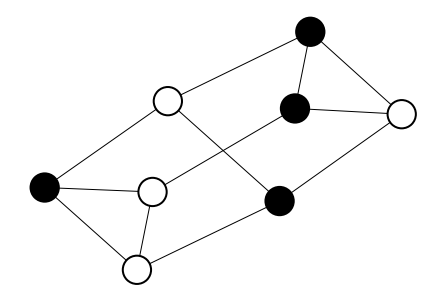

Method,Average,Variance,Best,Approx. Ratio,Cut Dist
Random,6.10,2.91,9.00,0.68,[-5 -4 -9 -6 -7 -6 -7 -7 -6 -9 -3 -6 -7 -6 -7 -6 -7 -9 -3 -5 -5 -7 -5 -6 -7 -6 -8 -9 -8 -6 -6 -3 -8 -7 -7 -3 -4 -5 -8 -5 -5 -7 -3 -3 -3 -6 -8 -9 -6 -7 -6 -8 0 -6 -8 -7 -6 -7 -5 -8 -7 -8 -3 -7 -7 -7 -7 -6 -6 -8 -4 -7 -4 -6 -5 -6 -8 -3 -9 -3 -7 -7 -5 -6 -7 -4 -6 -4 -5 -7 -8 -7 -6 -7 -7 -5 -6 -7 -6 -6]
Brute force,6.00,3.00,10.00,0.60,[ 0 -3 -3 -6 -3 -6 -4 -7 -3 -6 -6 -9 -4 -7 -5 -8 -3 -4 -4 -5 -6 -7 -5 -6 -6 -7 -7 -8 -7 -8 -6 -7 -3 -4 -4 -5 -6 -7 -5 -6 -6 -7 -7 -8 -7 -8 -6 -7 -6 -5 -5 -4 -9 -8 -6 -5 -9 -8 -8 -7 -10 -9 -7 -6 -3 -6 -6 -9 -4 -7 -5 -8 -4 -7 -7 -10 -3 -6 -4 -7 -6 -7 -7 -8 -7 -8 -6 -7 -7 -8 -8 -9 -6 -7 -5 -6 -4 -5 -5 -6 -5 -6 -4 -5 -5 -6 -6 -7 -4 -5 -3 -4 -7 -6 -6 -5 -8 -7 -5 -4 -8 -7 -7 -6 -7 -6 -4 -3 -3 -4 -6 -7 -6 -7 -7 -8 -4 -5 -7 -8 -5 -6 -6 -7 -4 -3 -5 -4 -7 -6 -6 -5 -5 -4 -6 -5 -6 -5 -5 -4 -6 -5 -7 -6 -9 -8 -8 -7 -7 -6 -8 -7 -8 -7 -7 -6 -7 -4 -6 -3 -10 -7 -7 -4 -8 -5 -7 -4 -9 -6 -6 -3 -6 -7 -9 -10 -7 -8 -8 -9 -5 -6 -8 -9 -4 -5 -5 -6 -7 -6 -8 -7 -8 -7 -7 -6 -6 -5 -7 -6 -5 -4 -4 -3 -7 -6 -8 -7 -8 -7 -7 -6 -6 -5 -7 -6 -5 -4 -4 -3 -8 -5 -7 -4 -9 -6 -6 -3 -7 -4 -6 -3 -6 -3 -3 0]
PAOA,8.26,2.03,10.00,0.83,[ -8 -10 -8 -9 -7 -9 -7 -9 -9 -8 -10 -10 -8 -8 -6 -7 -7 -8 -10 -10 -9 -8 -6 -9 -10 -7 -9 -9 -9 -10 -7 -6 -9 -7 -8 -10 -10 -6 -9 -7 -10 -7 -7 -9 -10 -9 -9 -7 -9 -10 -6 -10 -7 -8 -10 -7 -7 -10 -6 -9 -8 -10 -7 -6 -7 -6 -10 -9 -8 -9 -9 -8 -5 -10 -7 -7 -10 -9 -10 -6 -6 -10 -9 -10 -6 -7 -9 -9 -5 -9 -7 -9 -8 -8 -10 -7 -10 -7 -10 -9]
Reduced PAOA,7.35,1.49,9.00,0.82,[-7 -5 -7 -8 -7 -8 -7 -9 -8 -7 -8 -5 -9 -7 -8 -8 -8 -6 -9 -5 -8 -5 -8 -8 -8 -7 -9 -5 -8 -7 -8 -8 -8 -5 -9 -5 -9 -9 -7 -7 -8 -8 -7 -8 -8 -8 -8 -8 -5 -5 -5 -8 -8 -8 -8 -5 -7 -5 -9 -9 -9 -8 -7 -9 -8 -8 -7 -8 -8 -7 -7 -6 -7 -8 -9 -8 -8 -8 -5 -7 -9 -5 -8 -5 -7 -8 -7 -8 -7 -7 -7 -7 -5 -7 -8 -8 -7 -8 -8 -8]
Min PAOA (1 layer),7.92,2.05,10.00,0.79,[ -6 -3 -3 -9 -9 -8 -3 -9 -6 -6 -9 -8 -9 -6 -8 -9 -8 -9 -9 -9 -9 -9 -9 -8 -8 -8 -8 -8 -10 -9 -3 -9 -8 -8 -8 -8 -8 -8 -9 -7 -8 -9 -7 -8 -8 -8 -8 -9 -9 -8 -10 -8 -8 -7 -9 -8 -9 -8 -8 -8 -8 -6 -7 -9 -9 -9 -9 -8 -9 -9 -9 -8 -8 -6 -8 -7 -9 -6 -9 -8 -7 -7 -10 -9 -8 -10 -9 -8 -10 -7 -6 -6 -8 -8 -7 -8 -10 -7 -7 -6]
Min PAOA (3 layers),6.10,2.09,9.00,0.68,[-8 -5 -7 -4 -6 -5 -7 -6 -4 -4 -5 -4 -6 -5 -4 -9 -7 -5 -7 -6 -5 -7 -9 -7 -6 -6 -7 -9 -8 -6 -4 -5 -5 -5 -6 -8 -7 -9 -8 -6 -8 -7 -7 -5 -6 -8 -5 -5 -6 -5 -3 -7 -5 -6 -5 -4 -5 -5 -5 -8 -7 -4 -5 -7 -5 -5 -8 -5 -7 -4 -7 -6 -7 -7 -5 -7 -8 -8 -6 -4 -7 -4 -7 -8 -5 -6 -7 -5 -8 -4 -6 -9 -9 -5 -6 -5 -7 -6 -5 -7]
QAOA (1 layer),7.25,1.65,10.00,0.72,[ -9 -7 -10 -7 -5 -8 -7 -7 -8 -7 -8 -7 -8 -10 -8 -8 -6 -6 -7 -8 -7 -7 -6 -7 -8 -6 -5 -8 -8 -5 -6 -9 -9 -6 -8 -7 -7 -8 -7 -6 -8 -7 -8 -7 -5 -7 -6 -8 -8 -8 -7 -7 -6 -8 -8 -6 -5 -7 -9 -8 -7 -7 -6 -10 -9 -8 -8 -7 -8 -3 -10 -6 -7 -10 -7 -8 -6 -6 -6 -7 -7 -7 -6 -7 -7 -6 -6 -8 -10 -7 -7 -6 -9 -7 -7 -8 -6 -8 -10 -6]
QAOA (3 layers),8.07,2.07,10.00,0.81,[ -8 -10 -10 -10 -8 -8 -6 -9 -7 -10 -8 -10 -8 -10 -7 -10 -9 -8 -8 -6 -10 -10 -8 -6 -8 -10 -9 -8 -8 -8 -8 -8 -6 -7 -7 -10 -7 -7 -10 -7 -10 -10 -9 -9 -7 -7 -9 -6 -10 -6 -8 -8 -7 -6 -10 -8 -8 -8 -6 -6 -8 -8 -6 -9 -8 -8 -10 -9 -6 -7 -7 -7 -6 -6 -8 -8 -10 -9 -5 -8 -6 -8 -10 -7 -6 -10 -6 -7 -8 -9 -10 -10 -8 -10 -10 -9 -10 -6 -8 -6]
QAOA (6 layers),6.83,3.58,10.00,0.68,[ -7 -4 -7 -7 -7 -7 -8 -4 -10 -10 -6 -3 -8 -7 -5 -10 -6 -8 -7 -10 -7 -10 -6 -7 -8 -7 -6 -7 -4 -5 -8 -8 -7 -10 -7 -9 -7 -5 -8 -9 -5 -8 -5 -8 -4 -8 -7 -4 -3 -6 -8 -8 -8 -5 -7 -8 -8 -9 -10 -8 -6 -10 -10 -9 -5 -8 -7 -7 -7 -8 -6 -9 -8 -5 -7 -7 -8 -3 -8 -4 -7 -8 -5 -7 -10 -7 -8 -5 -3 -7 -8 -4 -3 -5 -4 -6 -5 -4 -4 -8]


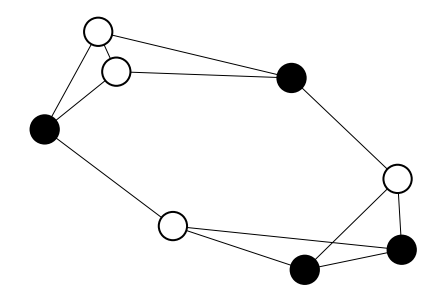

Method,Average,Variance,Best,Approx. Ratio,Cut Dist
Random,6.24,2.08,9.00,0.69,[-7 -6 -6 -6 -7 -7 -6 -7 -7 -5 -7 -7 -7 -7 -4 -7 -7 -7 -5 -6 -3 -5 -7 -7 -6 -8 -7 -6 -7 -8 -5 -7 -6 -7 -6 -5 -6 -8 -6 -2 -7 -3 -3 -6 -7 -8 -6 -6 -6 -7 -6 -7 -7 -6 -7 -7 -6 -7 -7 -5 -6 -8 -8 -3 -8 -7 -7 -6 -8 -7 -9 -2 -7 -6 -5 -5 -4 -4 -7 -7 -7 -7 -7 -6 -7 -8 -7 -6 -8 -6 -3 -5 -6 -7 -7 -8 -3 -8 -7 -3]
Brute force,6.00,3.00,10.00,0.60,[ 0 -3 -3 -6 -3 -4 -4 -5 -3 -6 -4 -7 -4 -5 -3 -4 -3 -4 -6 -7 -6 -5 -7 -6 -6 -7 -7 -8 -7 -6 -6 -5 -3 -4 -6 -7 -6 -5 -7 -6 -6 -7 -7 -8 -7 -6 -6 -5 -4 -3 -7 -6 -7 -4 -8 -5 -7 -6 -8 -7 -8 -5 -7 -4 -3 -6 -6 -9 -6 -7 -7 -8 -6 -9 -7 -10 -7 -8 -6 -7 -4 -5 -7 -8 -7 -6 -8 -7 -7 -8 -8 -9 -8 -7 -7 -6 -4 -5 -7 -8 -7 -6 -8 -7 -7 -8 -8 -9 -8 -7 -7 -6 -3 -2 -6 -5 -6 -3 -7 -4 -6 -5 -7 -6 -7 -4 -6 -3 -3 -6 -4 -7 -6 -7 -5 -6 -4 -7 -3 -6 -5 -6 -2 -3 -6 -7 -7 -8 -9 -8 -8 -7 -7 -8 -6 -7 -8 -7 -5 -4 -6 -7 -7 -8 -9 -8 -8 -7 -7 -8 -6 -7 -8 -7 -5 -4 -7 -6 -8 -7 -10 -7 -9 -6 -8 -7 -7 -6 -9 -6 -6 -3 -4 -7 -5 -8 -7 -8 -6 -7 -5 -8 -4 -7 -6 -7 -3 -4 -5 -6 -6 -7 -8 -7 -7 -6 -6 -7 -5 -6 -7 -6 -4 -3 -5 -6 -6 -7 -8 -7 -7 -6 -6 -7 -5 -6 -7 -6 -4 -3 -4 -3 -5 -4 -7 -4 -6 -3 -5 -4 -4 -3 -6 -3 -3 0]
PAOA,8.92,1.59,10.00,0.89,[ -6 -10 -9 -9 -8 -7 -10 -10 -8 -10 -10 -10 -10 -9 -8 -9 -9 -10 -10 -10 -8 -10 -8 -9 -9 -8 -10 -10 -10 -7 -7 -9 -10 -9 -10 -10 -9 -10 -10 -9 -10 -10 -9 -9 -10 -9 -7 -10 -10 -9 -9 -10 -8 -6 -10 -10 -9 -10 -9 -6 -9 -8 -6 -8 -6 -7 -10 -10 -9 -9 -9 -9 -7 -8 -9 -10 -10 -10 -9 -10 -10 -6 -10 -9 -10 -10 -9 -10 -7 -10 -8 -10 -7 -9 -6 -8 -6 -10 -10 -10]
Reduced PAOA,7.62,1.16,9.00,0.85,[-9 -8 -9 -6 -8 -7 -6 -6 -8 -8 -9 -7 -8 -8 -7 -6 -6 -7 -8 -6 -9 -8 -8 -7 -9 -7 -7 -9 -9 -9 -8 -8 -9 -8 -8 -8 -9 -8 -7 -6 -6 -7 -9 -6 -9 -9 -9 -6 -9 -7 -7 -7 -9 -8 -8 -6 -8 -6 -8 -6 -9 -8 -7 -6 -8 -9 -7 -7 -9 -7 -6 -8 -7 -6 -9 -8 -6 -7 -8 -8 -8 -8 -9 -6 -8 -8 -9 -7 -9 -8 -9 -8 -6 -7 -6 -8 -6 -9 -8 -7]
Min PAOA (1 layer),8.87,0.29,9.00,0.99,[-9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -7 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -6 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -6 -9 -9 -9 -8 -9 -9 -9 -9 -9 -9 -9 -9 -7 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -7 -9 -9 -9]
Min PAOA (3 layers),5.94,2.82,10.00,0.59,[ -7 -3 -7 -6 -5 -5 -9 -6 -7 -6 -6 -6 -8 -3 -6 -8 -5 -7 -4 -6 -10 -4 -4 -4 -5 -6 -5 -4 -4 -8 -4 -4 -8 -7 -6 -8 -3 -8 -8 -8 -6 -6 -7 -7 -4 -9 -8 -4 -8 -6 -6 -4 -5 -7 -8 -4 -7 -4 -7 -5 -4 -4 -5 -6 -7 -3 -8 -7 -3 -7 -8 -5 -6 -6 -6 -9 -6 -7 -7 -6 -6 -3 -7 -8 -3 -7 -6 -4 -6 -3 -6 -7 -7 -4 -4 -8 -7 -7 -7 -4]
QAOA (1 layer),6.90,1.39,10.00,0.69,[-10 -7 -7 -8 -6 -7 -7 -7 -6 -8 -8 -7 -8 -7 -8 -7 -7 -8 -8 -7 -8 -7 -5 -8 -7 -8 -7 -4 -5 -7 -7 -7 -7 -8 -5 -9 -7 -5 -6 -6 -6 -7 -7 -8 -8 -7 -7 -8 -4 -7 -7 -8 -7 -5 -7 -7 -5 -5 -7 -7 -6 -7 -6 -7 -8 -7 -7 -8 -9 -7 -7 -7 -7 -5 -7 -4 -5 -8 -8 -8 -5 -8 -6 -7 -7 -8 -7 -4 -8 -8 -8 -6 -7 -8 -7 -7 -8 -6 -8 -4]
QAOA (3 layers),5.81,2.85,10.00,0.58,[ -6 -8 -8 -5 -4 -5 -7 -5 -3 -7 -4 -5 -7 -7 -4 -4 -4 -3 -7 -7 -6 -4 -7 -7 -3 -6 -7 -7 -7 -4 -7 -5 -6 -7 -5 -6 -7 -7 -7 -7 -3 -7 -5 -3 -7 -8 -7 -6 -3 -5 -3 -8 -7 -8 -3 -7 -5 -9 -10 -5 -8 -7 -7 -7 -6 -7 -3 -8 -7 -7 -7 -5 -7 -4 -4 -5 -4 -5 -7 -7 -3 -7 -7 -7 -3 -3 -5 -7 -7 -6 -7 -7 -3 -7 -7 -7 -5 -3 -4 -3]
QAOA (6 layers),7.12,1.89,10.00,0.71,[ -6 -8 -5 -8 -8 -8 -8 -10 -8 -6 -6 -8 -10 -8 -5 -7 -7 -8 -8 -8 -6 -8 -6 -6 -6 -6 -9 -10 -6 -6 -8 -8 -8 -8 -3 -6 -6 -8 -4 -8 -6 -8 -8 -6 -6 -7 -6 -7 -8 -8 -8 -8 -8 -6 -10 -6 -4 -8 -6 -8 -4 -8 -6 -6 -8 -6 -8 -8 -4 -6 -6 -8 -8 -8 -8 -8 -6 -8 -8 -6 -8 -8 -8 -6 -6 -5 -8 -8 -8 -8 -8 -8 -5 -8 -8 -8 -8 -8 -6 -6]


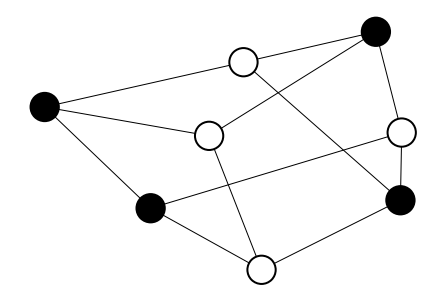

Method,Average,Variance,Best,Approx. Ratio,Cut Dist
Random,5.97,2.91,10.00,0.60,[ -6 -6 -5 -7 -5 -6 -6 -7 -7 -6 -7 -6 -5 -7 -7 -3 -9 -7 -5 -6 -6 -6 -6 -7 -6 -9 -7 -5 -6 -3 -5 -6 -7 -7 -4 -4 -5 -4 -7 -4 -8 -7 -6 -4 -7 -3 -10 -5 -7 -6 -7 -5 -10 -8 -4 -8 -7 -7 -6 -7 -6 -6 -6 -8 -7 -6 -5 -3 -5 0 -5 -7 -10 -3 -6 -6 -3 -4 -7 -7 -3 -6 -6 -6 -4 -7 -7 -9 -6 -3 -5 -4 -6 -9 -8 -6 -7 -6 -6 -4]
Brute force,6.00,3.00,10.00,0.60,[ 0 -3 -3 -6 -3 -6 -6 -9 -3 -4 -4 -5 -4 -5 -5 -6 -3 -6 -4 -7 -4 -7 -5 -8 -6 -7 -5 -6 -5 -6 -4 -5 -3 -6 -6 -9 -4 -7 -7 -10 -6 -7 -7 -8 -5 -6 -6 -7 -6 -9 -7 -10 -5 -8 -6 -9 -9 -10 -8 -9 -6 -7 -5 -6 -3 -4 -4 -5 -6 -7 -7 -8 -6 -5 -5 -4 -7 -6 -6 -5 -6 -7 -5 -6 -7 -8 -6 -7 -9 -8 -6 -5 -8 -7 -5 -4 -4 -5 -5 -6 -5 -6 -6 -7 -7 -6 -6 -5 -6 -5 -5 -4 -7 -8 -6 -7 -6 -7 -5 -6 -10 -9 -7 -6 -7 -6 -4 -3 -3 -4 -6 -7 -6 -7 -9 -10 -6 -5 -7 -6 -7 -6 -8 -7 -4 -5 -5 -6 -5 -6 -6 -7 -7 -6 -6 -5 -6 -5 -5 -4 -4 -5 -7 -8 -5 -6 -8 -9 -7 -6 -8 -7 -6 -5 -7 -6 -5 -6 -6 -7 -4 -5 -5 -6 -8 -7 -7 -6 -5 -4 -4 -3 -6 -5 -7 -6 -9 -8 -10 -9 -9 -6 -8 -5 -10 -7 -9 -6 -7 -6 -6 -5 -8 -7 -7 -6 -10 -7 -7 -4 -9 -6 -6 -3 -5 -4 -6 -5 -6 -5 -7 -6 -8 -5 -7 -4 -7 -4 -6 -3 -6 -5 -5 -4 -5 -4 -4 -3 -9 -6 -6 -3 -6 -3 -3 0]
PAOA,7.78,2.47,10.00,0.78,[-10 -9 -6 -7 -10 -10 -8 -6 -9 -9 -10 -9 -6 -8 -9 -10 -6 -9 -8 -7 -8 -9 -10 -10 -9 -6 -9 -7 -5 -9 -8 -7 -9 -8 -7 -10 -9 -7 -6 -6 -7 -4 -6 -6 -6 -7 -9 -8 -10 -10 -10 -9 -7 -6 -10 -7 -5 -6 -5 -9 -8 -9 -9 -9 -7 -7 -8 -9 -10 -7 -7 -8 -6 -6 -9 -7 -7 -7 -4 -8 -10 -10 -8 -5 -7 -7 -10 -9 -5 -6 -7 -10 -8 -8 -7 -7 -9 -7 -7 -7]
Reduced PAOA,7.92,1.93,10.00,0.79,[ -6 -9 -9 -7 -9 -6 -10 -7 -9 -9 -8 -9 -7 -9 -9 -9 -7 -9 -9 -9 -6 -9 -10 -6 -8 -6 -9 -10 -10 -9 -9 -8 -7 -7 -6 -9 -9 -9 -6 -8 -9 -7 -7 -7 -7 -7 -9 -9 -9 -6 -9 -9 -7 -7 -6 -9 -9 -9 -6 -5 -9 -7 -8 -10 -7 -6 -9 -9 -6 -10 -9 -9 -6 -6 -6 -9 -6 -9 -9 -9 -6 -9 -9 -6 -8 -6 -6 -9 -6 -10 -7 -8 -7 -6 -7 -9 -9 -6 -9 -10]
Min PAOA (1 layer),8.80,1.72,10.00,0.88,[ -6 -9 -9 -9 -10 -10 -10 -9 -6 -9 -9 -10 -10 -9 -10 -7 -6 -10 -10 -10 -8 -8 -10 -9 -9 -9 -8 -10 -9 -8 -9 -10 -10 -10 -10 -10 -9 -8 -10 -9 -9 -10 -6 -9 -5 -7 -9 -8 -9 -10 -7 -9 -10 -10 -9 -10 -10 -10 -7 -6 -9 -9 -9 -6 -10 -9 -10 -6 -7 -8 -8 -9 -10 -10 -10 -8 -6 -6 -9 -9 -9 -9 -7 -6 -9 -9 -9 -10 -9 -10 -10 -9 -9 -9 -10 -10 -9 -10 -8 -10]
Min PAOA (3 layers),7.20,3.84,10.00,0.72,[ -7 -7 -10 -7 -4 -6 -9 -5 -7 -6 -3 -9 -6 -7 -5 -9 -10 -10 -10 -10 -10 -9 -6 -6 -7 -6 -7 -3 -10 -6 -6 -6 -8 -7 -9 -5 -6 -6 -6 -7 -6 -5 -6 -7 -7 -7 -7 -10 -10 -4 -8 -7 -4 -5 -6 -9 -7 -10 -6 -9 -6 -9 -9 -8 -5 -7 -9 -7 -6 -9 -9 -10 -6 -7 -6 -3 -6 -10 -10 -6 -9 -7 -8 -4 -9 -8 -10 -7 -7 -7 -3 -4 -10 -9 -10 -5 -6 -6 -10 -10]
QAOA (1 layer),6.54,2.79,10.00,0.65,[ -6 -8 0 -10 -6 -7 -7 -6 -5 -9 -5 -6 -8 -8 -5 -6 -5 -9 -10 -5 -8 -10 -6 -8 -6 -5 -7 -5 -4 -10 -8 -6 -6 -8 -5 -6 -6 -7 -6 -5 -8 -6 -5 -6 -6 -6 -6 -5 -6 -6 -10 -6 -6 -10 -6 -6 -6 -8 -8 -8 -8 -5 -7 -5 -6 -8 -7 -5 -6 -4 -9 -6 -5 -6 -6 -8 -6 -10 -6 -6 -10 -6 -8 -6 -7 -8 -6 -6 -10 -5 -5 -6 -6 -6 -5 -6 -6 -6 -6 -4]
QAOA (3 layers),6.90,3.63,10.00,0.69,[ -8 -10 -6 -8 -7 -6 -8 -6 -8 -8 -5 -6 -7 -8 -7 -8 -6 -7 -9 -8 -6 -6 -3 -6 -7 -10 -6 -6 -8 -6 -4 -10 -8 -6 -6 -7 -7 -8 -8 -8 -8 -8 -8 -8 -7 -8 -8 -6 -7 -6 -8 -9 0 -6 -8 -7 -8 -10 -10 -6 -8 -9 -7 -5 -7 -5 -8 -8 0 -8 -7 -6 -7 -6 -8 -6 -7 -8 -6 -7 -8 -7 0 -4 -8 -8 -4 -8 -7 -8 -8 -8 -10 -3 -8 -8 -6 -8 -5 -3]
QAOA (6 layers),7.35,1.17,10.00,0.73,[ -8 -8 -7 -9 -6 -8 -7 -8 -7 -6 -6 -6 -4 -8 -8 -8 -8 -8 -8 -6 -8 -8 -7 -8 -7 -8 -7 -6 -8 -8 -5 -8 -8 -8 -8 -8 -6 -7 -7 -8 -8 -4 -8 -8 -8 -7 -8 -7 -8 -8 -8 -5 -7 -8 -8 -8 -8 -7 -7 -8 -10 -8 -6 -8 -7 -8 -8 -8 -8 -7 -8 -7 -8 -8 -8 -6 -7 -6 -7 -8 -7 -8 -8 -8 -6 -8 -10 -6 -8 -8 -6 -6 -8 -8 -6 -7 -6 -8 -8 -4]


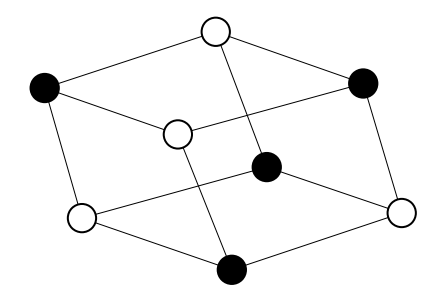

Method,Average,Variance,Best,Approx. Ratio,Cut Dist
Random,5.89,3.26,12.00,0.49,[ -5 -7 -3 -5 -7 -3 -5 -4 -5 -7 -9 -3 -5 -6 -5 -5 -7 -7 -5 -6 -7 -5 0 -6 -4 -5 -7 -6 -6 -8 -7 -6 -6 -4 -6 -6 -3 -9 -7 -8 -6 -9 -5 -5 -9 -12 -7 -8 -7 -4 -6 -7 -6 -9 -5 -3 -4 -5 -6 -6 -7 -5 -3 -5 -6 -7 -6 -4 -6 -5 -5 -7 -5 -4 -8 -6 -9 -6 -5 -6 -5 -7 -5 -6 -5 -6 -7 -6 -6 -5 -9 -12 -5 -5 -7 -6 -6 -4 -3 -5]
Brute force,6.00,3.00,12.00,0.50,[ 0 -3 -3 -4 -3 -6 -4 -5 -3 -4 -6 -5 -6 -7 -7 -6 -3 -6 -4 -5 -6 -9 -5 -6 -4 -5 -5 -4 -7 -8 -6 -5 -3 -6 -6 -7 -4 -7 -5 -6 -6 -7 -9 -8 -7 -8 -8 -7 -4 -7 -5 -6 -5 -8 -4 -5 -5 -6 -6 -5 -6 -7 -5 -4 -3 -6 -6 -7 -6 -9 -7 -8 -4 -5 -7 -6 -7 -8 -8 -7 -6 -9 -7 -8 -9 -12 -8 -9 -5 -6 -6 -5 -8 -9 -7 -6 -4 -7 -7 -8 -5 -8 -6 -7 -5 -6 -8 -7 -6 -7 -7 -6 -5 -8 -6 -7 -6 -9 -5 -6 -4 -5 -5 -4 -5 -6 -4 -3 -3 -4 -6 -5 -4 -5 -5 -4 -6 -5 -9 -6 -7 -6 -8 -5 -6 -7 -7 -6 -7 -8 -6 -5 -7 -6 -8 -5 -8 -7 -7 -4 -6 -7 -9 -8 -5 -6 -6 -5 -9 -8 -12 -9 -8 -7 -9 -6 -7 -8 -8 -7 -6 -7 -5 -4 -8 -7 -9 -6 -7 -6 -6 -3 -4 -5 -7 -6 -5 -6 -6 -5 -5 -4 -8 -5 -6 -5 -7 -4 -7 -8 -8 -7 -8 -9 -7 -6 -6 -5 -7 -4 -7 -6 -6 -3 -5 -6 -8 -7 -4 -5 -5 -4 -6 -5 -9 -6 -5 -4 -6 -3 -6 -7 -7 -6 -5 -6 -4 -3 -5 -4 -6 -3 -4 -3 -3 0]
PAOA,9.69,5.41,12.00,0.81,[ -9 -9 -7 -6 -12 -8 -9 -12 -12 -9 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -6 -9 -12 -8 -12 -6 -12 -12 -9 -12 -7 -9 -9 -12 -12 -9 -12 -8 -9 -12 -6 -12 -6 -6 -12 -12 -6 -12 -7 -6 -12 -8 -7 -9 -9 -9 -12 -6 -7 -9 -12 -12 -12 -12 -12 -12 -12 -6 -12 -9 -12 -8 -6 -8 -12 -12 -9 -9 -6 -8 -9 -8 -12 -5 -8 -9 -7 -6 -12 -9 -12 -7 -9 -7 -12 -12 -12 -9 -12 -8]
Reduced PAOA,7.41,1.50,9.00,0.82,[-6 -6 -6 -7 -9 -7 -8 -8 -6 -8 -6 -6 -9 -6 -6 -9 -6 -6 -9 -8 -9 -6 -9 -6 -9 -9 -8 -6 -8 -8 -8 -7 -9 -6 -9 -6 -9 -9 -6 -6 -9 -6 -9 -4 -7 -8 -6 -8 -9 -9 -7 -6 -9 -9 -7 -8 -9 -6 -7 -9 -9 -7 -7 -7 -8 -8 -7 -6 -6 -8 -8 -8 -9 -8 -6 -9 -8 -9 -8 -8 -6 -8 -6 -7 -8 -9 -8 -8 -7 -6 -6 -6 -8 -7 -6 -7 -6 -8 -7 -6]
Min PAOA (1 layer),12.00,0.00,12.00,1.00,[-12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12]
Min PAOA (3 layers),7.38,4.76,12.00,0.61,[-12 -9 -12 -9 -6 -7 -6 -9 -12 -7 -4 -6 -8 -7 -12 -12 -8 -9 -12 -6 -6 -6 -6 -3 -6 -4 -6 -9 -7 -5 -9 -7 -8 -7 -6 -4 -12 -8 -8 -5 -5 -7 -7 -7 -5 -8 -6 -7 -5 -6 -7 -8 -3 -9 -5 -7 -12 -7 -9 -9 -6 -12 -9 -9 -7 -8 -5 -6 -8 -6 -8 -5 -6 -9 -4 -9 -8 -9 -7 -9 -12 -5 -8 -6 -6 -7 -9 -7 -7 -9 -6 -7 -6 -8 -12 -6 -6 -5 -5 -7]
QAOA (1 layer),7.69,5.01,12.00,0.64,[-12 -12 -7 -12 -9 -8 -7 -6 -5 -6 -4 -8 -8 -8 -5 -12 -7 -3 -8 -7 -9 -6 -9 -8 -12 -9 -12 -8 -5 -8 -8 -6 -6 -8 -4 -8 -12 -7 -8 -5 -9 -9 -12 -4 -5 -7 -9 -12 -5 -5 -8 -5 -6 -6 -8 -8 -7 -8 -6 -6 -12 -9 -8 -6 -8 -6 -12 -7 -12 -6 -8 -12 -5 -7 -9 -8 -7 -6 -12 -8 -7 -8 -7 -6 -8 -6 -4 -8 -8 -7 -6 -5 -6 -8 -7 -8 -8 -8 -7 -12]
QAOA (3 layers),8.90,9.43,12.00,0.74,[ -6 -12 -5 -7 -8 -12 -5 -6 -6 -5 -7 -12 -12 -7 -9 -12 -6 -7 -6 -12 -6 -8 -12 -12 -12 -9 -12 -12 -8 -5 -8 -6 -12 -12 0 -6 -12 -5 -6 -6 -12 -12 -7 -12 -12 -6 -6 -12 -12 -9 -12 -5 -12 -8 -5 -8 -7 -12 -12 -12 -6 -9 -12 -6 -9 -12 -12 -9 -8 -6 -12 -12 -5 -12 -12 -12 -6 -12 -8 -7 -12 0 -12 -6 -7 -12 -8 -12 -12 -12 -8 -12 -12 -3 -6 -12 -6 -9 -6 -12]
QAOA (6 layers),7.21,8.31,12.00,0.60,[-12 -12 -6 -4 -5 -9 -12 -8 -12 -7 -8 -4 -5 -5 -12 -9 -8 -12 -5 -8 -7 -6 -12 -12 -6 0 -9 -12 -6 -6 0 -5 -3 -7 -7 -8 -8 -7 -4 -6 -7 -7 -12 -4 -5 -6 -4 -12 -8 -8 -4 -7 -8 -4 -4 -6 -8 -12 -4 -12 -12 -9 -8 0 -8 -9 -12 -6 -8 -6 -5 -9 -4 -9 -7 -8 -5 -12 -6 -9 -6 -5 -8 -8 -4 -12 -4 -8 -8 -4 -4 -4 -8 -8 -6 -6 -6 -9 -9 -6]


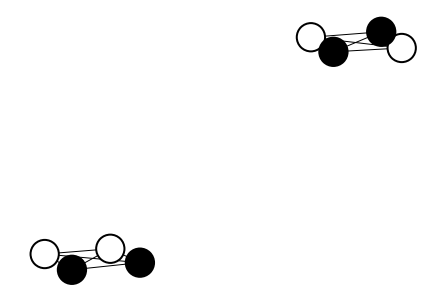

Method,Average,Variance,Best,Approx. Ratio,Cut Dist
Random,6.14,2.70,8.00,0.77,[-8 -6 -8 -3 -8 -7 -8 -6 -8 -3 -7 -8 -6 -7 -7 -8 -6 -6 -6 -6 -8 -8 -6 -8 -4 -8 -4 -6 -6 -7 -7 -3 -8 -8 -7 -7 -7 -7 -6 -3 -3 -7 -7 -8 -7 -7 -7 -7 -7 -3 -6 -7 -6 -4 -6 -6 -6 -6 -8 0 -6 -3 -3 -3 -7 -7 -7 -8 -6 -7 -7 -7 -8 -7 -7 -6 -4 -6 -7 -3 -4 -6 -6 -4 -6 -6 -6 -7 -3 -7 -6 -7 -7 -8 -7 -4 -6 -7 -6 -4]
Brute force,6.00,3.00,8.00,0.75,[ 0 -3 -3 -4 -3 -4 -4 -3 -3 -6 -6 -7 -6 -7 -7 -6 -3 -4 -4 -3 -4 -3 -3 0 -6 -7 -7 -6 -7 -6 -6 -3 -3 -6 -6 -7 -6 -7 -7 -6 -4 -7 -7 -8 -7 -8 -8 -7 -6 -7 -7 -6 -7 -6 -6 -3 -7 -8 -8 -7 -8 -7 -7 -4 -3 -6 -6 -7 -6 -7 -7 -6 -4 -7 -7 -8 -7 -8 -8 -7 -6 -7 -7 -6 -7 -6 -6 -3 -7 -8 -8 -7 -8 -7 -7 -4 -4 -7 -7 -8 -7 -8 -8 -7 -3 -6 -6 -7 -6 -7 -7 -6 -7 -8 -8 -7 -8 -7 -7 -4 -6 -7 -7 -6 -7 -6 -6 -3 -3 -6 -6 -7 -6 -7 -7 -6 -4 -7 -7 -8 -7 -8 -8 -7 -6 -7 -7 -6 -7 -6 -6 -3 -7 -8 -8 -7 -8 -7 -7 -4 -4 -7 -7 -8 -7 -8 -8 -7 -3 -6 -6 -7 -6 -7 -7 -6 -7 -8 -8 -7 -8 -7 -7 -4 -6 -7 -7 -6 -7 -6 -6 -3 -4 -7 -7 -8 -7 -8 -8 -7 -3 -6 -6 -7 -6 -7 -7 -6 -7 -8 -8 -7 -8 -7 -7 -4 -6 -7 -7 -6 -7 -6 -6 -3 -3 -6 -6 -7 -6 -7 -7 -6 0 -3 -3 -4 -3 -4 -4 -3 -6 -7 -7 -6 -7 -6 -6 -3 -3 -4 -4 -3 -4 -3 -3 0]
PAOA,7.21,0.53,8.00,0.90,[-7 -6 -8 -6 -8 -8 -8 -6 -7 -8 -8 -8 -8 -6 -7 -7 -7 -7 -8 -6 -8 -6 -8 -7 -7 -7 -7 -7 -7 -6 -6 -7 -7 -7 -7 -7 -7 -7 -8 -8 -7 -7 -8 -7 -8 -8 -8 -7 -8 -6 -8 -7 -8 -8 -8 -7 -8 -7 -7 -8 -8 -7 -7 -6 -6 -8 -7 -6 -8 -6 -7 -6 -8 -8 -8 -8 -7 -7 -8 -8 -6 -7 -8 -7 -8 -6 -6 -7 -6 -7 -7 -8 -7 -7 -7 -8 -8 -8 -7 -7]
Reduced PAOA,7.56,0.25,8.00,0.94,[-8 -8 -8 -8 -7 -8 -7 -8 -7 -8 -7 -8 -8 -8 -7 -8 -8 -8 -7 -7 -8 -8 -8 -7 -8 -8 -8 -8 -7 -8 -8 -7 -8 -8 -7 -7 -7 -7 -7 -7 -8 -7 -7 -7 -7 -7 -8 -8 -8 -8 -7 -8 -7 -7 -8 -8 -7 -8 -7 -8 -7 -8 -7 -7 -7 -7 -7 -7 -8 -7 -8 -8 -8 -7 -8 -8 -8 -7 -8 -8 -8 -8 -8 -8 -7 -8 -8 -8 -8 -8 -7 -8 -7 -7 -8 -8 -7 -7 -7 -7]
Min PAOA (1 layer),7.95,0.07,8.00,0.99,[-6 -8 -8 -7 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -7 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -7]
Min PAOA (3 layers),6.79,0.39,8.00,0.85,[-8 -7 -6 -7 -6 -8 -7 -7 -7 -7 -6 -7 -8 -6 -7 -8 -6 -8 -6 -8 -7 -6 -7 -7 -7 -7 -7 -6 -7 -6 -8 -7 -7 -7 -7 -7 -6 -6 -7 -7 -7 -6 -7 -6 -7 -7 -6 -6 -6 -7 -7 -6 -6 -6 -7 -7 -6 -7 -7 -6 -7 -7 -7 -6 -7 -6 -6 -7 -7 -7 -7 -6 -7 -7 -8 -6 -6 -7 -8 -7 -7 -7 -6 -7 -7 -7 -6 -8 -7 -7 -7 -6 -7 -6 -7 -8 -6 -7 -7 -7]
QAOA (1 layer),7.34,0.60,8.00,0.92,[-8 -7 -7 -8 -7 -7 -8 -7 -7 -6 -8 -7 -7 -8 -8 -8 -8 -6 -8 -7 -8 -8 -7 -7 -8 -8 -7 -8 -8 -8 -6 -8 -7 -7 -7 -8 -8 -8 -6 -7 -8 -7 -8 -8 -7 -6 -8 -8 -8 -7 -7 -8 -8 -7 -7 -7 -7 -8 -8 -7 -7 -8 -7 -8 -6 -7 -6 -8 -7 -7 -7 -6 -8 -6 -7 -8 -7 -7 -7 -7 -8 -7 -7 -7 -7 -8 -8 -7 -8 -8 -8 -8 -8 -3 -7 -7 -8 -8 -8 -8]
QAOA (3 layers),7.30,0.71,8.00,0.91,[-6 -8 -6 -8 -8 -6 -8 -7 -6 -7 -7 -8 -8 -8 -8 -8 -7 -8 -7 -7 -6 -7 -8 -7 -8 -7 -8 -8 -7 -7 -8 -6 -8 -8 -7 -8 -8 -7 -7 -8 -7 -8 -8 -8 -6 -7 -7 -8 -7 -6 -7 -6 -6 -8 -6 -8 -7 -7 -6 -8 -8 -7 -7 -8 -8 -8 -8 -6 -7 -7 -8 -7 -7 -8 -8 -8 -8 -3 -8 -7 -8 -8 -8 -8 -7 -7 -7 -8 -8 -6 -7 -8 -8 -7 -6 -7 -8 -8 -7 -8]
QAOA (6 layers),5.42,6.68,8.00,0.68,[-8 -4 -8 -4 -4 -4 -8 -4 -8 -8 -8 -4 -4 -4 -3 -8 -4 -8 -8 -4 -4 -8 0 -3 -8 -4 -4 -4 -8 -8 -4 0 -4 -4 -8 -8 0 -8 -8 -8 -4 -8 -8 -4 -8 -8 -4 -4 0 -8 -4 -4 -8 -4 -4 0 -4 -8 -4 -4 -4 -8 -4 -7 -8 -8 -4 -8 -8 -4 -8 -8 -7 -4 -8 -4 -4 -8 -8 -4 -8 -8 0 -4 -3 -4 0 -8 -3 -8 -8 -4 -4 -8 0 0 -4 -8 -8 -8]


 75%|█████████████████████████████████           | 3/4 [09:24<03:53, 233.83s/it]

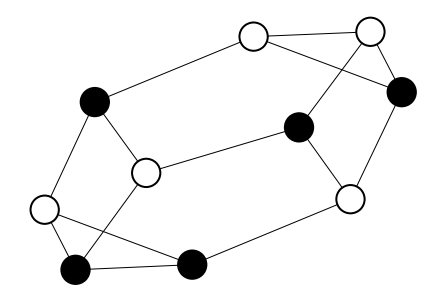

Method,Average,Variance,Best,Approx. Ratio,Cut Dist
Random,7.72,4.70,13.00,0.59,[ -8 -9 -7 -7 -6 -7 -8 -9 -6 -6 -9 -5 -10 -8 -7 -4 -9 -7 -7 -3 -9 -8 -6 -9 -6 -10 -3 -9 -8 -5 -6 -8 -11 -8 -4 -8 -8 -11 -10 -11 -3 -9 -11 -8 -8 -9 -7 -9 -10 -7 -8 -10 -5 -8 -4 -7 -8 -6 -6 -10 -10 -6 -11 -9 -3 -8 -5 -10 -7 -7 -7 -9 -13 -8 -10 -4 -7 -10 -7 -9 -9 -7 -13 -9 -6 -10 -8 -7 -4 -4 -8 -10 -7 -8 -9 -5 -8 -9 -12 -6]
Brute force,7.50,3.75,13.00,0.58,[ 0 -3 -3 ... -3 -3 0]
PAOA,9.80,1.46,12.00,0.82,[-11 -10 -6 -10 -10 -10 -11 -6 -10 -8 -8 -8 -10 -11 -10 -7 -10 -11 -11 -11 -10 -10 -11 -10 -7 -9 -10 -10 -11 -11 -8 -8 -11 -9 -11 -10 -8 -9 -9 -9 -10 -7 -10 -10 -10 -9 -10 -10 -11 -11 -11 -10 -11 -7 -9 -8 -11 -10 -10 -8 -10 -11 -11 -10 -11 -9 -10 -9 -10 -10 -11 -9 -9 -10 -10 -10 -9 -11 -10 -11 -9 -9 -10 -11 -10 -9 -12 -11 -10 -11 -10 -11 -11 -10 -11 -10 -11 -11 -10 -9]
Reduced PAOA,9.61,1.84,12.00,0.80,[ -8 -11 -10 -11 -12 -6 -10 -9 -7 -11 -8 -10 -8 -10 -8 -10 -10 -9 -10 -10 -9 -10 -10 -10 -12 -11 -7 -11 -10 -11 -11 -10 -11 -12 -10 -7 -11 -11 -9 -10 -10 -9 -8 -11 -10 -11 -11 -9 -10 -11 -10 -10 -11 -9 -11 -10 -10 -8 -10 -9 -9 -11 -7 -11 -10 -7 -7 -9 -9 -9 -10 -8 -10 -8 -10 -11 -7 -11 -10 -10 -10 -11 -10 -7 -11 -10 -10 -6 -10 -10 -10 -8 -8 -10 -9 -9 -9 -9 -9 -12]
Min PAOA (1 layer),10.73,0.66,11.00,0.98,[ -6 -10 -10 -10 -9 -11 -11 -11 -11 -11 -11 -11 -10 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -10 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -10 -10 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -10 -8 -7 -11 -11 -11 -11 -11 -11 -8 -10 -10]
Min PAOA (3 layers),8.64,2.43,12.00,0.72,[ -8 -8 -10 -9 -7 -11 -9 -11 -8 -8 -9 -11 -8 -12 -8 -7 -10 -10 -6 -7 -9 -9 -10 -7 -9 -6 -6 -10 -9 -9 -11 -8 -11 -9 -8 -6 -8 -9 -6 -9 -10 -8 -10 -10 -7 -8 -8 -12 -9 -9 -7 -7 -7 -7 -8 -7 -8 -9 -9 -9 -12 -9 -9 -6 -9 -8 -7 -8 -9 -7 -10 -11 -10 -10 -9 -8 -11 -8 -8 -9 -9 -8 -8 -7 -11 -10 -7 -8 -9 -11 -8 -5 -10 -9 -7 -6 -7 -11 -8 -12]
QAOA (1 layer),8.46,3.43,13.00,0.65,[-10 -9 -7 -8 -11 -7 -8 -7 -11 -9 -7 -8 -7 -10 -8 -7 -6 -8 -11 -7 -8 -7 -7 -13 -8 -7 -9 -11 -9 -6 -7 -3 -9 -10 -7 -9 -7 -13 -8 -6 -8 -8 -10 -7 -10 -10 -8 -13 -11 -6 -9 -9 -9 -11 -6 -10 -8 -9 -9 -9 -5 -11 -8 -6 -9 -6 -8 -9 -9 -11 -7 -7 -9 -12 -10 -7 -9 -6 -9 -12 -10 -8 -9 -9 -5 -6 -9 -8 -8 -8 -7 -11 -7 -9 -7 -7 -8 -11 -8 -11]
QAOA (3 layers),9.08,8.47,13.00,0.70,[ -6 -6 -7 -13 -7 -13 -12 -6 -13 -6 -13 -11 -6 -8 -7 -9 -12 -8 -7 -13 -8 -6 -6 -13 -10 -7 -13 -7 -7 -13 -6 -6 -13 -10 -6 -8 -13 -7 -11 -6 -9 -6 -9 -6 -13 -6 -10 -8 -4 -10 -6 -6 -13 -13 -6 -9 -12 -6 -6 -6 -13 -6 -12 -13 -6 -13 -11 -6 -6 -11 -13 -10 -13 -4 -6 -6 -7 -11 -10 -13 -13 -13 -6 -7 -10 -9 -13 -10 -12 -12 -6 -6 -13 -8 -8 -13 -9 -13 -7 -7]
QAOA (6 layers),8.49,5.01,13.00,0.65,[ -9 -6 -6 -9 -10 -10 -6 -8 -7 -6 -8 -7 -10 -9 -7 -4 -5 -9 -10 -9 -11 -9 -9 -5 -7 -8 -9 -8 -12 -7 -9 -13 -11 -9 -6 -7 -7 -12 -5 -12 -5 -9 -11 -5 -6 -8 -9 -8 -13 -4 -7 -12 -8 -13 -8 -9 -9 -5 -8 -8 -6 -13 -7 -8 -10 -9 -7 -8 -7 -7 -8 -9 -8 -13 -9 -7 -10 -6 -10 -5 -9 -10 -10 -9 -13 -12 -6 -5 -9 -11 -10 -8 -7 -8 -10 -8 -8 -13 -8 -12]


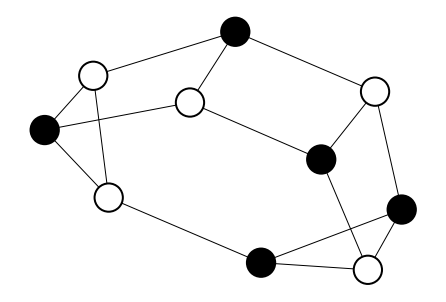

Method,Average,Variance,Best,Approx. Ratio,Cut Dist
Random,7.56,3.57,13.00,0.58,[-10 -5 -8 -8 -5 -4 -6 -8 -9 -7 -8 -9 -6 -10 -9 -9 -10 -8 -10 -7 -7 -7 -7 -6 -9 -9 -3 -7 -10 -6 -6 -7 -6 -8 -7 -7 -4 -7 -10 -7 -4 -4 -8 -7 -8 -7 -7 -8 -8 -9 -10 -9 -10 -4 -9 -9 -9 -8 -4 -9 -7 -6 -12 -8 -8 -6 -7 -5 -3 -9 -9 -13 -8 -9 -9 -9 -7 -6 -5 -10 -9 -7 -6 -7 -8 -5 -10 -6 -9 -6 -8 -9 -7 -7 -6 -7 -9 -8 -8 -11]
Brute force,7.50,3.75,13.00,0.58,[ 0 -3 -3 ... -3 -3 0]
PAOA,10.12,2.33,12.00,0.84,[ -9 -11 -12 -12 -9 -11 -9 -9 -7 -11 -11 -11 -11 -12 -11 -11 -11 -10 -9 -10 -11 -11 -11 -9 -8 -11 -11 -5 -10 -11 -9 -11 -11 -7 -11 -10 -11 -12 -11 -10 -11 -11 -7 -10 -9 -9 -11 -11 -10 -10 -10 -11 -11 -11 -11 -9 -11 -11 -11 -11 -11 -7 -8 -11 -11 -11 -11 -11 -11 -11 -11 -8 -11 -6 -5 -9 -10 -7 -11 -11 -11 -11 -11 -12 -8 -11 -7 -9 -9 -11 -10 -11 -10 -12 -12 -11 -11 -11 -10 -8]
Reduced PAOA,9.32,1.68,13.00,0.72,[-11 -8 -10 -9 -7 -11 -10 -9 -11 -9 -11 -9 -8 -10 -8 -10 -10 -9 -9 -8 -8 -8 -10 -11 -10 -8 -11 -11 -11 -10 -9 -6 -10 -8 -10 -10 -9 -8 -9 -9 -5 -9 -10 -11 -9 -10 -8 -9 -9 -9 -8 -10 -10 -11 -10 -10 -6 -9 -9 -10 -11 -9 -10 -8 -10 -9 -9 -11 -8 -13 -9 -10 -9 -9 -9 -9 -10 -8 -7 -9 -11 -12 -11 -9 -8 -11 -10 -9 -9 -9 -10 -8 -9 -7 -9 -10 -11 -8 -10 -9]
Min PAOA (1 layer),9.44,1.41,11.00,0.86,[-10 -11 -10 -11 -7 -8 -8 -8 -9 -8 -11 -11 -9 -9 -11 -11 -11 -10 -11 -9 -9 -7 -9 -8 -8 -8 -7 -10 -11 -9 -10 -9 -8 -9 -9 -9 -9 -11 -10 -9 -10 -11 -10 -11 -9 -8 -9 -8 -10 -11 -10 -10 -10 -9 -8 -11 -9 -9 -9 -8 -11 -10 -11 -9 -10 -7 -10 -11 -11 -10 -8 -9 -9 -9 -9 -9 -9 -9 -9 -11 -9 -9 -8 -11 -11 -9 -10 -7 -10 -11 -11 -11 -11 -10 -8 -9 -11 -9 -8 -8]
Min PAOA (3 layers),8.52,2.31,12.00,0.71,[ -7 -9 -9 -8 -9 -11 -7 -10 -11 -8 -7 -7 -6 -7 -8 -9 -9 -8 -8 -11 -10 -8 -7 -10 -9 -8 -8 -11 -8 -9 -8 -11 -8 -8 -7 -10 -7 -9 -10 -9 -10 -6 -9 -7 -7 -9 -8 -5 -9 -11 -9 -9 -10 -9 -6 -4 -8 -7 -6 -7 -9 -12 -8 -8 -8 -8 -10 -8 -6 -8 -8 -12 -8 -9 -10 -7 -10 -10 -9 -9 -11 -7 -7 -10 -10 -7 -8 -9 -9 -10 -8 -9 -8 -6 -9 -10 -11 -9 -7 -10]
QAOA (1 layer),8.14,2.66,11.00,0.74,[ -9 -11 -10 -8 -7 -5 -9 -9 -9 -9 -7 -10 -9 -7 -11 -10 -9 -9 -7 -7 -7 -8 -11 -9 -8 -5 -6 -8 -11 -8 -8 -11 -7 -10 -8 -9 -7 -9 -8 -7 -11 -10 -8 -11 -10 -11 -7 -11 -7 -6 -8 -7 -9 -8 -6 -5 -9 -8 -8 -11 -8 -9 -8 -4 -7 -7 -8 -6 -6 -9 -8 -9 -8 -7 -10 -10 -6 -7 -8 -10 -7 -8 -9 -6 -9 -8 -7 -8 -8 -8 -6 -7 -7 -9 -11 -7 -7 -7 -8 -4]
QAOA (3 layers),7.88,3.45,12.00,0.66,[ -8 -7 -8 -9 -8 -9 -6 -7 -10 -8 -9 -8 -7 -9 -7 -11 -7 -6 -10 -7 -11 -6 -11 -6 -7 -7 -7 -7 -11 -7 -8 -8 -11 -9 -6 -6 -8 -10 -10 -7 -8 -7 -8 -10 -8 -10 -9 -6 -8 -6 -9 -9 -5 -6 -11 -7 -8 -6 -5 -12 -7 -7 -6 -9 -8 -7 -4 -11 -8 -7 -8 -4 -10 -4 -4 -12 -7 -3 -7 -6 -7 -8 -7 -8 -6 -8 -9 -8 -9 -7 -6 -10 -11 -9 -10 -10 -9 -9 -7 -9]
QAOA (6 layers),7.71,3.25,13.00,0.59,[ -4 -6 -8 -4 -9 -7 -8 -6 -7 -8 -9 -8 -7 -9 -7 -6 -8 -9 -9 -8 -6 -6 -7 -8 -8 -8 -7 -4 -7 -4 -9 -8 -10 -9 -9 -9 -9 -8 -5 -4 -9 -7 -5 -11 -9 -7 -8 -8 -8 -8 -9 -10 -9 -7 -9 -9 -7 -7 -10 -8 -5 -8 -8 -5 -10 -9 -6 -10 -10 -8 -8 -9 -10 -7 -8 -6 -10 -9 -6 -6 -8 -10 -5 -8 -6 -6 -8 -6 -4 -8 -13 -8 -8 -10 -11 -5 -7 -9 -5 -11]


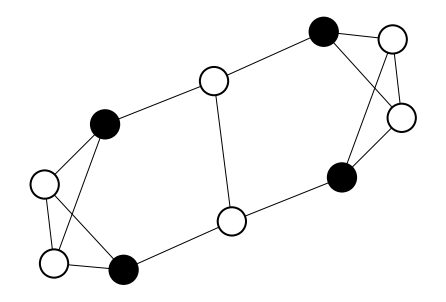

Method,Average,Variance,Best,Approx. Ratio,Cut Dist
Random,7.78,2.67,11.00,0.71,[-10 -8 -7 -8 -8 -4 -7 -7 -5 -7 -6 -9 -6 -7 -10 -7 -7 -8 -8 -8 -9 -6 -3 -7 -10 -7 -7 -7 -9 -8 -10 -9 -8 -8 -7 -10 -5 -11 -7 -9 -7 -6 -7 -8 -8 -7 -7 -5 -8 -8 -8 -6 -7 -8 -8 -8 -7 -7 -10 -8 -8 -9 -9 -3 -8 -5 -4 -10 -8 -9 -9 -9 -7 -5 -7 -9 -10 -9 -11 -6 -7 -7 -10 -11 -7 -9 -7 -10 -9 -10 -10 -8 -7 -8 -8 -8 -8 -9 -10 -8]
Brute force,7.50,3.75,12.00,0.62,[ 0 -3 -3 ... -3 -3 0]
PAOA,10.10,1.13,12.00,0.84,[ -7 -10 -8 -11 -12 -10 -10 -10 -10 -8 -11 -10 -11 -10 -10 -10 -8 -12 -10 -11 -9 -10 -11 -9 -8 -11 -9 -9 -10 -10 -10 -11 -10 -10 -11 -10 -10 -11 -11 -9 -10 -11 -8 -10 -10 -11 -11 -11 -11 -11 -10 -11 -11 -10 -10 -10 -11 -10 -11 -10 -10 -10 -10 -10 -10 -10 -9 -8 -11 -11 -10 -9 -7 -11 -9 -11 -11 -7 -11 -11 -11 -11 -11 -11 -11 -10 -12 -11 -9 -11 -9 -11 -10 -9 -10 -11 -11 -11 -9 -9]
Reduced PAOA,10.33,0.48,11.00,0.94,[-10 -9 -11 -10 -10 -11 -11 -11 -11 -9 -9 -11 -11 -10 -11 -10 -10 -10 -11 -11 -11 -10 -11 -10 -10 -10 -10 -10 -11 -11 -10 -11 -11 -10 -10 -11 -11 -10 -9 -10 -10 -11 -11 -9 -10 -10 -11 -10 -10 -10 -11 -10 -11 -10 -11 -11 -11 -10 -7 -10 -11 -10 -11 -11 -11 -11 -10 -10 -11 -10 -10 -10 -11 -10 -11 -10 -10 -11 -10 -10 -10 -10 -11 -11 -10 -11 -11 -10 -10 -11 -11 -9 -10 -10 -10 -11 -10 -10 -11 -9]
Min PAOA (1 layer),8.86,0.14,9.00,0.98,[-9 -9 -8 -9 -9 -9 -9 -9 -9 -9 -9 -8 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -7 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9 -9]
Min PAOA (3 layers),9.01,2.55,12.00,0.75,[ -8 -10 -10 -6 -10 -8 -7 -8 -10 -6 -12 -10 -10 -7 -10 -11 -10 -8 -8 -6 -10 -10 -8 -10 -3 -10 -10 -11 -10 -10 -10 -10 -10 -10 -6 -7 -9 -10 -9 -7 -10 -11 -11 -10 -9 -7 -9 -10 -9 -10 -6 -9 -11 -7 -9 -10 -9 -11 -10 -10 -7 -9 -7 -7 -9 -7 -9 -10 -9 -8 -6 -7 -10 -11 -10 -11 -9 -10 -9 -9 -12 -9 -11 -10 -8 -8 -10 -6 -7 -9 -9 -9 -10 -11 -9 -8 -8 -11 -10 -9]
QAOA (1 layer),8.98,2.56,12.00,0.75,[ -8 -10 -11 -10 -10 -10 -9 -8 -9 -9 -9 -7 -8 -7 -11 -11 -9 -9 -9 -9 -9 -10 -7 -10 -10 -12 -7 -10 -7 -11 -7 -10 -9 -10 -7 -11 -7 -10 -10 -11 -9 -8 -10 -8 -9 -8 -11 -9 -8 -11 -8 -9 -9 -11 -8 -11 -11 -9 -9 -10 -8 -8 -8 -9 -9 -7 -11 -9 -5 -3 -8 -7 -11 -9 -9 -9 -9 -11 -9 -12 -11 -9 -6 -8 -9 -8 -10 -7 -11 -8 -6 -10 -10 -8 -7 -11 -5 -10 -9 -10]
QAOA (3 layers),9.73,1.74,12.00,0.81,[-11 -10 -9 -8 -10 -9 -9 -9 -9 -10 -11 -11 -11 -12 -10 -11 -10 -12 -11 -10 -10 -11 -9 -10 -12 -10 -10 -11 -8 -9 -9 -9 -9 -10 -9 -10 -9 -10 -7 -10 -10 -10 -11 -11 -9 -8 -10 -9 -8 -11 -9 -7 -11 -8 -11 -9 -12 -12 -7 -9 -11 -9 -11 -9 -9 -8 -9 -11 -10 -12 -11 -9 -11 -9 -11 -8 -11 -11 -7 -8 -11 -9 -11 -12 -8 -9 -11 -7 -9 -9 -8 -9 -8 -12 -11 -9 -9 -10 -8 -11]
QAOA (6 layers),8.68,2.50,12.00,0.72,[ -9 -7 -7 -11 -8 -9 -7 -8 -8 -7 -12 -10 -11 -10 -10 -11 -10 -8 -10 -10 -6 -8 -11 -10 -8 -8 -7 -7 -9 -7 -7 -10 -7 -9 -9 -8 -11 -6 -6 -5 -9 -9 -5 -9 -8 -11 -10 -11 -9 -7 -10 -10 -11 -8 -12 -10 -10 -8 -7 -7 -11 -8 -9 -9 -7 -11 -10 -6 -10 -10 -10 -8 -8 -9 -8 -10 -8 -11 -9 -7 -8 -9 -10 -8 -7 -9 -10 -9 -7 -5 -9 -7 -9 -9 -8 -10 -9 -8 -7 -8]


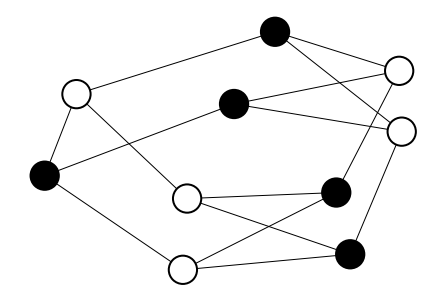

Method,Average,Variance,Best,Approx. Ratio,Cut Dist
Random,7.32,4.42,13.00,0.56,[ -8 -6 -3 -10 -8 -10 -11 -7 -8 -8 -6 -7 -11 -8 -10 -9 -7 -11 -7 -10 -9 -5 -7 -8 -9 -6 -6 -8 -3 -8 -8 -4 -9 -10 -3 -8 -3 -6 -7 -6 -6 -10 -7 -11 -7 -10 -7 -7 -7 -7 -7 -7 -6 -7 -8 -9 -5 -6 -6 -9 -5 -8 -6 -10 -8 -6 -9 -7 -7 -10 -11 -9 -13 -7 -7 -7 -6 -8 -7 -9 -5 -9 -8 -7 -4 -7 -4 -6 -6 -6 -5 -7 -8 -10 -7 -6 -9 -4 0 -7]
Brute force,7.50,3.75,13.00,0.58,[ 0 -3 -3 ... -3 -3 0]
PAOA,10.14,3.44,13.00,0.78,[-10 -7 -13 -10 -10 -13 -9 -7 -12 -13 -10 -9 -13 -10 -10 -10 -12 -10 -12 -8 -11 -10 -13 -10 -13 -10 -10 -11 -12 -4 -11 -9 -10 -7 -11 -11 -13 -10 -11 -13 -10 -11 -10 -9 -11 -12 -13 -8 -9 -9 -10 -11 -9 -9 -13 -9 -6 -9 -10 -9 -11 -9 -9 -10 -12 -9 -10 -10 -6 -9 -11 -11 -12 -10 -11 -9 -7 -13 -12 -9 -10 -11 -8 -9 -12 -12 -10 -12 -12 -6 -9 -12 -6 -12 -10 -10 -10 -10 -11 -7]
Reduced PAOA,11.52,1.53,13.00,0.89,[-11 -12 -10 -12 -11 -12 -10 -12 -12 -11 -12 -11 -12 -12 -10 -11 -10 -10 -12 -12 -10 -11 -12 -12 -13 -11 -13 -13 -11 -12 -13 -13 -12 -10 -12 -13 -12 -13 -9 -13 -10 -12 -12 -12 -12 -12 -12 -12 -12 -12 -10 -12 -12 -10 -8 -12 -13 -13 -11 -11 -12 -12 -11 -12 -13 -12 -10 -12 -13 -13 -13 -10 -13 -10 -9 -11 -11 -13 -13 -12 -10 -12 -13 -11 -9 -10 -11 -8 -12 -10 -12 -12 -11 -12 -12 -8 -13 -13 -12 -13]
Min PAOA (1 layer),11.00,0.00,11.00,1.00,[-11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11]
Min PAOA (3 layers),8.98,5.44,13.00,0.69,[ -8 -9 -7 -10 -3 -7 -9 -7 -9 -7 -13 -7 -7 -12 -7 -8 -12 -8 -6 -7 -9 -12 -12 -7 -7 -8 -8 -8 -6 -11 -11 -11 -10 -10 -11 -8 -6 -11 -12 -6 -11 -8 -6 -12 -10 -7 -11 -9 -12 -6 -8 -11 -9 -13 -10 -12 -10 -6 -10 -10 -13 -12 -6 -10 -5 -9 -10 -9 -9 -9 -10 -7 -12 -12 -13 -6 -12 -10 -9 -12 -10 -9 -6 -7 -8 -13 -9 -8 -7 -9 -7 -6 -9 -8 -13 -6 -6 -9 -3 -12]
QAOA (1 layer),8.14,2.90,12.00,0.68,[ -7 -8 -8 -9 -9 -9 -8 -10 -9 -12 -7 -9 -5 -8 -7 -8 -12 -10 -10 -9 -7 -6 -11 -10 -4 -7 -7 -6 -9 -8 -11 -7 -11 -11 -10 -7 -11 -9 -10 -8 -7 -9 -10 -5 -8 -9 -7 -6 -7 -7 -8 -7 -8 -7 -8 -7 -7 -7 -9 -8 -7 -7 -6 -8 -7 -7 -8 -8 -10 -9 -11 -6 -7 -9 -7 -7 -11 -6 -8 -5 -8 -10 -6 -9 -7 -11 -5 -11 -7 -6 -9 -8 -9 -7 -7 -10 -9 -7 -8 -11]
QAOA (3 layers),8.06,2.22,11.00,0.73,[-11 -11 -6 -5 -10 -7 -8 -9 -7 -7 -8 -9 -8 -9 -7 -8 -7 -10 -7 -9 -7 -8 -7 -7 -7 -10 -10 -7 -7 -7 -8 -9 -9 -9 -6 -8 -8 -8 -9 -8 -9 -7 -10 -7 -9 -7 -7 -6 -11 -10 -7 -8 -7 -9 -7 -5 -9 -9 -9 -7 -6 -7 -7 -7 -11 -6 -7 -9 -8 -11 -7 -7 -7 -8 -10 -10 -7 -7 -11 -6 -11 -6 -9 -8 -10 -7 -7 -7 -10 -6 -7 -7 -10 -9 -11 -7 -9 -9 -8 -7]
QAOA (6 layers),8.14,2.90,12.00,0.68,[-10 -11 -7 -5 -8 -10 -7 -7 -9 -7 -7 -6 -10 -7 -8 -12 -7 -7 -7 -9 -10 -10 -7 -10 -7 -11 -8 -7 -6 -7 -7 -4 -6 -9 -8 -7 -10 -6 -11 -10 -7 -10 -11 -7 -7 -9 -10 -8 -10 -5 -10 -8 -7 -7 -7 -7 -11 -8 -7 -10 -10 -10 -10 -7 -7 -8 -10 -7 -7 -8 -9 -7 -10 -7 -8 -7 -7 -10 -10 -8 -7 -5 -10 -10 -6 -8 -7 -10 -6 -11 -10 -8 -10 -7 -5 -7 -7 -8 -10 -7]


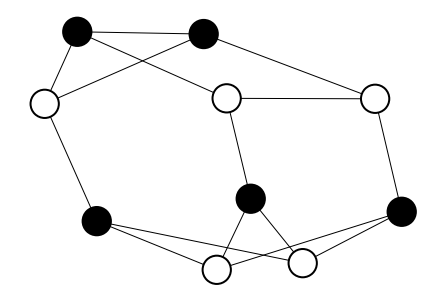

Method,Average,Variance,Best,Approx. Ratio,Cut Dist
Random,7.77,3.42,12.00,0.65,[ -6 -10 -5 -8 -9 -4 -8 -10 -4 -7 -6 -6 -7 -11 -6 -9 -4 -8 -9 -8 -8 -7 -7 -7 -10 -10 -4 -8 -6 -7 -8 -11 -5 -5 -9 -8 -8 -9 -10 -9 -8 -10 -5 -8 -8 -9 -7 -5 -7 -11 -7 -8 -8 -9 -4 -8 -5 -7 -8 -7 -9 -10 -9 -9 -7 -7 -10 -6 -8 -6 -10 -12 -9 -5 -6 -9 -10 -9 -7 -8 -7 -7 -9 -7 -12 -7 -9 -10 -8 -8 -10 -5 -7 -6 -9 -5 -10 -7 -9 -9]
Brute force,7.50,3.75,13.00,0.58,[ 0 -3 -3 ... -3 -3 0]
PAOA,10.48,4.59,13.00,0.81,[ -9 -9 -8 -8 -8 -11 -6 -11 -13 -13 -7 -9 -13 -10 -13 -11 -8 -11 -7 -12 -9 -12 -13 -8 -13 -9 -11 -12 -10 -7 -9 -9 -10 -11 -13 -9 -13 -13 -7 -13 -8 -9 -9 -13 -9 -13 -9 -13 -13 -13 -11 -13 -10 -13 -9 -13 -11 -13 -13 -8 -12 -9 -11 -11 -11 -8 -13 -7 -13 -13 -13 -11 -8 -13 -13 -11 -11 -5 -8 -11 -12 -9 -13 -13 -13 -11 -8 -9 -9 -10 -11 -9 -7 -10 -13 -13 -8 -8 -10 -9]
Reduced PAOA,10.43,2.29,13.00,0.80,[ -6 -11 -6 -9 -12 -10 -12 -13 -12 -12 -11 -10 -9 -12 -9 -13 -10 -12 -10 -9 -10 -12 -11 -9 -6 -10 -13 -9 -9 -11 -13 -9 -13 -12 -10 -9 -9 -10 -9 -10 -13 -11 -12 -10 -10 -8 -10 -10 -10 -11 -13 -12 -10 -10 -11 -11 -12 -10 -12 -9 -9 -10 -9 -11 -12 -10 -10 -12 -10 -12 -10 -10 -9 -13 -10 -7 -10 -9 -11 -12 -10 -10 -11 -9 -10 -11 -9 -12 -11 -11 -12 -11 -9 -10 -11 -11 -9 -11 -12 -10]
Min PAOA (1 layer),10.63,2.77,13.00,0.82,[-11 -10 -13 -10 -10 -8 -9 -10 -10 -9 -11 -10 -10 -13 -10 -10 -11 -12 -12 -10 -9 -13 -10 -9 -7 -9 -6 -12 -12 -12 -12 -12 -9 -11 -13 -11 -10 -12 -10 -10 -9 -8 -8 -13 -12 -12 -11 -9 -12 -10 -10 -12 -13 -10 -9 -13 -11 -12 -9 -13 -13 -10 -9 -9 -13 -12 -12 -9 -10 -10 -11 -11 -9 -9 -13 -10 -11 -9 -12 -13 -11 -12 -10 -12 -6 -10 -12 -9 -13 -10 -9 -13 -10 -12 -10 -7 -11 -11 -13 -13]
Min PAOA (3 layers),10.43,3.63,13.00,0.80,[ -9 -12 -10 -13 -9 -10 -13 -13 -11 -13 -10 -12 -13 -10 -12 -13 -13 -10 -6 -12 -9 -12 -13 -13 -12 -10 -12 -9 -8 -10 -13 -6 -8 -11 -9 -13 -10 -11 -10 -10 -6 -7 -7 -8 -9 -9 -13 -12 -13 -9 -10 -11 -6 -13 -10 -8 -10 -10 -9 -11 -10 -12 -12 -12 -11 -8 -13 -9 -10 -8 -10 -12 -9 -9 -13 -12 -12 -11 -12 -13 -9 -11 -9 -10 -13 -9 -9 -9 -9 -13 -10 -7 -10 -10 -10 -10 -10 -12 -12 -9]
QAOA (1 layer),8.82,5.37,13.00,0.68,[ -7 -7 -8 -10 -9 -13 -13 -10 -11 -7 -5 -6 -9 -6 -6 -13 -13 -9 -10 -11 -6 -10 -9 -6 -9 -7 -6 -10 -7 -12 -13 -7 -6 -8 -12 -7 -5 -10 -6 -8 -10 -11 -9 -9 -7 -8 -12 -7 -11 -6 -13 -7 -4 -9 -10 -8 -6 -11 -12 -9 -9 -7 -7 -7 -7 -11 -6 -9 -8 -9 -8 -11 -9 -7 -10 -4 -10 -9 -8 -8 -11 -13 -9 -11 -9 -9 -13 -8 -9 -7 -9 -9 -7 -13 -10 -12 -4 -9 -7 -13]
QAOA (3 layers),9.82,3.99,13.00,0.76,[-13 -9 -13 -12 -9 -10 -10 -7 -7 -11 -13 -9 -9 -13 -9 -9 -13 -13 -9 -9 -13 -9 -12 -9 -8 -7 -12 -8 -9 -11 -13 -9 -9 -8 -8 -13 -13 -8 -10 -13 -8 -9 -9 -13 -9 -6 -10 -9 -9 -11 -9 -12 -9 -10 -8 -5 -10 -12 -7 -10 -6 -9 -13 -8 -9 -13 -8 -13 -13 -10 -9 -11 -10 -9 -7 -12 -7 -9 -9 -10 -11 -13 -9 -10 -10 -9 -8 -9 -13 -10 -12 -8 -7 -10 -10 -9 -8 -7 -10 -10]
QAOA (6 layers),9.32,6.08,13.00,0.72,[-13 -11 -8 -10 -9 -13 -12 -6 -8 -6 -9 -11 -12 -10 -10 -10 -13 -12 -7 -13 -9 -9 -9 -13 -5 -7 -9 -13 -11 -9 -6 -13 -13 -8 -10 -8 -8 -6 -9 -10 -13 -10 -3 -7 -8 -12 -9 -6 -7 -5 -10 -13 -9 -13 -9 -13 -7 -7 -13 -7 -8 -9 -9 -9 -8 -10 -8 -9 -7 -12 -11 -6 -6 -13 -9 -6 -13 -13 -9 -11 -12 -7 -6 -8 -10 -8 -9 -9 -7 -7 -11 -6 -13 -6 -6 -10 -13 -8 -9 -12]


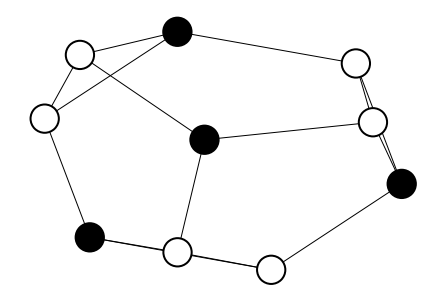

Method,Average,Variance,Best,Approx. Ratio,Cut Dist
Random,7.38,3.34,11.00,0.67,[ -9 -11 -6 -7 -7 -9 -4 -5 -5 -5 -6 -6 -7 -7 -6 -8 -9 -10 -6 -9 -9 -8 -9 -11 -7 -9 -7 -5 -9 -8 -8 -8 -8 -5 -9 -7 -6 -6 -8 -7 -11 -8 -8 -4 -6 -7 -9 -7 -7 -11 -5 -10 -8 -8 -8 -9 -7 -10 -7 -7 -6 -7 -6 -5 -4 -5 -6 -10 -7 -3 -10 -9 -6 -9 -7 -9 -8 -6 -7 -7 -7 -7 -6 -10 -9 -6 -5 -11 -6 -5 -10 -7 -3 -8 -10 -7 -9 -8 -8 -6]
Brute force,7.50,3.75,12.00,0.62,[ 0 -3 -3 ... -3 -3 0]
PAOA,10.06,0.96,11.00,0.91,[-10 -11 -11 -9 -10 -10 -11 -9 -11 -10 -10 -10 -11 -11 -10 -9 -10 -11 -10 -10 -10 -11 -9 -11 -11 -8 -10 -10 -11 -9 -11 -10 -11 -11 -11 -11 -8 -7 -9 -10 -10 -10 -11 -10 -11 -11 -11 -9 -11 -11 -11 -10 -10 -11 -8 -10 -11 -10 -10 -10 -11 -9 -9 -10 -10 -10 -10 -11 -9 -9 -11 -10 -9 -10 -10 -11 -9 -11 -11 -9 -10 -11 -7 -11 -11 -9 -10 -10 -11 -11 -10 -9 -9 -11 -10 -11 -11 -10 -9 -7]
Reduced PAOA,9.56,0.77,11.00,0.87,[-10 -8 -10 -10 -9 -9 -10 -10 -11 -8 -9 -9 -10 -8 -9 -9 -9 -10 -10 -10 -11 -10 -9 -8 -8 -9 -9 -9 -10 -10 -9 -10 -10 -10 -8 -10 -10 -7 -11 -8 -10 -10 -10 -10 -8 -9 -10 -10 -9 -9 -9 -9 -10 -8 -10 -11 -10 -9 -10 -9 -11 -10 -10 -9 -9 -11 -9 -9 -9 -9 -10 -10 -9 -10 -8 -9 -9 -10 -11 -10 -11 -9 -10 -11 -10 -9 -10 -10 -9 -10 -11 -11 -11 -10 -9 -10 -11 -9 -9 -10]
Min PAOA (1 layer),10.00,1.16,12.00,0.83,[-12 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -12 -11 -11 -11 -11 -11 -11 -11 -8 -8 -11 -10 -9 -9 -9 -9 -9 -9 -9 -10 -9 -10 -10 -10 -10 -9 -11 -11 -11 -11 -11 -11 -9 -9 -11 -11 -10 -11 -11 -11 -11 -11 -11 -11 -11 -10 -9 -9 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -9 -10 -10 -10 -10 -9 -9 -9 -9 -9 -8 -6 -8 -10 -9 -6 -9 -10 -10 -10 -10 -10 -10 -9 -10 -9 -9]
Min PAOA (3 layers),8.64,2.91,12.00,0.72,[ -9 -7 -9 -10 -7 -9 -8 -11 -6 -8 -10 -8 -6 -7 -10 -11 -7 -11 -6 -7 -9 -9 -9 -10 -8 -9 -9 -9 -10 -9 -10 -10 -8 -5 -12 -10 -12 -11 -6 -9 -11 -10 -11 -6 -10 -7 -10 -9 -7 -7 -8 -7 -7 -8 -9 -9 -8 -11 -6 -8 -5 -8 -9 -8 -11 -11 -9 -6 -8 -8 -10 -9 -9 -7 -5 -11 -9 -8 -10 -8 -9 -9 -5 -8 -10 -10 -10 -5 -11 -10 -9 -8 -7 -9 -11 -10 -11 -7 -7 -9]
QAOA (1 layer),8.76,2.98,11.00,0.80,[ -9 -11 -8 -9 -10 -11 -6 -8 -9 -10 -11 -9 -7 -9 -4 -7 -10 -6 -9 -10 -9 -11 -10 -9 -8 -11 -9 -6 -9 -9 -4 -7 -10 -10 -9 -9 -7 -8 -11 -9 -11 -9 -9 -10 -7 -8 -8 -9 -7 -8 -9 -6 -9 -11 -10 -11 -8 -10 -11 -11 -9 -9 -9 -9 -10 -7 -9 -9 -11 -5 -11 -11 -8 -4 -9 -9 -9 -10 -8 -4 -10 -9 -9 -8 -9 -11 -9 -8 -9 -5 -11 -9 -9 -9 -6 -10 -7 -9 -11 -8]
QAOA (3 layers),8.71,2.89,11.00,0.79,[-11 -10 -7 -6 -9 -7 -7 -9 -9 -8 -11 -11 -10 -9 -11 -7 -9 -11 -5 -9 -9 -7 -9 -11 -8 -10 -11 -8 -9 -8 -7 -8 -8 -9 -7 -9 -9 -8 -9 -11 -9 -8 -11 -9 -11 -5 -9 -4 -9 -9 -4 -9 -9 -11 -8 -11 -9 -8 -7 -8 -11 -11 -9 -9 -7 -8 -8 -11 -9 -7 -9 -9 -8 -8 -7 -8 -7 -10 -8 -6 -11 -8 -11 -11 -11 -8 -11 -11 -8 -8 -7 -11 -10 -8 -8 -9 -5 -6 -11 -9]
QAOA (6 layers),8.34,2.84,11.00,0.76,[ -7 -7 -6 -8 -7 -8 -10 -9 -9 -10 -9 -8 -9 -6 -9 -5 -9 -7 -9 -8 -11 -10 -9 -7 -11 -9 -7 -8 -8 -10 -6 -8 -6 -8 -9 -10 -11 0 -9 -8 -11 -10 -9 -9 -11 -11 -8 -8 -8 -5 -11 -7 -9 -10 -6 -9 -8 -9 -10 -10 -8 -8 -10 -8 -9 -8 -8 -8 -9 -8 -6 -11 -8 -8 -10 -7 -6 -10 -9 -7 -8 -8 -10 -8 -7 -8 -11 -9 -9 -8 -7 -8 -6 -6 -7 -8 -7 -9 -9 -11]


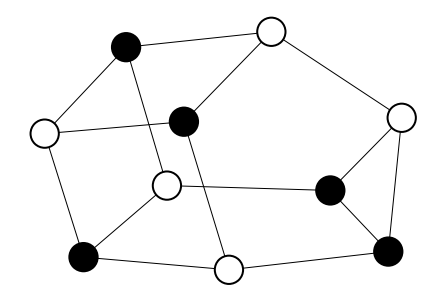

Method,Average,Variance,Best,Approx. Ratio,Cut Dist
Random,7.62,4.34,13.00,0.59,[ -7 -10 -12 -7 -10 -9 -10 -9 -7 -9 -9 -6 -8 -11 -7 -7 -6 -7 -9 -8 -13 -4 -7 -8 -7 -7 -7 -5 -8 -5 -3 -7 -9 -7 -12 -9 -8 -6 -7 -5 -4 -5 -8 -8 -8 -9 -7 -8 -8 -12 -5 -7 -9 -11 -9 -7 -9 -4 -9 -7 -4 -6 -7 -7 -10 -10 -5 -6 -7 -7 -6 -7 -7 -6 -7 -9 -10 -7 -9 -9 -12 -10 -9 -6 -10 -9 -10 -7 -7 -8 -6 -11 -3 -6 -6 -7 -9 -6 -5 -3]
Brute force,7.50,3.75,13.00,0.58,[ 0 -3 -3 ... -3 -3 0]
PAOA,10.41,2.50,13.00,0.80,[ -9 -10 -11 -11 -11 -8 -13 -8 -11 -11 -12 -11 -11 -8 -10 -9 -10 -8 -12 -10 -12 -10 -11 -13 -10 -10 -12 -11 -11 -12 -9 -10 -8 -13 -9 -9 -8 -9 -12 -11 -10 -10 -12 -10 -9 -8 -11 -10 -13 -9 -13 -10 -10 -11 -11 -4 -11 -10 -9 -12 -11 -12 -10 -12 -12 -9 -10 -9 -9 -12 -12 -12 -12 -7 -12 -10 -11 -10 -9 -12 -11 -11 -11 -11 -11 -9 -10 -12 -10 -12 -8 -12 -11 -12 -10 -7 -12 -9 -9 -13]
Reduced PAOA,9.57,2.31,13.00,0.74,[-10 -9 -13 -12 -8 -10 -9 -8 -9 -8 -8 -9 -9 -8 -7 -8 -9 -10 -8 -11 -7 -10 -9 -10 -10 -8 -11 -10 -8 -9 -9 -9 -11 -9 -13 -9 -9 -9 -10 -11 -13 -10 -10 -11 -8 -7 -9 -13 -9 -10 -8 -8 -9 -12 -8 -11 -9 -10 -9 -13 -5 -11 -9 -10 -8 -9 -9 -13 -9 -8 -8 -10 -10 -9 -10 -10 -11 -9 -11 -10 -10 -10 -10 -11 -9 -8 -9 -13 -11 -9 -9 -13 -9 -9 -10 -8 -9 -9 -10 -11]
Min PAOA (1 layer),13.00,0.00,13.00,1.00,[-13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13]
Min PAOA (3 layers),8.13,1.51,13.00,0.63,[ -8 -7 -8 -10 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -6 -8 -8 -8 -13 -8 -8 -7 -8 -8 -8 -8 -7 -8 -7 -8 -8 -8 -10 -8 -8 -9 -7 -11 -10 -10 -9 -6 -8 -6 -8 -9 -8 -7 -8 -8 -9 -8 -8 -7 -10 -10 -5 -8 -8 -8 -11 -10 -5 -8 -10 -8 -8 -7 -8 -7 -7 -9 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -6 -8 -6 -8 -7 -8 -8 -12 -8 -10 -10]
QAOA (1 layer),8.22,3.19,13.00,0.63,[ -7 -8 -10 -7 -7 -6 -8 -8 -8 -7 -10 -11 -8 -9 -7 -11 -9 -4 -9 -9 -7 -9 -9 -8 -9 -7 -5 -11 -7 -9 -9 -10 -9 -9 -10 -7 -7 -7 -10 -10 -7 -8 -13 -8 -7 -7 -7 -9 -10 -10 -8 -7 -11 -8 -7 -6 -3 -5 -10 -7 -9 -9 -11 -9 -10 -11 -9 -8 -7 -7 -7 -8 -9 -9 -10 -5 -8 -6 -11 -7 -7 -7 -9 -8 -8 -5 -7 -4 -8 -10 -9 -10 -9 -7 -9 -10 -11 -5 -11 -8]
QAOA (3 layers),8.08,3.61,11.00,0.73,[ -6 -4 -7 -11 -8 -8 -7 -10 -8 -5 -9 -9 -7 -10 -9 -7 -6 -7 -5 -9 -10 -7 -11 -8 -10 -6 -11 -9 -9 -8 -9 -7 -6 -5 -9 -9 -4 -8 -8 -8 -11 -8 -9 -9 -10 -11 -9 -9 -9 -8 -8 -9 -6 -8 -8 -8 -8 -7 -7 -11 -9 -4 -7 -3 -11 -9 -9 -8 -6 -8 -5 -8 -5 -4 -11 -11 -8 -11 -8 -6 -10 -8 -9 -11 -6 -8 -11 -9 -8 -7 -6 -7 -11 -8 -11 -9 -8 -10 -7 -6]
QAOA (6 layers),8.10,3.19,12.00,0.67,[ -8 -6 -9 -6 -8 -9 -8 -10 -8 -10 -4 -7 -8 -12 -9 -8 -7 -8 -7 -10 -8 -9 -9 -9 -9 -8 -5 -5 -8 -6 -8 -10 -7 -8 -11 -11 -7 -8 -8 -6 -8 -9 -8 -9 -7 -9 -5 -10 -10 -10 -8 -11 -7 -8 -7 -11 -7 -5 -5 -10 -7 -7 -5 -6 -8 -8 -11 -10 -8 -10 -8 -7 -10 -10 -5 -5 -7 -6 -9 -8 -9 -7 -10 -12 -11 -10 -7 -7 -10 -4 -9 -7 -9 -8 -8 -9 -11 -8 -6 -7]


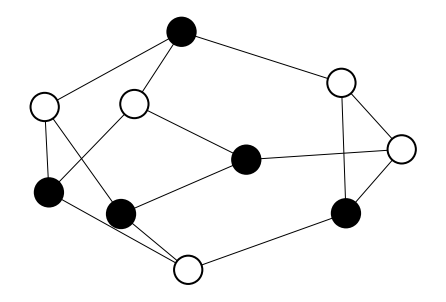

Method,Average,Variance,Best,Approx. Ratio,Cut Dist
Random,7.68,3.86,13.00,0.59,[ -6 -7 -8 -9 -9 -7 -12 -7 -8 -9 -10 -8 -7 -6 -7 -7 -7 -8 -7 -10 -9 -6 -6 -6 -12 -8 -9 -10 -8 -7 -5 -6 -8 -5 -10 -10 -6 -7 -5 -7 -5 -13 -10 -7 -10 -9 -10 -10 -9 -3 -4 -5 -5 -10 -8 -8 -7 -7 -10 -7 -10 -6 -10 -10 -9 -6 -7 -7 -3 -8 -6 -8 -8 -9 -8 -9 -8 -6 -3 -6 -6 -8 -9 -9 -9 -8 -4 -8 -10 -9 -11 -8 -7 -7 -5 -5 -8 -6 -9 -9]
Brute force,7.50,3.75,13.00,0.58,[ 0 -3 -3 ... -3 -3 0]
PAOA,10.86,2.98,13.00,0.84,[ -8 -10 -9 -7 -11 -10 -10 -9 -11 -9 -13 -11 -9 -11 -11 -12 -13 -11 -10 -8 -10 -13 -11 -12 -10 -11 -12 -8 -9 -10 -12 -13 -7 -12 -11 -12 -12 -11 -13 -9 -10 -13 -11 -13 -12 -11 -11 -13 -13 -11 -12 -13 -10 -13 -12 -13 -13 -12 -12 -13 -9 -9 -9 -11 -8 -11 -13 -10 -8 -12 -10 -12 -12 -12 -9 -10 -10 -11 -13 -10 -8 -13 -12 -11 -9 -12 -13 -11 -13 -13 -9 -13 -10 -12 -10 -5 -10 -11 -8 -12]
Reduced PAOA,10.49,1.73,13.00,0.81,[-11 -11 -10 -12 -8 -12 -12 -7 -11 -10 -10 -10 -8 -13 -11 -9 -10 -11 -11 -11 -11 -10 -12 -12 -11 -9 -12 -7 -10 -10 -11 -13 -10 -10 -8 -12 -11 -11 -11 -11 -13 -10 -11 -12 -11 -10 -13 -10 -11 -12 -11 -11 -12 -10 -11 -10 -7 -7 -9 -11 -10 -11 -12 -10 -13 -10 -10 -9 -12 -10 -11 -11 -11 -9 -10 -11 -10 -10 -11 -11 -10 -11 -10 -11 -10 -11 -11 -11 -10 -10 -7 -11 -11 -10 -11 -8 -11 -11 -10 -10]
Min PAOA (1 layer),11.00,0.00,11.00,1.00,[-11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11]
Min PAOA (3 layers),7.89,3.36,12.00,0.66,[ -6 -4 -7 -7 -8 -7 -9 -11 -8 -12 -9 -6 -7 -8 -11 -7 -6 -11 -6 -9 -7 -6 -8 -7 -10 -7 -9 -8 -10 -6 -9 -6 -7 -8 -10 -9 -6 -12 -8 -7 -11 -9 -4 -10 -4 -8 -7 -10 -4 -9 -8 -9 -5 -8 -5 -5 -10 -9 -7 -10 -7 -7 -8 -11 -7 -10 -7 -6 -8 -6 -8 -8 -7 -8 -7 -8 -8 -5 -9 -8 -10 -7 -10 -8 -5 -6 -7 -8 -6 -7 -9 -7 -7 -11 -10 -9 -8 -11 -9 -10]
QAOA (1 layer),8.92,3.89,13.00,0.69,[ -6 -9 -11 -8 -8 -9 -8 -5 -8 -5 -9 -13 -6 -7 -9 -7 -7 -8 -9 -10 -9 -8 -7 -8 -7 -9 -8 -13 -7 -11 -8 -12 -12 -8 -11 -11 -9 -13 -10 -7 -9 -8 -12 -9 -9 -6 -12 -10 -9 -8 -7 -7 -8 -12 -9 -8 -6 -12 -9 -10 -9 -9 -9 -7 -9 -12 -8 -7 -10 -12 -9 -9 -8 -5 -13 -6 -9 -8 -8 -8 -9 -7 -7 -10 -8 -11 -8 -9 -10 -6 -12 -7 -13 -13 -8 -9 -10 -10 -11 -9]
QAOA (3 layers),10.35,5.51,13.00,0.80,[-13 -12 -7 -7 -7 -9 -9 -13 -12 -7 -8 -9 -10 -7 -12 -13 -7 -13 -6 -10 -13 -13 -13 -13 -11 -7 -8 -6 -11 -13 -12 -8 -10 -8 -9 -10 -12 -11 -12 -10 -11 -12 -9 -9 -13 -7 -11 -9 -13 -8 -11 -13 -7 -13 -13 -10 -8 -10 -13 -13 -9 -7 -11 -9 -9 -10 -13 -6 -12 -13 -13 -10 -12 -10 -11 -13 -13 -8 -7 -12 -12 -6 -12 -13 -12 -12 -12 -7 -13 -7 -13 -11 -7 -13 -9 -13 -13 -13 -7 -8]
QAOA (6 layers),9.86,5.64,13.00,0.76,[-12 -13 -13 -11 -7 -8 -7 -12 -9 -11 -13 -12 -7 -10 -7 -9 -7 -7 -12 -8 -12 -13 -9 -12 -10 -7 -12 -9 -9 -13 -9 -13 -11 -10 -10 -9 -8 -9 -9 -10 -12 -8 -7 -13 -13 -13 -10 -12 -9 -10 -12 -13 -7 -6 -13 -5 -8 -13 -9 -13 -9 -12 -12 -7 -12 -9 -12 -7 -13 -13 -10 -13 -6 -12 -9 -11 -7 -12 -13 -5 -11 -7 -7 -9 -7 -13 -7 -13 -10 -12 -6 -9 -8 -11 -5 -8 -9 -9 -8 -8]


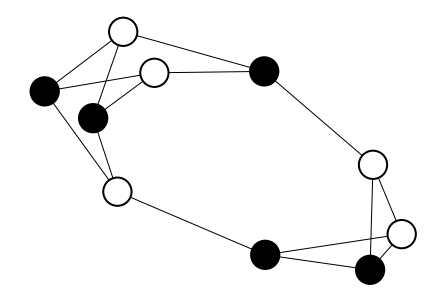

Method,Average,Variance,Best,Approx. Ratio,Cut Dist
Random,7.45,3.57,12.00,0.62,[ -7 -11 -5 -8 -8 -5 -9 -4 -7 -9 -9 -7 -9 -4 -9 -8 -9 -9 -3 -8 -9 -6 -7 -8 -5 -7 -9 -9 -7 -7 -5 -7 -9 -7 -8 -9 -8 -5 -7 -7 -8 -8 -7 -8 -9 -7 -9 -7 -7 -10 -10 -6 -9 -9 -7 -8 -6 -5 -12 -7 -6 -11 -9 -7 -10 -8 -8 -8 -5 -9 -9 -10 -5 -7 -6 -8 -6 -9 -7 -4 -4 -7 -5 -10 -8 -7 -7 -4 -9 -8 -5 -8 -7 -9 -12 -8 -3 -9 -3 -7]
Brute force,7.50,3.75,13.00,0.58,[ 0 -3 -3 ... -3 -3 0]
PAOA,10.82,2.95,13.00,0.83,[-11 -11 -10 -13 -12 -12 -13 -8 -7 -9 -9 -11 -9 -11 -12 -9 -11 -11 -10 -10 -11 -9 -12 -13 -13 -12 -10 -9 -13 -9 -10 -12 -9 -9 -10 -13 -12 -9 -10 -10 -9 -12 -13 -12 -12 -11 -13 -11 -10 -8 -10 -13 -13 -12 -11 -12 -7 -9 -12 -13 -13 -10 -9 -13 -12 -11 -12 -13 -13 -9 -11 -12 -8 -9 -9 -11 -7 -9 -12 -10 -13 -13 -10 -8 -8 -10 -10 -10 -8 -11 -13 -13 -11 -13 -10 -10 -13 -13 -13 -12]
Reduced PAOA,10.48,3.43,13.00,0.81,[-13 -12 -10 -9 -13 -10 -12 -12 -10 -12 -9 -11 -11 -6 -10 -12 -9 -11 -12 -8 -10 -9 -11 -12 -9 -13 -10 -12 -12 -9 -10 -13 -13 -8 -9 -13 -12 -13 -10 -8 -13 -9 -9 -12 -8 -12 -11 -6 -13 -10 -9 -13 -9 -9 -10 -8 -13 -10 -13 -9 -9 -10 -10 -13 -12 -13 -9 -9 -12 -9 -8 -11 -11 -9 -8 -9 -9 -8 -13 -12 -12 -7 -13 -9 -8 -12 -13 -10 -12 -12 -10 -10 -8 -8 -9 -9 -13 -13 -12 -10]
Min PAOA (1 layer),12.00,0.00,12.00,1.00,[-12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12]
Min PAOA (3 layers),8.49,0.91,11.00,0.77,[ -9 -8 -8 -8 -8 -9 -9 -8 -8 -8 -8 -9 -9 -8 -8 -9 -10 -7 -8 -9 -9 -9 -8 -7 -9 -8 -8 -7 -8 -9 -7 -9 -9 -9 -10 -11 -8 -8 -8 -11 -9 -10 -8 -9 -9 -10 -8 -10 -9 -8 -8 -9 -9 -9 -7 -8 -8 -8 -8 -8 -9 -9 -7 -7 -8 -8 -10 -8 -10 -9 -11 -9 -8 -8 -8 -8 -7 -8 -8 -7 -10 -8 -9 -7 -8 -10 -7 -7 -7 -8 -9 -9 -8 -10 -10 -9 -8 -9 -8 -9]
QAOA (1 layer),8.73,3.66,13.00,0.67,[-13 -6 -6 -9 -8 -10 -13 -9 -6 -7 -7 -9 -11 -9 -9 -7 -7 -8 -9 -6 -8 -9 -11 -9 -6 -7 -9 -9 -10 -12 -10 -13 -6 -8 -7 -9 -10 -7 -9 -7 -8 -13 -8 -8 -9 -9 -9 -7 -9 -7 -10 -8 -8 -12 -9 -9 -9 -7 -5 -8 -8 -13 -9 -4 -9 -11 -9 -9 -8 -9 -9 -6 -9 -8 -11 -8 -6 -8 -9 -10 -8 -8 -9 -13 -13 -9 -9 -13 -12 -9 -9 -10 -8 -8 -8 -7 -9 -7 -8 -6]
QAOA (3 layers),9.24,4.80,13.00,0.71,[-10 -13 -13 -12 -10 -10 -9 -8 -9 -12 -8 -12 -8 -8 -12 -6 -9 -11 -9 -6 -11 -9 -7 -9 -8 -9 -8 -9 -9 -7 -7 -12 -9 -9 -9 -7 -10 -6 -8 -9 -9 -9 -10 -9 -8 -8 -8 -13 -9 -8 -9 -10 -8 -6 -9 -8 -9 -12 -9 -12 -13 -13 -8 -8 -10 -10 -9 -9 -13 -10 -9 -6 -9 -7 -9 -8 -9 -13 -8 -10 -8 -7 -12 -9 -9 -13 -9 -13 -12 -13 -9 -8 -9 -5 -13 -5 -2 -4 -13 -10]
QAOA (6 layers),9.58,3.50,13.00,0.74,[ -9 -8 -9 -7 -10 -8 -12 -8 -9 -13 -8 -8 -10 -9 -10 -11 -12 -13 -9 -9 -10 -13 -8 -8 -9 -8 -5 -10 -13 -9 -10 -9 -8 -13 -9 -8 -8 -13 -10 -9 -10 -9 -9 -9 -8 -9 -9 -8 -13 -9 -9 -9 -8 -9 -9 -9 -9 -13 -7 -8 -10 -9 -10 -12 -10 -10 -9 -10 -7 -12 -10 -13 -10 -8 -13 -13 -7 -8 -12 -12 -7 -8 -10 -13 -9 -10 -10 -13 -9 -12 -6 -10 -7 -9 -13 -7 -8 -10 -9 -8]


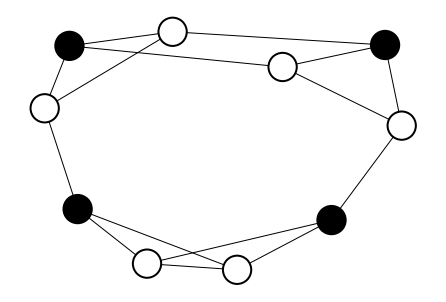

Method,Average,Variance,Best,Approx. Ratio,Cut Dist
Random,7.97,2.91,12.00,0.66,[ -8 -10 -9 -7 -6 -8 -7 -6 -6 -7 -6 -11 -9 -6 -6 -9 -8 -6 -11 -6 -8 -9 -10 -10 -10 -8 -10 -7 -9 -10 -9 -7 -9 -7 -9 -8 -10 -8 -7 -7 -10 -9 -6 -7 -6 -8 -7 -8 -9 -6 -6 -8 -8 -9 -4 -8 -12 -6 -8 -9 -10 -5 -7 -9 -11 -8 -7 -9 -10 -9 -7 -9 -8 -9 -11 -6 -5 -6 -9 -6 -8 -8 -6 -8 -11 -9 -7 -9 -9 -10 -5 -7 -10 -9 -8 -8 -7 -10 -6 -3]
Brute force,7.50,3.75,12.00,0.62,[ 0 -3 -3 ... -3 -3 0]
PAOA,10.27,1.26,12.00,0.86,[-11 -11 -11 -11 -11 -11 -10 -11 -11 -11 -11 -11 -8 -9 -11 -10 -12 -10 -11 -10 -9 -11 -11 -8 -10 -11 -9 -10 -11 -8 -11 -11 -11 -11 -11 -9 -9 -10 -10 -11 -9 -10 -11 -11 -12 -10 -11 -11 -11 -11 -11 -7 -11 -11 -11 -11 -11 -11 -11 -10 -12 -11 -8 -8 -9 -9 -11 -11 -11 -11 -10 -11 -9 -8 -11 -11 -8 -11 -11 -11 -11 -10 -10 -10 -9 -11 -10 -11 -11 -8 -10 -11 -11 -9 -8 -11 -11 -10 -7 -10]
Reduced PAOA,9.88,1.89,12.00,0.82,[ -9 -10 -12 -11 -9 -9 -9 -10 -10 -11 -11 -10 -8 -9 -9 -12 -9 -11 -9 -10 -10 -7 -11 -8 -11 -9 -10 -10 -12 -8 -9 -9 -11 -8 -10 -11 -7 -11 -10 -10 -10 -11 -11 -11 -11 -12 -11 -10 -7 -11 -12 -8 -8 -10 -8 -11 -9 -9 -11 -10 -11 -11 -9 -9 -10 -8 -9 -11 -10 -11 -10 -12 -12 -9 -11 -10 -12 -9 -9 -7 -10 -10 -9 -11 -8 -10 -10 -12 -10 -7 -8 -11 -7 -11 -9 -8 -12 -11 -11 -12]
Min PAOA (1 layer),10.87,0.19,11.00,0.99,[ -9 -10 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -9 -10 -11 -11 -11 -11 -11 -10 -11 -11 -11 -11 -11 -11 -9 -10 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -9 -10 -11 -11 -11]
Min PAOA (3 layers),7.93,1.71,11.00,0.72,[ -9 -9 -7 -7 -9 -8 -8 -9 -8 -5 -7 -7 -9 -9 -10 -8 -9 -7 -9 -8 -8 -7 -7 -7 -6 -8 -7 -8 -6 -8 -7 -9 -7 -9 -8 -7 -9 -10 -10 -7 -7 -9 -8 -8 -10 -7 -8 -9 -9 -6 -7 -7 -5 -7 -8 -10 -9 -7 -8 -11 -6 -7 -7 -8 -7 -9 -9 -11 -7 -7 -9 -10 -7 -7 -10 -7 -6 -7 -9 -9 -6 -6 -7 -9 -6 -6 -7 -10 -8 -8 -10 -9 -8 -9 -8 -10 -8 -9 -7 -6]
QAOA (1 layer),9.16,2.95,12.00,0.76,[ -4 -12 -10 -11 -8 -8 -9 -10 -7 -9 -8 -10 -9 -11 -8 -11 -9 -10 -7 -11 -8 -12 -8 -8 -10 -10 -9 -10 -8 -11 -10 -12 -11 -8 -8 -7 -10 -9 -8 -11 -11 -11 -7 -4 -11 -11 -9 -9 -6 -9 -5 -11 -7 -10 -11 -8 -11 -11 -11 -8 -11 -9 -7 -11 -8 -11 -5 -11 -10 -6 -11 -9 -9 -8 -7 -9 -9 -8 -8 -8 -9 -9 -10 -9 -9 -8 -10 -12 -10 -10 -9 -9 -8 -10 -10 -9 -7 -11 -10 -11]
QAOA (3 layers),9.48,2.29,12.00,0.79,[-11 -11 -7 -8 -9 -7 -9 -12 -10 -8 -10 -7 -12 -8 -11 -9 -11 -11 -7 -7 -11 -8 -9 -8 -8 -8 -9 -12 -10 -11 -8 -10 -10 -11 -10 -9 -11 -11 -10 -10 -8 -11 -12 -9 -9 -8 -10 -9 -7 -8 -11 -10 -9 -10 -8 -11 -9 -10 -7 -9 -11 -9 -10 -11 -8 -9 -8 -10 -8 -12 -11 -9 -12 -5 -11 -11 -11 -11 -10 -11 -12 -11 -9 -9 -11 -8 -9 -11 -12 -10 -8 -8 -9 -7 -8 -8 -9 -9 -9 -9]
QAOA (6 layers),8.36,3.57,12.00,0.70,[ -8 -11 -9 -9 -9 -8 -10 -4 -6 -9 -9 -8 -8 -7 -9 -12 -7 -8 -12 -9 -11 -3 -9 -10 -11 -10 -8 -7 -5 -8 -7 -9 -7 -7 -10 -8 -6 -6 -7 -7 -10 -6 -9 -10 -8 -11 -7 -7 -10 -8 -8 -8 -11 -7 -9 -8 -11 -9 -8 -3 -8 -6 -9 -10 -8 -11 -6 -11 -9 -12 -8 -10 -11 -8 -6 -10 -9 -7 -9 -5 -11 -7 -7 -8 -7 -8 -10 -10 -7 -4 -10 -8 -10 -8 -9 -10 -7 -7 -11 -8]


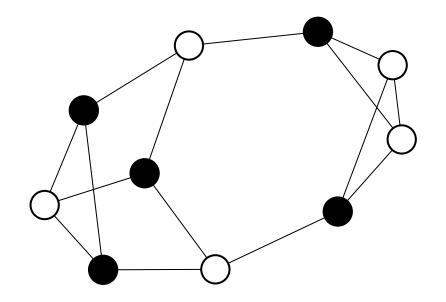

Method,Average,Variance,Best,Approx. Ratio,Cut Dist
Random,7.99,3.11,11.00,0.73,[ -8 -6 -4 -4 -8 -8 -6 -10 -8 -8 -11 -7 -11 -8 -10 -8 -11 -8 -9 -9 -6 -8 -10 -6 -10 -6 -7 -9 -7 -4 -7 -11 -10 -8 -10 -7 -7 -7 -11 -6 -7 -7 -3 -6 -8 -11 -10 -8 -6 -8 -8 -10 -10 -9 -10 -8 -5 -9 -8 -7 -8 -8 -11 -6 -7 -9 -4 -6 -8 -8 -9 -10 -7 -7 -7 -9 -9 -9 -5 -10 -8 -6 -7 -8 -8 -9 -8 -9 -9 -9 -10 -7 -8 -7 -6 -9 -9 -10 -10 -8]
Brute force,7.50,3.75,13.00,0.58,[ 0 -3 -3 ... -3 -3 0]
PAOA,10.44,3.43,13.00,0.80,[-13 -12 -13 -9 -11 -12 -9 -9 -8 -9 -13 -10 -13 -9 -10 -13 -12 -10 -13 -13 -10 -8 -13 -13 -7 -10 -12 -12 -9 -13 -8 -9 -8 -13 -10 -13 -9 -11 -8 -13 -10 -13 -9 -12 -12 -12 -12 -12 -13 -10 -10 -12 -10 -8 -8 -10 -12 -13 -10 -8 -13 -10 -12 -12 -9 -12 -9 -12 -8 -9 -9 -8 -9 -8 -12 -12 -9 -11 -12 -10 -9 -5 -9 -7 -10 -12 -11 -12 -10 -9 -10 -10 -9 -11 -11 -10 -9 -12 -8 -8]
Reduced PAOA,9.55,1.09,12.00,0.80,[-11 -9 -9 -12 -9 -9 -10 -7 -10 -11 -9 -10 -9 -9 -10 -9 -11 -11 -10 -8 -11 -9 -11 -10 -10 -8 -8 -10 -8 -9 -9 -10 -10 -10 -9 -11 -10 -11 -9 -8 -11 -9 -9 -10 -11 -11 -9 -10 -9 -8 -10 -11 -10 -9 -10 -9 -11 -10 -11 -11 -10 -8 -10 -9 -7 -7 -10 -11 -9 -11 -11 -9 -10 -7 -10 -9 -9 -11 -9 -9 -10 -9 -9 -9 -9 -9 -10 -9 -9 -10 -10 -10 -9 -9 -10 -9 -8 -9 -10 -9]
Min PAOA (1 layer),10.19,1.73,13.00,0.78,[ -9 -9 -9 -11 -11 -11 -8 -10 -10 -11 -10 -11 -9 -13 -12 -11 -11 -13 -9 -11 -12 -10 -12 -9 -11 -9 -10 -11 -11 -9 -9 -10 -10 -7 -8 -9 -9 -10 -12 -7 -11 -11 -12 -10 -11 -8 -10 -12 -9 -10 -12 -12 -12 -9 -11 -10 -11 -11 -10 -11 -10 -11 -10 -11 -10 -10 -11 -11 -11 -11 -9 -9 -12 -12 -9 -8 -9 -8 -10 -8 -10 -11 -10 -12 -11 -8 -9 -9 -11 -12 -10 -11 -9 -11 -11 -8 -9 -12 -9 -9]
Min PAOA (3 layers),8.31,1.91,13.00,0.64,[-11 -10 -9 -7 -7 -7 -8 -9 -8 -7 -6 -9 -8 -7 -9 -9 -10 -8 -10 -8 -9 -8 -9 -8 -10 -6 -6 -9 -8 -10 -8 -6 -9 -6 -10 -11 -7 -10 -9 -7 -7 -8 -7 -8 -10 -9 -8 -6 -11 -9 -10 -10 -8 -6 -10 -8 -8 -7 -8 -9 -11 -9 -9 -5 -7 -8 -7 -9 -10 -9 -8 -8 -9 -9 -7 -9 -7 -9 -8 -9 -8 -8 -7 -7 -7 -7 -9 -7 -13 -8 -8 -10 -7 -9 -9 -8 -6 -9 -8 -9]
QAOA (1 layer),7.84,2.73,11.00,0.71,[ -7 -8 -8 -10 -4 -9 -11 -3 -7 -7 -6 -8 -7 -7 -8 -8 -6 -6 -11 -11 -7 -11 -8 -8 -8 -9 -8 -5 -6 -9 -4 -9 -7 -9 -7 -7 -3 -8 -8 -8 -9 -8 -8 -6 -6 -8 -9 -9 -9 -6 -7 -5 -9 -9 -7 -10 -7 -6 -8 -10 -7 -10 -7 -9 -7 -9 -9 -9 -10 -9 -8 -9 -8 -7 -10 -10 -8 -6 -9 -8 -8 -9 -6 -7 -8 -7 -8 -8 -8 -5 -8 -11 -7 -7 -10 -8 -7 -7 -8 -11]
QAOA (3 layers),7.65,3.61,12.00,0.64,[ -8 -8 -4 -10 -8 -7 -11 -8 -10 -9 -10 -8 -9 -7 -7 -8 -9 -7 -10 -2 -6 -9 -6 -8 -7 -8 -9 -7 -9 -6 -9 -8 -10 -3 -9 -6 -3 -4 -6 -9 -6 -4 -6 -8 -4 -7 -9 -10 -10 -8 -7 -8 -8 -10 -7 -9 -12 -7 -7 -8 -9 -8 -9 -10 -8 -8 -8 -7 -10 -6 -8 -9 -10 -6 -7 -7 -9 -10 -6 -7 -7 -6 -8 -7 -6 -8 -6 -8 -4 -8 -10 -9 -4 -10 -5 -8 -10 -10 -6 -6]
QAOA (6 layers),7.75,4.47,13.00,0.60,[ -8 -9 -8 -8 -10 -10 -10 -8 -9 -11 -8 -8 -8 -10 -6 -9 -4 -3 -4 -8 -5 -6 -6 -10 -7 -10 -7 -7 -8 -8 -9 -7 -7 -11 -10 -6 -8 -10 -6 -6 -7 -7 -8 -11 -8 -10 -8 -3 -9 -10 -7 -9 -12 -10 -4 -7 -7 -8 -10 -7 -10 -11 -8 -3 -6 -9 -4 -10 -13 -7 -7 -8 -9 -8 -7 -7 -9 -8 -6 -5 -4 -11 -10 -9 -6 -4 -8 -6 -4 -6 -11 -8 -7 -8 -6 -7 -10 -6 -9 -5]


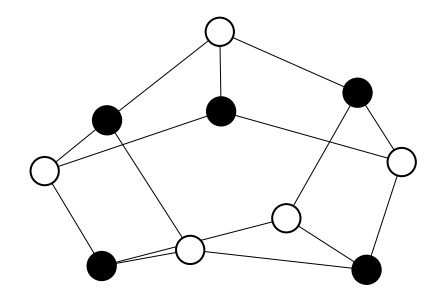

Method,Average,Variance,Best,Approx. Ratio,Cut Dist
Random,7.22,4.75,12.00,0.60,[ -5 -8 -8 -8 -8 -9 -11 -9 -5 -4 -3 -7 -10 -8 -12 -8 -10 -8 -8 -6 -8 -4 -10 -6 -9 -7 -9 -8 -8 -7 -7 -6 -6 -7 -7 -7 -5 -11 -5 -7 -10 -8 -8 -5 -9 -6 -3 -9 -8 -9 -7 -4 -5 -3 -8 -8 -7 -9 -7 -10 -6 0 -11 -8 -8 -6 -9 -3 -7 -5 -6 -10 -6 -10 -11 -9 -8 -11 -7 -5 -9 -5 -10 -5 -6 -5 -4 -7 -3 -9 -7 -7 -6 -9 -5 -6 -8 -8 -6 -9]
Brute force,7.50,3.75,15.00,0.50,[ 0 -3 -3 ... -3 -3 0]
PAOA,11.53,6.23,15.00,0.77,[ -8 -10 -9 -9 -15 -11 -7 -7 -15 -15 -11 -15 -12 -12 -11 -15 -12 -8 -12 -15 -12 -12 -10 -12 -11 -15 -15 -12 -15 -10 -12 -8 -11 -7 -10 -12 -15 -12 -9 -10 -12 -15 -9 -11 -15 -12 -12 -8 -11 -12 -12 -9 -9 -10 -12 -12 -10 -15 -15 -15 -8 -15 -9 -9 -7 -8 -9 -7 -11 -15 -11 -10 -8 -15 -11 -15 -10 -11 -12 -15 -11 -12 -15 -9 -15 -12 -11 -15 -12 -12 -15 -11 -12 -15 -12 -9 -8 -12 -9 -15]
Reduced PAOA,11.72,4.80,15.00,0.78,[-12 -12 -8 -12 -12 -15 -12 -11 -12 -12 -7 -11 -12 -12 -10 -10 -15 -15 -9 -12 -15 -12 -11 -11 -12 -9 -9 -12 -12 -9 -12 -15 -12 -15 -11 -12 -12 -12 -12 -11 -12 -15 -11 -11 -15 -15 -12 -12 -11 -8 -10 -11 -15 -10 -8 -6 -11 -15 -15 -11 -10 -15 -12 -15 -11 -12 -15 -15 -15 -10 -9 -10 -12 -8 -10 -10 -11 -10 -11 -15 -15 -12 -15 -10 -6 -11 -12 -15 -10 -11 -11 -15 -10 -15 -11 -11 -11 -11 -11 -12]
Min PAOA (1 layer),14.85,1.11,15.00,0.99,[ -8 -7 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15]
Min PAOA (3 layers),5.89,3.30,12.00,0.49,[ -6 -4 -5 -7 -9 -5 -6 -8 -5 -9 -4 -4 -3 -9 -6 -8 -9 -7 -4 -6 -6 -8 -5 -3 -8 -9 -4 -4 -6 -7 -4 -9 -8 -6 -4 -6 -6 -6 -8 -6 -4 -4 -4 -6 -4 -4 -7 -4 -5 -5 -6 -6 -7 -4 -6 -6 -7 -4 -8 -5 -5 -6 -10 -7 -7 -4 -3 -6 -3 -4 -7 -6 -5 -6 -3 -4 -6 -7 -5 -6 -6 -3 -12 -4 -7 -7 -6 -6 -5 -8 -8 -7 -6 -4 -6 -3 -10 -5 -7 -6]
QAOA (1 layer),8.02,2.16,12.00,0.67,[-10 -8 -6 -7 -9 -7 -7 -9 -9 -5 -9 -9 -7 -11 -11 -8 -9 -7 -7 -6 -12 -9 -7 -5 -7 -6 -9 -8 -8 -8 -8 -9 -7 -8 -10 -9 -8 -11 -6 -8 -10 -6 -9 -9 -6 -7 -10 -8 -8 -7 -9 -9 -9 -8 -9 -10 -6 -8 -6 -8 -11 -9 -7 -8 -8 -10 -11 -8 -10 -8 -6 -7 -7 -5 -9 -9 -8 -8 -9 -7 -7 -6 -8 -7 -6 -8 -8 -9 -6 -9 -9 -8 -7 -9 -6 -6 -9 -8 -8 -7]
QAOA (3 layers),8.10,2.65,11.00,0.74,[ -7 -8 -7 -7 -10 -7 -7 -7 -9 -8 -6 -10 -7 -7 -8 -9 -8 -8 -7 -9 -9 -9 -8 -8 -7 -9 -9 -8 -7 -8 -7 -8 -8 -7 -10 -8 -7 -6 -9 -3 -8 -10 -9 -6 -10 -11 -9 -9 -7 -10 -11 -8 -11 -11 -11 -8 -7 -8 -8 -10 -6 -3 -9 -7 -9 -8 -8 -6 -9 -7 -8 -4 -10 -10 -11 -7 -7 -6 -6 -9 -7 -6 -8 -8 -8 -8 -11 -10 -11 -6 -7 -9 -9 -8 -11 -9 -7 -9 -7 -8]
QAOA (6 layers),7.62,4.92,12.00,0.64,[ -7 -8 -9 -11 -5 -10 -7 -7 -3 -6 0 -11 -7 -9 -8 -8 -10 -10 -9 -11 -8 -9 -8 -8 -8 -12 -7 -10 -7 -8 -9 -8 -9 -6 -8 -11 -6 -3 -6 -7 -10 -9 -8 -7 -7 -6 -8 -11 -6 -7 -8 -5 -6 -7 -8 -5 -10 -9 -8 -5 -9 -8 -7 -8 -7 -4 -8 -9 -11 -4 -6 -8 -6 -9 -11 -11 -8 -9 -6 -4 -4 -6 -8 -6 -8 0 -7 -11 -5 -10 -9 -9 -5 -9 -9 -7 -7 -8 -7 -10]


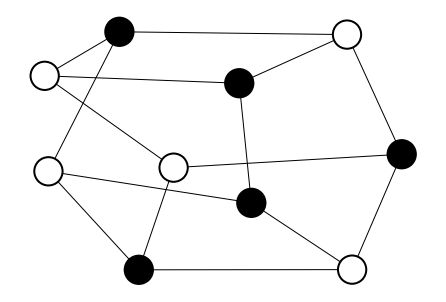

Method,Average,Variance,Best,Approx. Ratio,Cut Dist
Random,7.31,4.19,13.00,0.56,[ -3 -10 -8 -4 -9 -7 -6 -5 -8 -9 -10 -9 -6 -7 -8 -13 -5 -7 -6 -9 -4 -8 -7 -8 -7 -4 -6 -5 -6 -9 -8 -8 -7 -5 -6 -7 -8 -8 -5 -8 -7 -9 -6 -5 -8 -9 -8 -7 -6 -10 -8 -12 -4 -3 -7 -5 -10 -6 -8 -13 -7 -8 -9 -9 -3 -8 -9 -6 -7 -6 -8 -9 -7 -7 -6 -9 -10 -8 -6 -4 -7 -8 -8 -9 -11 -7 -8 -3 -10 -6 -5 -9 -6 -9 -8 -8 -10 -9 -4 -6]
Brute force,7.50,3.75,13.00,0.58,[ 0 -3 -3 ... -3 -3 0]
PAOA,9.90,2.11,13.00,0.76,[-10 -12 -8 -11 -10 -12 -9 -9 -13 -7 -9 -12 -6 -10 -9 -8 -10 -10 -10 -8 -10 -10 -10 -8 -6 -10 -10 -10 -11 -13 -10 -10 -11 -12 -8 -10 -9 -10 -10 -10 -9 -10 -10 -10 -10 -9 -9 -11 -12 -11 -9 -9 -9 -10 -11 -10 -9 -10 -10 -11 -9 -9 -8 -10 -10 -11 -13 -10 -10 -8 -13 -9 -12 -10 -10 -10 -9 -11 -9 -12 -11 -10 -10 -10 -11 -10 -10 -13 -8 -13 -9 -11 -10 -11 -8 -6 -10 -8 -9 -9]
Reduced PAOA,10.17,2.54,13.00,0.78,[ -8 -8 -11 -8 -13 -8 -11 -9 -12 -11 -9 -8 -11 -11 -11 -11 -10 -11 -11 -10 -8 -11 -12 -10 -10 -11 -8 -12 -11 -8 -11 -12 -11 -7 -8 -12 -11 -5 -11 -9 -10 -8 -12 -10 -11 -11 -11 -11 -9 -10 -12 -11 -12 -8 -12 -12 -12 -11 -12 -11 -11 -8 -11 -9 -11 -9 -11 -8 -8 -11 -10 -9 -10 -11 -8 -11 -8 -11 -11 -11 -7 -13 -11 -11 -11 -9 -9 -8 -12 -11 -10 -11 -7 -7 -11 -12 -12 -11 -11 -10]
Min PAOA (1 layer),10.78,3.11,13.00,0.83,[-12 -9 -8 -13 -12 -12 -13 -10 -9 -7 -10 -12 -11 -5 -11 -13 -13 -12 -10 -10 -9 -9 -11 -12 -10 -11 -11 -11 -9 -10 -11 -8 -12 -12 -11 -10 -13 -10 -12 -13 -10 -10 -11 -10 -11 -11 -12 -12 -8 -11 -9 -9 -13 -12 -12 -8 -10 -10 -10 -7 -5 -9 -11 -10 -13 -12 -13 -10 -13 -12 -12 -12 -12 -12 -12 -10 -12 -12 -13 -13 -13 -12 -9 -12 -9 -8 -12 -12 -12 -12 -12 -13 -9 -10 -9 -12 -13 -10 -8 -10]
Min PAOA (3 layers),8.31,1.97,11.00,0.76,[ -9 -6 -8 -9 -8 -9 -9 -9 -9 -8 -9 -8 -9 -9 -10 -8 -8 -10 -7 -8 -9 -10 -10 -6 -6 -8 -10 -9 -9 -10 -11 -10 -9 -7 -9 -7 -10 -9 -9 -9 -8 -5 -6 -9 -10 -9 -8 -10 -11 -7 -8 -10 -10 -7 -6 -8 -9 -9 -9 -9 -7 -7 -7 -8 -7 -4 -6 -8 -9 -7 -8 -8 -11 -11 -8 -9 -7 -6 -8 -9 -8 -7 -7 -7 -9 -8 -9 -9 -10 -9 -6 -7 -7 -8 -9 -6 -9 -11 -8 -7]
QAOA (1 layer),8.21,2.47,12.00,0.68,[ -8 -11 -8 -10 -5 -7 -7 -7 -8 -7 -9 -10 -7 -8 -8 -11 -6 -8 -8 -8 -9 -7 -7 -5 -11 -10 -12 -8 -8 -10 -8 -10 -8 -7 -8 -7 -7 -8 -7 -9 -10 -10 -7 -4 -6 -5 -7 -7 -8 -10 -8 -8 -9 -8 -8 -10 -7 -11 -9 -7 -8 -10 -9 -8 -8 -8 -5 -10 -9 -10 -8 -11 -7 -8 -7 -9 -8 -11 -7 -8 -10 -9 -6 -10 -9 -8 -10 -7 -7 -8 -5 -9 -7 -8 -10 -9 -11 -8 -7 -8]
QAOA (3 layers),8.17,2.88,12.00,0.68,[ -8 -8 -9 -8 -7 -6 -9 -10 -8 -9 -11 -6 -9 -7 -11 -8 -7 -10 -6 -8 -8 -8 -6 -9 -7 -10 -8 -11 -7 -8 -7 -10 -8 -7 -7 -8 -9 -8 -7 -8 -8 -6 -6 -11 -6 -7 -10 -10 -8 -9 -5 -6 -7 -10 -10 -9 -5 -7 -7 -12 -11 -11 -10 -11 -11 -10 -9 -10 -10 -11 -7 -8 -7 -9 -7 -8 -6 -11 -5 -10 -8 -8 -8 -7 -5 -9 -6 -9 -8 -7 -9 -11 -7 -6 -8 -8 -8 -6 -6 -6]
QAOA (6 layers),7.96,4.50,13.00,0.61,[ -3 -9 -9 -7 -9 -4 -13 -12 -9 -9 -4 -10 -9 -10 -9 -8 -9 -7 -7 -12 -7 -8 -9 -10 -6 -8 -11 -8 -9 -5 -7 -4 -4 -5 -6 -7 -6 -11 -5 -12 -7 -8 -9 -9 -7 -9 -10 -9 -9 -7 -11 -7 -7 -6 -7 -9 -7 -7 -7 -11 -10 -7 -11 -11 -9 -7 -8 -11 -11 -7 -4 -7 -6 -8 -5 -8 -5 -3 -7 -5 -8 -9 -5 -8 -10 -7 -7 -7 -9 -8 -7 -10 -9 -9 -9 -8 -9 -8 -7 -12]


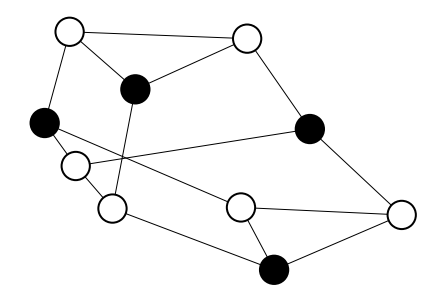

Method,Average,Variance,Best,Approx. Ratio,Cut Dist
Random,7.57,3.83,12.00,0.63,[ -7 -9 -5 -7 -6 -6 -4 -7 -8 -10 -6 -9 -3 -6 -7 -9 -10 -7 -8 -7 -6 -6 -10 -8 -5 -6 -9 -10 -9 -8 -7 -10 -10 -10 -9 -10 -11 -6 -9 -9 -7 -7 -6 -11 -6 -4 -11 -5 -8 -6 -6 -9 -7 -9 -9 -4 -3 -6 -6 -9 -9 -4 -7 -8 -11 -8 -10 -8 -9 -6 -6 -10 -5 -7 -3 -9 -9 -5 -7 -5 -7 -9 -7 -12 -11 -8 -6 -7 -8 -8 -8 -8 -9 -9 -7 -9 -7 -8 -7 -8]
Brute force,7.50,3.75,12.00,0.62,[ 0 -3 -3 ... -3 -3 0]
PAOA,9.44,3.25,12.00,0.79,[-11 -12 -10 -11 -12 -10 -6 -5 -10 -7 -9 -12 -7 -11 -10 -7 -9 -11 -9 -11 -8 -9 -11 -9 -10 -10 -5 -7 -9 -5 -9 -10 -11 -6 -11 -9 -10 -11 -7 -10 -10 -10 -10 -10 -10 -10 -11 -9 -10 -12 -11 -11 -8 -10 -12 -10 -10 -10 -12 -10 -9 -9 -8 -10 -10 -11 -9 -9 -10 -11 -10 -8 -6 -10 -10 -8 -11 -12 -6 -12 -10 -7 -10 -11 -9 -10 -10 -4 -10 -10 -12 -8 -10 -11 -9 -10 -10 -9 -7 -5]
Reduced PAOA,10.07,0.69,12.00,0.84,[-10 -11 -10 -10 -10 -10 -11 -11 -11 -11 -11 -11 -7 -11 -10 -10 -10 -9 -9 -10 -11 -9 -10 -9 -11 -10 -10 -10 -10 -11 -9 -10 -10 -8 -10 -10 -9 -10 -11 -9 -11 -11 -12 -9 -9 -10 -9 -10 -11 -10 -9 -11 -10 -10 -11 -10 -10 -9 -9 -10 -10 -11 -9 -11 -10 -10 -10 -11 -10 -10 -10 -10 -11 -11 -10 -10 -11 -11 -10 -9 -11 -10 -9 -11 -11 -11 -11 -11 -9 -10 -9 -9 -10 -11 -10 -10 -9 -10 -9 -10]
Min PAOA (1 layer),10.90,0.29,12.00,0.91,[-12 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -8 -10 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -8 -10 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -8]
Min PAOA (3 layers),7.53,3.19,11.00,0.68,[ -8 -6 -10 -5 -8 -8 -8 -9 -7 -6 -9 -6 -9 -4 -6 -10 -8 -8 -6 -8 -10 -7 -6 -7 -8 -8 -9 -10 -7 -6 -5 -8 -9 -5 -8 -9 -10 -11 -6 -9 -7 -7 -6 -7 -7 -9 -7 -9 -9 -5 -8 -7 -6 -7 -6 -6 -9 -8 -6 -7 -7 -5 -11 -9 -6 -9 -10 -5 -5 -7 -8 -10 -5 -6 -9 -8 -10 -8 -10 -10 -10 -4 -11 -7 -9 -5 -5 -11 -7 -8 -9 -6 -6 -3 -10 -7 -8 -6 -7 -6]
QAOA (1 layer),8.31,3.13,11.00,0.76,[ -5 -5 -6 -8 -8 -8 -10 -10 -9 -8 -7 -5 -9 -7 -9 -10 -7 -8 -5 -7 -9 -8 -10 -6 -8 -9 -8 -10 -7 -11 -8 -9 -7 -11 -10 -6 -9 -8 -7 -10 -7 -6 -7 -7 -5 -5 -9 -9 -6 -7 -10 -9 -7 -7 -9 -10 -11 -8 -10 -5 -11 -9 -9 -7 -10 -8 -5 -10 -9 -8 -7 -10 -8 -7 -10 -8 -7 -11 -9 -11 -6 -11 -11 -8 -11 -11 -9 -8 -11 -9 -11 -11 -8 -8 -6 -11 -6 -9 -7 -9]
QAOA (3 layers),8.66,2.98,12.00,0.72,[ -9 -12 -11 -8 -6 -10 -9 -10 -5 -11 -11 -10 -9 -11 -9 -10 -10 -11 -7 -5 -9 -6 -11 -7 -10 -10 -7 -9 -8 -8 -9 -5 -8 -7 -7 -9 -6 -10 -9 -10 -11 -10 -7 -7 -9 -9 -9 -9 -9 -10 -7 -9 -11 -8 -11 -10 -6 -11 -5 -10 -10 -9 -9 -7 -11 -5 -9 -9 -6 -7 -7 -9 -7 -7 -11 -5 -7 -9 -10 -9 -10 -9 -11 -9 -9 -11 -10 -8 -8 -9 -7 -9 -6 -8 -8 -8 -9 -7 -11 -9]
QAOA (6 layers),8.26,3.77,11.00,0.75,[-11 -10 -8 -7 -9 -7 -8 -7 -6 -4 -8 -11 -9 -7 -10 -9 -5 -9 -9 -9 -5 -10 -8 -8 -9 -9 -8 -6 -10 -9 -7 -9 -7 -9 -8 -10 -10 -11 -10 -7 -11 -6 -10 -9 -8 -11 -8 -7 -9 -3 -7 -11 -9 -7 -10 -9 -11 -6 -4 -10 -11 -6 -11 -7 -5 -11 -6 -6 -9 -9 -8 -10 -9 -9 -6 -11 -9 -11 -6 -9 -8 -11 -7 -6 -8 -9 -9 -6 -10 -5 -6 -7 -6 -11 -6 -10 -10 -11 -6 -6]


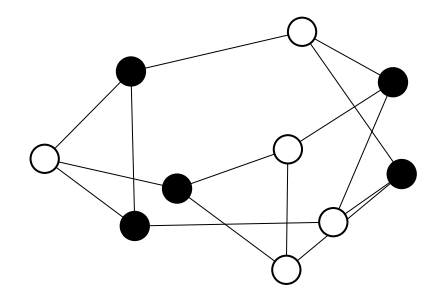

Method,Average,Variance,Best,Approx. Ratio,Cut Dist
Random,7.19,4.55,12.00,0.60,[ -6 -5 -8 -9 -8 -12 -3 -4 -6 -8 -8 -8 -7 -4 -6 -5 -9 -8 -9 -7 -7 -10 -7 -8 -11 -6 -3 -5 -7 -7 -6 -10 -4 -6 -9 -6 -7 -7 -6 -6 -6 -8 -9 -7 -10 -9 -8 -9 -7 -4 -6 -10 -9 -11 -6 -6 -8 -4 -8 -6 -5 -6 -9 -11 -8 -11 -11 -6 -10 -10 -9 -10 -6 -10 -6 -4 -7 -9 -7 -7 -6 -9 0 -6 -6 -7 -8 -7 -5 -9 -5 -6 -3 -7 -10 -5 -6 -8 -9 -6]
Brute force,7.50,3.75,13.00,0.58,[ 0 -3 -3 ... -3 -3 0]
PAOA,10.26,0.93,11.00,0.93,[-11 -9 -10 -9 -11 -8 -11 -10 -11 -11 -11 -11 -9 -10 -10 -10 -7 -10 -11 -10 -10 -9 -9 -9 -11 -11 -10 -10 -11 -10 -9 -11 -11 -7 -11 -10 -8 -9 -11 -11 -11 -11 -10 -11 -10 -11 -11 -11 -10 -11 -11 -11 -10 -11 -11 -11 -11 -11 -10 -11 -9 -11 -11 -10 -11 -11 -8 -8 -10 -11 -10 -10 -11 -11 -11 -11 -11 -11 -10 -11 -10 -11 -11 -10 -10 -10 -11 -9 -8 -11 -11 -10 -10 -11 -11 -11 -10 -10 -10 -11]
Reduced PAOA,10.07,1.25,12.00,0.84,[-10 -8 -10 -9 -11 -11 -11 -11 -9 -10 -9 -11 -8 -9 -10 -11 -11 -9 -10 -10 -10 -11 -10 -10 -11 -11 -9 -10 -11 -11 -7 -9 -10 -10 -10 -11 -11 -10 -10 -10 -10 -11 -10 -8 -8 -12 -11 -11 -9 -10 -10 -10 -10 -10 -11 -11 -9 -11 -11 -11 -10 -11 -10 -8 -9 -9 -11 -11 -11 -12 -10 -10 -11 -10 -11 -11 -8 -6 -8 -11 -10 -7 -10 -10 -11 -10 -11 -11 -12 -9 -11 -10 -9 -10 -10 -10 -11 -11 -11 -11]
Min PAOA (1 layer),10.01,3.25,13.00,0.77,[ -9 -6 -13 -13 -9 -11 -7 -9 -8 -11 -8 -11 -11 -13 -10 -9 -9 -9 -9 -10 -12 -10 -10 -10 -4 -12 -10 -9 -11 -12 -10 -12 -9 -12 -10 -7 -11 -9 -12 -9 -11 -8 -12 -9 -9 -11 -12 -12 -9 -9 -11 -8 -9 -12 -10 -12 -13 -12 -13 -12 -10 -6 -7 -8 -13 -10 -11 -11 -11 -7 -10 -8 -10 -10 -12 -11 -10 -10 -9 -8 -9 -11 -9 -9 -8 -10 -9 -10 -11 -11 -12 -12 -12 -12 -10 -7 -10 -11 -6 -10]
Min PAOA (3 layers),9.36,2.37,13.00,0.72,[-11 -8 -7 -9 -9 -10 -11 -10 -10 -11 -9 -8 -9 -10 -9 -11 -8 -10 -12 -7 -7 -8 -9 -12 -11 -9 -5 -9 -8 -9 -10 -10 -12 -9 -9 -8 -11 -9 -8 -7 -8 -9 -9 -9 -9 -9 -8 -11 -10 -10 -10 -9 -9 -9 -12 -11 -11 -7 -8 -12 -12 -8 -10 -9 -11 -10 -10 -10 -10 -7 -11 -9 -8 -9 -9 -11 -10 -8 -9 -9 -11 -6 -13 -10 -10 -10 -6 -9 -8 -11 -9 -6 -8 -11 -9 -7 -11 -12 -10 -10]
QAOA (1 layer),8.20,2.90,13.00,0.63,[ -7 -8 -8 -8 -11 -11 -6 -9 -5 -10 -8 -7 -7 -10 -9 -6 -8 -10 -11 -8 -6 -6 -10 -5 -10 -6 -7 -8 -10 -9 -6 -8 -8 -8 -9 -11 -8 -8 -9 -11 -8 -7 -10 -6 -8 -10 -8 -10 -7 -7 -5 -5 -10 -6 -9 -6 -8 -10 -11 -8 -8 -8 -6 -10 -8 -9 -10 -13 -9 -7 -8 -9 -9 -5 -7 -9 -7 -8 -8 -9 -9 -7 -11 -10 -6 -7 -9 -7 -9 -9 -9 -10 -11 -7 -7 -10 -8 -6 -6 -6]
QAOA (3 layers),8.28,3.46,13.00,0.64,[ -8 -7 -7 -8 -9 -7 -6 -8 -9 -8 -8 -9 -9 -11 -9 -9 -10 -11 -7 -9 -10 -11 -11 -11 -10 -5 -11 -10 -8 -10 -7 -9 -5 -9 -9 -7 -11 -6 -9 -4 -11 -5 -6 -7 -11 -6 -7 -9 -5 -9 -7 -9 -5 -11 -8 -8 -8 -9 -6 -9 -8 -9 -9 -7 -7 -5 -5 -11 -11 -8 -5 -7 -9 -9 -9 -11 -10 -8 -7 -9 -8 -7 -7 -9 -9 -7 -5 -8 -8 -11 -7 -9 -10 -5 -9 -8 -7 -9 -10 -13]
QAOA (6 layers),8.45,2.31,12.00,0.70,[ -9 -12 -8 -7 -11 -11 -9 -9 -9 -7 -7 -9 -9 -8 -10 -11 -7 -7 -9 -10 -7 -11 -8 -11 -7 -11 -9 -6 -7 -8 -8 -8 -8 -8 -8 -10 -9 -8 -7 -9 -9 -11 -11 -10 -8 -8 -8 -9 -9 -9 -8 -8 -9 -6 -10 -8 -5 -8 -6 -10 -8 -9 -9 -11 -8 -10 -9 -10 -8 -8 -5 -7 -7 -7 -10 -6 -10 -7 -9 -6 -8 -9 -9 -4 -9 -6 -9 -10 -8 -9 -9 -8 -7 -8 -7 -9 -9 -11 -7 -8]


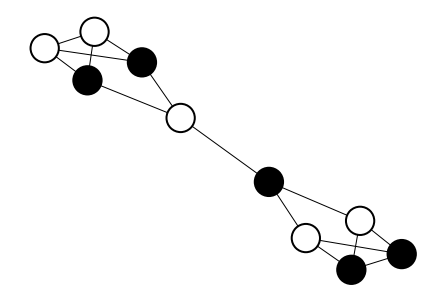

Method,Average,Variance,Best,Approx. Ratio,Cut Dist
Random,7.23,4.04,12.00,0.60,[ -9 -9 -10 -4 -8 -10 -5 -6 -5 -10 -8 -8 -3 -8 -7 -4 -6 -7 -8 -8 -7 -7 -7 -8 -10 -6 -4 -7 -11 -9 -9 -7 -8 -4 -8 -7 -8 -8 -7 -7 -6 -6 -7 -4 -9 -11 -6 -7 -9 -6 -7 -7 -3 -5 -7 -11 -8 -8 -6 -8 -9 -5 -7 -8 -7 -4 -7 -3 -9 -7 -6 -9 -9 -7 -3 -11 -8 -6 -8 -6 -4 -9 -8 -7 -9 -8 -9 -10 -7 -8 -6 -11 -9 -4 -12 -5 -9 -6 -4 -6]
Brute force,7.50,3.75,13.00,0.58,[ 0 -3 -3 ... -3 -3 0]
PAOA,10.54,2.47,13.00,0.81,[ -9 -10 -12 -10 -10 -9 -10 -11 -10 -8 -8 -13 -11 -11 -13 -13 -10 -8 -12 -11 -11 -12 -13 -11 -11 -11 -9 -9 -8 -13 -11 -11 -9 -8 -8 -10 -10 -12 -11 -11 -13 -10 -10 -11 -13 -11 -11 -12 -11 -10 -13 -11 -11 -11 -10 -7 -9 -11 -11 -11 -10 -11 -11 -11 -7 -8 -8 -9 -8 -8 -12 -10 -8 -13 -11 -12 -11 -11 -8 -10 -11 -10 -11 -13 -10 -13 -13 -11 -7 -11 -13 -11 -11 -13 -11 -10 -11 -10 -12 -10]
Reduced PAOA,10.00,1.36,12.00,0.83,[-10 -9 -7 -11 -9 -9 -12 -11 -11 -10 -10 -10 -10 -10 -8 -11 -11 -10 -9 -11 -9 -9 -9 -9 -11 -11 -10 -9 -9 -10 -12 -11 -11 -10 -9 -9 -8 -9 -9 -11 -8 -10 -10 -11 -11 -9 -11 -8 -8 -10 -11 -10 -9 -11 -10 -7 -12 -11 -11 -10 -10 -11 -9 -11 -10 -10 -9 -9 -12 -10 -11 -11 -10 -10 -10 -9 -11 -9 -9 -10 -10 -12 -9 -10 -9 -11 -10 -7 -9 -10 -9 -10 -10 -11 -12 -12 -12 -12 -11 -11]
Min PAOA (1 layer),10.00,1.84,12.00,0.83,[ -8 -11 -11 -11 -11 -11 -10 -9 -9 -9 -9 -6 -11 -11 -11 -11 -9 -9 -6 -9 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -11 -10 -9 -9 -9 -9 -10 -10 -9 -6 -11 -11 -11 -11 -10 -9 -9 -11 -11 -11 -11 -11 -11 -11 -7 -9 -9 -9 -11 -11 -11 -11 -10 -9 -9 -9 -10 -9 -9 -9 -9 -9 -11 -11 -11 -11 -11 -11 -11 -11 -6 -10 -9 -9 -9 -6 -11 -12 -11 -11 -11 -8 -9]
Min PAOA (3 layers),10.30,3.99,13.00,0.79,[ -9 -10 -13 -13 -11 -10 -9 -12 -9 -11 -12 -10 -6 -9 -12 -13 -12 -10 -12 -11 -12 -9 -13 -6 -12 -9 -6 -5 -9 -10 -12 -10 -12 -10 -10 -10 -6 -12 -11 -12 -7 -8 -7 -7 -9 -12 -8 -7 -12 -12 -11 -10 -9 -11 -9 -11 -12 -12 -12 -10 -10 -12 -10 -11 -8 -13 -10 -13 -13 -7 -8 -9 -8 -12 -9 -10 -11 -12 -8 -9 -13 -10 -9 -11 -12 -13 -13 -10 -6 -12 -12 -12 -11 -10 -10 -10 -12 -9 -13 -13]
QAOA (1 layer),7.45,4.81,12.00,0.62,[ -7 -9 -8 -8 -7 -8 -8 -7 -8 -11 -4 -7 -10 -8 -10 -11 -8 -4 -6 -12 -6 -10 -10 -9 -7 -7 -10 -6 -9 -8 -7 -8 -10 -7 -6 -9 -9 -9 -9 -4 -8 -4 -7 -7 -7 -5 -5 -10 -9 -7 -7 -6 -6 -9 -1 -6 -11 -9 -6 -8 -7 -8 -8 -8 -10 -8 -7 -6 -9 -7 -9 -8 -2 -7 -1 -9 -2 -9 -6 -8 -8 -5 -10 -7 -11 -9 -9 -7 -8 -7 -10 -8 -5 -5 -5 -8 -7 -10 -1 -7]
QAOA (3 layers),7.97,2.57,12.00,0.66,[ -5 -9 -9 -8 -8 -11 -8 -8 -9 -8 -11 -7 -9 -9 -8 -8 -7 -7 -8 -6 -6 -7 -6 -8 -8 -11 -7 -7 -9 -9 -8 -6 -9 -7 -8 -8 -6 -8 -9 -6 -9 -7 -9 -12 -8 -6 -6 -9 -8 -7 -7 -9 -7 -9 -8 -6 -9 -8 -5 -8 -6 -7 -8 -7 -12 -9 -11 -9 -8 -8 -8 -11 -8 -6 -12 -8 -12 -6 -8 -9 -7 -6 -6 -6 -11 -7 -9 -9 -5 -8 -8 -8 -6 -6 -7 -9 -7 -9 -10 -7]
QAOA (6 layers),7.91,3.50,12.00,0.66,[ -9 -6 -6 -9 -6 -7 -11 -6 -8 -8 -7 -8 -12 -7 -10 -8 -7 -8 -9 -7 -7 -1 -6 -7 -9 -6 -9 -9 -11 -6 -9 -8 -7 -8 -7 -7 -8 -7 -9 -7 -9 -7 -6 -8 -8 -8 -7 -7 -7 -9 -7 -6 -7 -8 -6 -8 -9 -8 -6 -6 -10 -6 -11 -8 -9 -12 -10 -8 -9 -6 -6 -12 -7 -7 -6 -7 -6 -8 -12 -6 -8 -11 -8 -11 -6 -6 -6 -6 -11 -11 -9 -9 -9 -5 -6 -12 -9 -10 -8 -10]


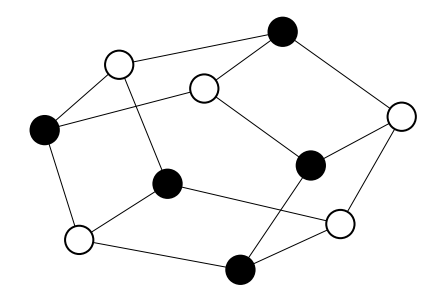

Method,Average,Variance,Best,Approx. Ratio,Cut Dist
Random,7.41,3.54,12.00,0.62,[ -9 -8 -7 -8 -5 -9 -11 -7 -8 -6 -8 -7 -8 -7 -10 -10 -5 -8 -7 -8 -8 -9 -9 -6 -6 0 -8 -6 -9 -7 -7 -7 -9 -7 -4 -4 -5 -7 -5 -7 -6 -6 -8 -8 -9 -8 -5 -5 -8 -8 -5 -10 -8 -6 -10 -6 -6 -9 -5 -9 -8 -7 -6 -8 -8 -8 -8 -9 -6 -9 -7 -7 -6 -8 -7 -10 -7 -9 -5 -8 -8 -7 -9 -6 -9 -6 -10 -6 -10 -8 -12 -10 -8 -10 -11 -5 -10 -5 -3 -6]
Brute force,7.50,3.75,13.00,0.58,[ 0 -3 -3 ... -3 -3 0]
PAOA,10.60,3.94,13.00,0.82,[-12 -9 -9 -12 -13 -12 -9 -12 -8 -13 -10 -13 -13 -8 -12 -12 -9 -9 -8 -12 -12 -7 -11 -13 -10 -6 -13 -12 -9 -12 -13 -12 -13 -8 -12 -13 -9 -11 -7 -9 -12 -12 -12 -11 -12 -12 -12 -12 -11 -8 -7 -9 -6 -9 -13 -12 -12 -6 -9 -12 -12 -11 -7 -8 -8 -8 -13 -10 -11 -12 -12 -12 -9 -10 -12 -9 -12 -13 -13 -11 -12 -9 -13 -10 -12 -10 -12 -13 -12 -8 -9 -8 -8 -11 -11 -9 -9 -12 -10 -13]
Reduced PAOA,9.06,2.40,13.00,0.70,[-10 -9 -8 -9 -8 -9 -8 -7 -10 -10 -9 -10 -10 -11 -13 -9 -8 -7 -7 -8 -8 -9 -8 -8 -9 -9 -9 -13 -7 -9 -7 -8 -9 -8 -10 -9 -10 -10 -8 -10 -7 -13 -9 -10 -6 -9 -10 -8 -10 -10 -9 -10 -9 -10 -10 -9 -9 -10 -6 -8 -9 -10 -13 -8 -12 -8 -12 -8 -13 -8 -9 -6 -9 -9 -7 -9 -10 -13 -8 -9 -9 -10 -10 -9 -9 -10 -8 -9 -8 -8 -7 -10 -9 -7 -8 -8 -7 -12 -9 -9]
Min PAOA (1 layer),11.75,2.29,13.00,0.90,[ -9 -13 -12 -11 -12 -12 -9 -8 -9 -13 -12 -12 -12 -12 -12 -12 -12 -9 -9 -7 -10 -10 -12 -12 -12 -12 -13 -9 -6 -10 -13 -12 -13 -11 -13 -12 -12 -13 -12 -12 -13 -12 -12 -13 -12 -12 -13 -12 -13 -12 -9 -13 -13 -13 -13 -13 -12 -9 -13 -13 -12 -13 -12 -13 -12 -10 -12 -12 -12 -12 -12 -12 -12 -13 -12 -13 -13 -12 -12 -12 -13 -13 -9 -13 -13 -8 -12 -13 -12 -13 -12 -12 -13 -12 -12 -13 -13 -13 -13 -9]
Min PAOA (3 layers),8.56,2.67,13.00,0.66,[ -8 -11 -10 -8 -9 -9 -11 -6 -10 -9 -9 -8 -7 -7 -8 -9 -8 -9 -8 -9 -9 -9 -7 -7 -8 -8 -9 -9 -7 -10 -5 -7 -5 -9 -8 -7 -10 -8 -10 -8 -10 -7 -7 -6 -13 -9 -10 -7 -7 -12 -9 -12 -8 -8 -10 -8 -8 -8 -9 -8 -8 -12 -9 -8 -7 -11 -8 -8 -12 -9 -8 -6 -11 -9 -9 -7 -7 -8 -8 -8 -9 -8 -11 -8 -8 -8 -9 -12 -6 -7 -7 -11 -12 -10 -10 -5 -8 -7 -9 -9]
QAOA (1 layer),9.05,2.23,13.00,0.70,[ -7 -9 -10 -8 -7 -9 -9 -9 -10 -9 -13 -8 -8 -10 -9 -13 -12 -9 -8 -11 -9 -10 -8 -8 -9 -9 -9 -8 -13 -10 -11 -10 -10 -8 -11 -10 -8 -9 -7 -8 -11 -11 -8 -9 -12 -9 -11 -9 -9 -8 -10 -13 -10 -8 -9 -6 -10 -8 -8 -9 -9 -8 -8 -7 -7 -12 -8 -8 -8 -7 -8 -9 -9 -8 -9 -9 -8 -7 -12 -9 -9 -7 -10 -8 -10 -8 -7 -7 -7 -10 -9 -8 -10 -9 -11 -9 -9 -9 -9 -8]
QAOA (3 layers),9.12,5.63,13.00,0.70,[ -9 -12 -11 -9 -8 -8 -9 -11 -9 -12 -10 -12 -10 -12 -7 -5 -12 -9 -12 -9 -6 -11 -7 -10 -11 -8 -11 -5 -9 -9 -11 -10 -7 -8 -5 -5 -7 -7 -12 -12 -5 -12 -12 -9 -11 -8 -13 -5 -12 -9 -8 -5 -10 -8 -13 -6 -5 -8 -11 -13 -12 -12 -10 -5 -11 -13 -10 -5 -9 -9 -5 -9 -9 -13 -11 -11 -8 -7 -8 -7 -6 -12 -9 -11 -10 -7 -11 -9 -11 -9 -5 -10 -9 -9 -7 -9 -13 -7 -7 -7]
QAOA (6 layers),9.21,1.57,13.00,0.71,[ -9 -9 -8 -10 -9 -9 -8 -8 -12 -9 -9 -8 -10 -9 -9 -13 -10 -9 -7 -9 -11 -9 -9 -9 -9 -8 -9 -8 -9 -8 -8 -9 -9 -6 -9 -9 -9 -11 -9 -9 -8 -9 -9 -9 -9 -8 -8 -9 -10 -10 -9 -8 -8 -10 -11 -9 -8 -10 -7 -11 -10 -9 -12 -12 -11 -9 -10 -9 -8 -10 -9 -9 -9 -9 -8 -10 -10 -12 -10 -6 -9 -8 -9 -9 -9 -8 -8 -9 -9 -9 -8 -11 -10 -11 -10 -9 -8 -12 -12 -10]


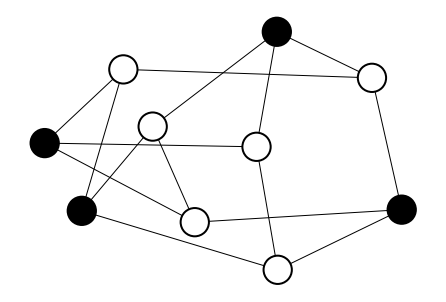

Method,Average,Variance,Best,Approx. Ratio,Cut Dist
Random,7.58,3.32,12.00,0.63,[ -6 -8 -6 -10 -3 -7 -7 -5 -5 -10 -8 -7 -8 -10 -9 -6 -9 -8 -8 -10 -8 -7 -8 -8 -6 -7 -7 -8 -6 -8 -7 -3 -5 -10 -9 -10 -6 -9 -9 -7 -6 -7 -7 -7 -7 -7 -6 -10 -7 -10 -5 -6 -8 -7 -6 -10 -7 -9 -7 -9 -10 -7 -12 -10 -3 -7 -7 -7 -6 -9 -10 -8 -9 -10 -11 -11 -8 -6 -12 -6 -7 -6 -5 -8 -5 -6 -9 -7 -8 -10 -8 -6 -8 -6 -7 -8 -7 -10 -6 -6]
Brute force,7.50,3.75,12.00,0.62,[ 0 -3 -3 ... -3 -3 0]
PAOA,9.84,2.27,12.00,0.82,[-11 -7 -10 -11 -10 -8 -5 -12 -11 -10 -10 -10 -10 -10 -10 -10 -6 -9 -12 -10 -11 -7 -10 -10 -10 -11 -10 -11 -10 -11 -7 -11 -10 -7 -10 -7 -12 -11 -8 -10 -9 -11 -7 -11 -11 -10 -11 -10 -11 -11 -9 -11 -10 -7 -10 -11 -11 -8 -11 -11 -11 -10 -11 -10 -11 -11 -10 -10 -11 -11 -11 -10 -11 -8 -11 -7 -10 -11 -10 -11 -10 -10 -11 -10 -7 -10 -8 -10 -11 -6 -8 -10 -10 -10 -11 -11 -11 -10 -11 -6]
Reduced PAOA,10.14,2.02,12.00,0.85,[-12 -11 -10 -10 -10 -11 -10 -12 -10 -10 -11 -9 -11 -10 -11 -12 -12 -10 -10 -11 -11 -10 -10 -9 -6 -11 -11 -11 -10 -11 -10 -10 -11 -11 -11 -11 -10 -12 -7 -10 -7 -10 -11 -11 -11 -11 -11 -8 -10 -8 -11 -11 -11 -11 -10 -10 -7 -10 -11 -11 -11 -11 -10 -8 -8 -11 -10 -5 -11 -10 -11 -11 -10 -12 -10 -10 -11 -10 -10 -7 -10 -11 -11 -8 -11 -10 -7 -10 -11 -11 -12 -6 -11 -11 -11 -11 -11 -7 -10 -10]
Min PAOA (1 layer),10.77,1.18,12.00,0.90,[-12 -12 -12 -12 -11 -11 -10 -11 -9 -10 -10 -11 -11 -12 -12 -12 -11 -12 -12 -10 -11 -10 -12 -11 -9 -8 -9 -11 -12 -9 -11 -10 -11 -12 -11 -9 -12 -12 -10 -11 -12 -10 -10 -10 -10 -11 -9 -10 -10 -8 -10 -11 -12 -12 -12 -11 -12 -10 -9 -12 -12 -11 -9 -12 -11 -12 -11 -9 -10 -10 -10 -10 -10 -11 -10 -10 -10 -9 -11 -10 -11 -10 -11 -10 -11 -12 -10 -9 -12 -10 -11 -12 -12 -12 -12 -12 -11 -12 -12 -12]
Min PAOA (3 layers),10.19,1.83,12.00,0.85,[-11 -10 -12 -9 -12 -11 -11 -10 -11 -12 -10 -12 -12 -11 -9 -10 -10 -9 -9 -12 -7 -12 -11 -12 -10 -10 -10 -10 -9 -12 -12 -10 -11 -10 -11 -9 -8 -7 -9 -10 -10 -10 -10 -9 -6 -10 -10 -9 -10 -11 -11 -11 -12 -10 -11 -11 -8 -8 -11 -11 -9 -9 -9 -10 -11 -9 -11 -6 -11 -10 -9 -10 -12 -11 -10 -10 -12 -10 -10 -10 -10 -10 -10 -8 -11 -12 -11 -7 -8 -10 -10 -12 -12 -10 -11 -12 -11 -11 -11 -11]
QAOA (1 layer),7.91,2.70,12.00,0.66,[ -7 -8 -6 -8 -8 -7 -11 -7 -7 -6 -7 -7 -11 -7 -8 -7 -6 -9 -6 -9 -7 -9 -7 -10 -6 -7 -8 -7 -7 -6 -9 -11 -6 -6 -10 -11 -9 -7 -8 -6 -7 -5 -8 -7 -7 -10 -9 -7 -8 -7 -6 -6 -6 -10 -7 -7 -9 -10 -8 -7 -6 -8 -11 -12 -11 -7 -11 -7 -11 -8 -7 -9 -9 -8 -9 -6 -11 -6 -8 -8 -9 -11 -7 -6 -9 -7 -11 -7 -7 -7 -8 -7 -6 -8 -6 -8 -7 -9 -7 -11]
QAOA (3 layers),7.77,3.84,11.00,0.71,[ -5 -6 -7 -11 -7 -11 -11 -7 -11 -8 -5 -7 -10 -11 -11 -7 -11 -7 -6 -7 -8 -11 -9 -7 -7 -9 -9 -7 -6 -6 -5 -7 -10 -10 -8 -6 -7 -7 -7 -8 -10 -9 -7 -6 -5 -9 -7 -10 -6 -11 -7 -5 -6 -9 -9 -11 -9 -9 -9 -9 -10 -7 -7 -7 -9 -7 -7 -10 -10 -6 -6 -11 -7 -5 -7 -7 0 -7 -9 -6 -8 -9 -10 -7 -7 -6 -11 -6 -6 -6 -8 -7 -6 -8 -7 -9 -6 -10 -5 -7]
QAOA (6 layers),8.04,3.34,12.00,0.67,[ -9 -9 -10 -8 -9 -9 -6 -7 -8 -5 -8 -10 -5 -10 -12 -10 -9 -8 -6 -7 -6 -9 -10 -6 -7 -11 -6 -10 -9 -5 -7 -10 -7 -7 -9 -8 -8 -6 -9 -11 -11 -6 -6 -7 -5 -11 -7 -8 -10 -7 -9 -10 -10 -10 -10 -10 -9 -6 -11 -5 -7 -5 -6 -10 -7 -6 -6 -8 -7 -9 -5 -6 -7 -9 -7 -5 -9 -8 -10 -5 -7 -8 -8 -5 -12 -7 -7 -8 -10 -7 -8 -9 -7 -8 -10 -9 -9 -9 -11 -9]


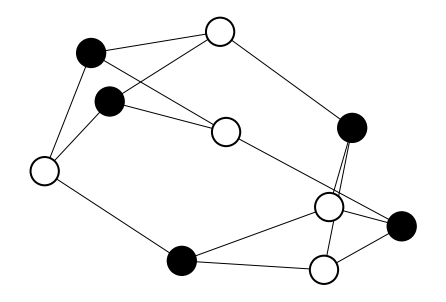

Method,Average,Variance,Best,Approx. Ratio,Cut Dist
Random,7.48,3.51,12.00,0.62,[ -8 -7 -10 -6 -4 -7 -8 -7 -7 -4 -6 -12 -8 -7 -8 -8 -7 -6 -10 -6 -3 -7 -7 -9 -9 -8 -7 -7 -4 -6 -6 -4 -8 -7 -9 -12 -9 -7 -11 -7 -11 -10 -7 -7 -9 -6 -10 -5 -5 -8 -8 -8 -8 -7 -8 -7 -6 -10 -3 -9 -8 -7 -9 -7 -9 -9 -8 -8 -8 -7 -7 -9 -7 -10 -4 -12 -3 -9 -9 -10 -6 -5 -9 -8 -8 -8 -8 -8 -9 -7 -7 -6 -6 -7 -8 -5 -5 -8 -7 -8]
Brute force,7.50,3.75,15.00,0.50,[ 0 -3 -3 ... -3 -3 0]
PAOA,9.45,3.03,12.00,0.79,[-10 -8 -9 -6 -12 -12 -10 -12 -8 -9 -11 -9 -12 -9 -9 -9 -8 -8 -6 -10 -12 -10 -9 -10 -11 -11 -12 -6 -9 -9 -9 -12 -12 -7 -12 -10 -11 -9 -12 -9 -10 -8 -7 -9 -9 -10 -9 -9 -8 -8 -11 -8 -12 -9 -12 -11 -8 -9 -9 -12 -9 -6 -9 -7 -6 -10 -12 -10 -10 -8 -9 -8 -12 -10 -12 -10 -10 -8 -6 -7 -9 -12 -9 -8 -7 -6 -8 -10 -11 -7 -9 -9 -11 -12 -9 -11 -10 -11 -9 -11]
Reduced PAOA,9.38,2.32,12.00,0.78,[ -9 -8 -6 -10 -10 -6 -10 -10 -9 -9 -9 -8 -10 -6 -9 -9 -11 -12 -10 -9 -8 -11 -9 -10 -9 -9 -12 -6 -8 -9 -11 -9 -10 -9 -10 -10 -12 -10 -12 -6 -8 -10 -11 -10 -11 -10 -12 -7 -12 -11 -11 -12 -8 -12 -7 -10 -7 -8 -10 -10 -9 -9 -11 -8 -10 -9 -9 -9 -10 -11 -7 -9 -12 -10 -9 -8 -9 -11 -9 -10 -8 -9 -12 -9 -9 -8 -7 -8 -8 -12 -8 -9 -9 -10 -9 -11 -9 -8 -10 -9]
Min PAOA (1 layer),14.72,1.28,15.00,0.98,[-10 -12 -10 -9 -10 -11 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15]
Min PAOA (3 layers),8.82,2.13,12.00,0.73,[ -9 -8 -7 -7 -11 -8 -7 -7 -10 -7 -8 -9 -10 -7 -7 -7 -10 -9 -8 -8 -11 -9 -10 -8 -11 -8 -9 -11 -9 -10 -8 -12 -8 -7 -9 -8 -11 -9 -6 -12 -8 -8 -9 -7 -9 -10 -12 -10 -10 -8 -10 -9 -8 -7 -8 -10 -9 -9 -6 -9 -8 -10 -11 -6 -7 -8 -9 -10 -7 -11 -8 -12 -9 -10 -9 -9 -9 -9 -8 -8 -8 -9 -8 -7 -9 -9 -6 -9 -9 -9 -9 -12 -10 -8 -7 -10 -9 -9 -9 -12]
QAOA (1 layer),8.03,1.97,12.00,0.67,[ -8 -7 -7 -9 -10 -11 -7 -7 -10 -7 -9 -7 -8 -6 -12 -8 -6 -7 -9 -8 -8 -5 -7 -7 -7 -8 -9 -9 -6 -8 -8 -7 -8 -8 -8 -7 -7 -7 -6 -6 -7 -8 -8 -8 -7 -9 -9 -7 -8 -7 -6 -8 -8 -9 -8 -9 -10 -6 -7 -7 -8 -8 -7 -7 -9 -7 -9 -10 -11 -10 -11 -7 -9 -8 -7 -9 -7 -8 -9 -10 -6 -9 -7 -6 -7 -11 -9 -9 -8 -11 -8 -6 -8 -9 -7 -10 -9 -7 -11 -9]
QAOA (3 layers),8.30,2.07,12.00,0.69,[ -8 -8 -7 -7 -10 -9 -9 -8 -8 -8 -8 -9 -8 -9 -10 -11 -10 -9 -8 -7 -6 -9 -9 -7 -8 -6 -10 -11 -7 -8 -7 -8 -9 -9 -7 -8 -8 -6 -8 -11 -8 -7 -9 -8 -10 -8 -8 -7 -7 -8 -7 -11 -8 -9 -8 -12 -7 -11 -7 -8 -7 -11 -8 -9 -7 -8 -8 -10 -9 -5 -8 -9 -7 -11 -10 -9 -7 -7 -10 -8 -7 -12 -10 -8 -9 -8 -7 -10 -6 -6 -11 -8 -7 -7 -7 -7 -9 -7 -7 -8]
QAOA (6 layers),8.26,2.57,12.00,0.69,[ -6 -7 -6 -9 -9 -8 -9 -7 -10 -6 -9 -8 -8 -7 -6 -7 -11 -9 -9 -9 -8 -8 -7 -11 -10 -8 -9 -8 -7 -9 -8 -9 -8 -9 -7 -8 -7 -9 -8 -7 -7 -10 -6 -10 -8 -9 -8 -12 -11 -8 -12 -8 -7 -11 -7 -7 -7 -9 -10 -7 -8 -7 -10 -10 -8 -7 -6 -10 -8 -8 -7 -8 -7 -4 -10 -11 -9 -7 -8 -7 -6 -6 -8 -8 -7 -12 -7 -7 -7 -9 -10 -10 -11 -8 -6 -10 -9 -12 -8 -6]


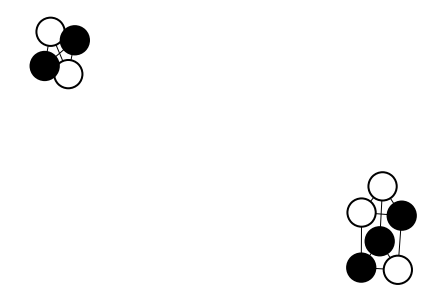

Method,Average,Variance,Best,Approx. Ratio,Cut Dist
Random,7.79,3.23,11.00,0.71,[ -8 -3 -10 -9 -9 -9 -7 -6 -7 -9 -7 -6 -4 -7 -8 -8 -3 -9 -9 -7 -8 -8 -9 -10 -6 -7 -7 -9 -9 -10 -9 -8 -8 -5 -11 -10 -8 -6 -9 -9 -8 -8 -10 -6 -9 -10 -7 -8 -7 -10 -8 -10 -10 -6 -9 -11 -9 -4 -3 -4 -6 -6 -7 -9 -8 -8 -7 -8 -10 -7 -7 -7 -10 -9 -7 -9 -7 -7 -7 -9 -4 -8 -9 -6 -9 -4 -9 -6 -6 -7 -10 -7 -8 -10 -10 -9 -8 -8 -9 -9]
Brute force,7.50,3.75,11.00,0.68,[ 0 -3 -3 ... -3 -3 0]
PAOA,9.43,1.19,11.00,0.86,[ -7 -10 -8 -10 -9 -10 -10 -10 -10 -8 -10 -7 -10 -10 -9 -8 -6 -8 -9 -11 -9 -9 -8 -10 -9 -9 -10 -8 -11 -9 -9 -10 -11 -7 -11 -10 -10 -9 -10 -8 -9 -11 -11 -9 -9 -10 -10 -10 -10 -10 -9 -11 -10 -10 -9 -11 -10 -10 -7 -9 -11 -10 -10 -9 -10 -10 -11 -11 -10 -9 -10 -10 -10 -10 -9 -8 -10 -10 -9 -10 -8 -9 -10 -6 -9 -9 -10 -11 -9 -9 -9 -8 -9 -10 -9 -9 -10 -10 -9 -11]
Reduced PAOA,10.39,0.42,11.00,0.94,[-10 -11 -11 -11 -10 -10 -11 -11 -10 -10 -11 -10 -11 -10 -10 -10 -10 -11 -10 -10 -11 -11 -10 -10 -10 -11 -10 -11 -11 -10 -10 -10 -11 -10 -10 -10 -11 -10 -10 -10 -10 -11 -11 -10 -10 -11 -10 -10 -11 -11 -11 -11 -10 -10 -11 -10 -11 -10 -10 -10 -11 -11 -11 -11 -11 -10 -10 -11 -11 -10 -10 -11 -11 -11 -11 -11 -10 -10 -10 -11 -10 -10 -7 -10 -10 -10 -11 -11 -10 -8 -10 -10 -11 -11 -10 -11 -11 -10 -10 -11]
Min PAOA (1 layer),9.84,0.29,11.00,0.89,[ -6 -9 -8 -9 -9 -9 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -9 -10 -9 -10 -10 -10 -10 -10 -9 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -11 -10 -10 -10 -10 -10 -9 -9 -10 -10 -10 -10 -10 -9 -9 -10 -10 -10 -10 -10 -10 -10]
Min PAOA (3 layers),8.43,1.47,11.00,0.77,[-10 -7 -9 -9 -9 -10 -8 -8 -8 -8 -10 -8 -9 -9 -9 -7 -6 -6 -8 -8 -10 -7 -10 -9 -9 -9 -7 -8 -10 -9 -10 -8 -7 -9 -8 -9 -8 -9 -7 -9 -10 -9 -10 -10 -9 -8 -8 -6 -9 -7 -7 -10 -8 -8 -10 -8 -7 -6 -7 -9 -7 -8 -6 -10 -7 -7 -10 -9 -8 -7 -10 -8 -9 -10 -8 -7 -8 -10 -6 -9 -8 -9 -7 -10 -8 -9 -8 -10 -9 -9 -9 -9 -8 -8 -9 -11 -7 -7 -11 -9]
QAOA (1 layer),8.46,3.17,11.00,0.77,[-11 -7 -10 -7 -9 -8 -7 -6 -8 -8 -6 -10 -7 -11 -10 -7 -9 -10 -8 -8 -8 -6 -11 -8 -9 -7 -7 -7 -7 -7 -9 -9 -10 -11 -11 -7 -8 -7 -10 -11 -6 -6 -10 -10 -11 -9 -8 -9 -9 -9 -4 -9 -7 -11 -11 -9 -9 -9 -10 -8 -11 -3 -11 -9 -7 -10 -11 -9 -7 -8 -10 -6 -6 -8 -7 -7 -11 -9 -7 -11 -8 -11 -6 -7 -9 -9 -5 -9 -6 -11 -9 -8 -10 -9 -6 -10 -7 -11 -9 -7]
QAOA (3 layers),8.36,5.65,11.00,0.76,[-10 -11 -9 -7 -9 -3 -8 -7 -6 -3 -7 -10 -11 -11 -10 -11 -11 -9 -7 -9 -7 -6 -9 -3 -11 -9 -7 -8 -9 -7 -11 -11 -9 -3 -7 -7 -8 -11 -7 -7 -7 -4 -8 -7 -7 -7 -10 -9 -11 -6 -11 -9 -9 -11 -7 -9 -7 -10 -11 -7 -10 -11 -5 -11 -11 -11 -11 -3 -4 -7 -11 -9 -11 -9 -9 -9 -7 -6 -11 -6 -11 -6 -3 -10 -3 -11 -5 -7 -8 -9 -11 -8 -11 -7 -11 -9 -11 -11 -8 -11]
QAOA (6 layers),7.71,5.19,11.00,0.70,[ -9 -8 -8 -6 -7 -6 -7 -9 -8 -7 -11 -9 -8 -10 -7 -7 -10 -8 -8 -8 -9 -7 -7 -8 -7 -6 -8 -6 -7 -7 -7 -10 -8 -4 -7 -9 -9 -10 -9 -8 -8 -8 -3 -7 -10 -11 -4 -10 -6 -6 -11 -7 -7 0 -6 -7 -11 -3 -4 -10 -6 -4 -10 -8 -6 -7 -5 -10 -7 -8 -9 -9 -8 -9 -3 -11 -6 -8 -6 0 -11 -9 -8 -10 -11 -6 -10 -7 -9 -8 -3 -11 -11 -9 -10 -10 -6 -10 -10 -9]


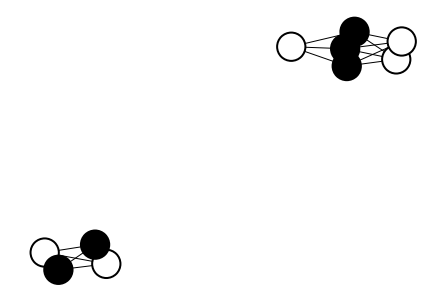

Method,Average,Variance,Best,Approx. Ratio,Cut Dist
Random,7.66,3.64,13.00,0.59,[ -8 -9 -5 -8 -10 -7 -7 -3 -7 -9 -9 -9 -8 -7 -7 -13 -9 -7 -6 -9 -4 -6 -6 -9 -8 -9 -8 -8 -8 -9 -10 -9 -8 -12 -6 -9 -9 -6 -9 -5 -7 -9 -9 -6 -8 -3 -9 -6 -13 -6 -9 -8 -8 -7 -9 -3 -9 -10 -4 -6 -8 -8 -8 -9 -7 -10 -8 -6 -10 -7 -3 -8 -7 -5 -7 -8 -9 -6 -9 -7 -7 -7 -9 -3 -8 -7 -5 -7 -7 -6 -10 -9 -8 -8 -9 -8 -9 -8 -8 -9]
Brute force,7.50,3.75,13.00,0.58,[ 0 -3 -3 ... -3 -3 0]
PAOA,9.74,5.51,13.00,0.75,[-13 -13 -13 -9 -12 -10 -13 -13 -12 -12 -9 -13 -12 -6 -9 -7 -7 -10 -13 -10 -7 -6 -12 -12 -10 -10 -10 -10 -10 -13 -13 -8 -7 -9 -6 -7 -8 -7 -12 -10 -12 -13 -13 -10 -7 -7 -10 -12 -8 -7 -9 -7 -13 -9 -10 -7 -10 -6 -6 -9 -8 -7 -10 -13 -12 -13 -13 -13 -9 -7 -6 -7 -10 -13 -7 -10 -10 -10 -6 -9 -9 -9 -9 -12 -7 -10 -10 -10 -10 -13 -13 -13 -13 -7 -7 -7 -7 -9 -10 -8]
Reduced PAOA,11.29,2.51,13.00,0.87,[-12 -13 -10 -13 -9 -10 -10 -13 -13 -13 -13 -10 -13 -10 -10 -13 -10 -13 -10 -12 -13 -13 -10 -12 -9 -10 -10 -13 -13 -10 -13 -10 -10 -10 -10 -13 -13 -13 -13 -10 -12 -13 -10 -10 -12 -9 -10 -9 -13 -13 -10 -13 -10 -13 -9 -10 -13 -13 -9 -13 -12 -10 -13 -13 -10 -10 -10 -9 -13 -13 -13 -13 -9 -12 -13 -10 -13 -10 -13 -10 -12 -13 -9 -10 -10 -9 -10 -12 -12 -10 -10 -12 -13 -12 -12 -10 -7 -13 -12 -10]
Min PAOA (1 layer),12.45,0.55,13.00,0.96,[ -9 -9 -10 -13 -12 -13 -13 -13 -13 -12 -12 -12 -13 -13 -12 -13 -13 -12 -13 -12 -13 -12 -13 -13 -13 -12 -13 -12 -13 -13 -12 -13 -12 -12 -13 -13 -12 -13 -13 -12 -13 -13 -12 -13 -12 -13 -12 -13 -12 -13 -13 -13 -13 -13 -13 -12 -12 -12 -13 -12 -13 -12 -13 -12 -13 -12 -12 -13 -12 -13 -13 -12 -12 -12 -13 -12 -12 -12 -12 -12 -13 -13 -12 -12 -13 -12 -12 -12 -12 -12 -12 -13 -13 -13 -13 -13 -13 -13 -13 -13]
Min PAOA (3 layers),8.05,1.37,10.00,0.81,[-10 -7 -10 -8 -7 -10 -6 -9 -7 -8 -8 -8 -8 -9 -6 -10 -9 -8 -7 -6 -6 -7 -8 -9 -7 -10 -9 -7 -8 -8 -8 -9 -8 -8 -9 -7 -8 -10 -8 -8 -8 -9 -9 -8 -6 -7 -9 -9 -8 -8 -10 -7 -9 -8 -7 -9 -8 -9 -9 -7 -6 -7 -9 -6 -10 -8 -7 -7 -7 -9 -7 -7 -7 -6 -9 -9 -8 -7 -10 -8 -7 -10 -9 -6 -8 -6 -8 -10 -10 -9 -7 -8 -8 -9 -7 -8 -7 -9 -9 -9]
QAOA (1 layer),7.39,4.00,13.00,0.57,[ -8 0 -6 -7 -7 -6 -13 -3 -6 -3 -8 -10 -9 -8 -7 -9 -7 -9 -8 -8 -8 -7 -8 -9 -6 -9 -9 -8 -7 -8 -8 -9 -8 -7 -10 -6 -7 -9 -3 -8 -6 -4 -9 -7 -7 -8 -7 -4 -9 -8 -9 -9 -3 -8 -8 -9 -5 -7 -9 -7 -8 -12 -9 -9 -8 -10 -8 -7 -8 -9 -8 -3 -8 -7 -10 -7 -7 -7 -8 -3 -6 -7 -9 -8 -8 -4 -3 -9 -7 -7 -8 -7 -10 -8 -8 -9 -6 -6 -7 -7]
QAOA (3 layers),7.90,2.45,10.00,0.79,[-10 -9 -10 -3 -6 -9 -8 -6 -9 -7 -9 -3 -9 -7 -9 -9 -10 -8 -7 -9 -9 -7 -9 -9 -8 -9 -6 -9 -7 -9 -7 -9 -9 -9 -9 -9 -7 -7 -3 -6 -6 -9 -7 -7 -8 -7 -6 -7 -9 -9 -9 -9 -7 -9 -8 -9 -9 -7 -9 -8 -9 -9 -9 -9 -7 -8 -7 -7 -9 -3 -9 -7 -9 -9 -7 -9 -7 -9 -7 -9 -9 -9 -6 -8 -9 -3 -9 -7 -7 -9 -9 -9 -9 -6 -8 -8 -9 -9 -9 -6]
QAOA (6 layers),7.60,3.24,10.00,0.76,[ -7 -7 -8 -9 -9 -9 -7 -3 -9 -7 -9 -10 -6 -7 -3 -9 -9 -6 -7 -5 -8 -7 -8 -7 -7 -9 -6 -8 -9 -9 -8 -6 -7 -7 -10 -8 -7 -6 -9 -8 -9 -5 -8 -9 -6 -9 -8 -9 -8 -7 -9 -6 -5 -6 -9 -9 -8 -9 -9 -9 -9 -7 -4 -8 -9 -9 -9 -8 -9 -9 -9 -7 0 -7 -9 -9 0 -9 -7 -9 -7 -7 -4 -9 -7 -8 -8 -8 -9 -8 -9 -6 -8 -8 -8 -9 -8 -9 -9 -7]


100%|████████████████████████████████████████████| 4/4 [39:54<00:00, 598.51s/it]


In [ ]:
tables_by_graph = []  # Initialize a list to store tables for each set of graphs

# Loop through each set of unique graphs
for graphs in tqdm(all_unique_graphs):
    tably = []  # Initialize a list to store results for each graph in the set

    # Loop through each graph in the current set
    for graph in graphs:
        tably.append(compare_methods(graph))  # Call the 'compare_methods' function and store the result

    # After processing all graphs in the set, add the results table to the main list
    tables_by_graph.append(tably)

In [ ]:
three_reg_graphs
number_of_rand_graphs

10

In [ ]:
import pandas as pd

trial_dx = 0

graph_data = pd.DataFrame()

for graph_dx in range(len(three_reg_graphs)):

    for trial_dx in range( len(all_unique_graphs[graph_dx])):
        what = tables_by_graph[graph_dx][trial_dx]

        namesR = [what[kdx][0] for kdx in range(len(what)-1)]
        averageR  = [what[kdx][1] for kdx in range(len(what)-1)]
        varianceR = [what[kdx][2] for kdx in range(len(what)-1)]
        bestR     = [what[kdx][3] for kdx in range(len(what)-1)]
        costR     = [what[kdx][4] for kdx in range(len(what)-1)]
        nodesR    = [three_reg_graphs[graph_dx] for kdx in range(len(what)-1)]

        data = pd.DataFrame([namesR, averageR, varianceR, bestR, costR, nodesR]) # Each list would be added as a row
        data = data.transpose() # To Transpose and make each rows as columns
        data.columns = ['Method', 'Average', 'Variance', 'Best','Cost','Nodes'] # Rename the columns

        if graph_dx == 0 and trial_dx ==0:
            graph_data = data.copy()
        else:
            graph_data = pd.concat([graph_data,data.copy()])

graph_data

,Method,Average,Variance,Best,Cost,Nodes
0,Random,2.91,1.7019,4,0.7275,4
1,Brute force,3.0,1.5,4,0.75,4
2,PAOA,3.74,0.1924,4,0.935,4
3,Reduced PAOA,4.0,0.0,4,1.0,4
4,Min PAOA (1 layer),4.0,0.0,4,1.0,4
...,...,...,...,...,...,...
3,Reduced PAOA,11.29,2.5059,13,0.868462,10
4,Min PAOA (1 layer),12.45,0.5475,13,0.957692,10
5,Min PAOA (3 layers),8.05,1.3675,10,0.805,10
6,QAOA (1 layer),7.39,3.9979,13,0.568462,10


In [ ]:
results = (graph_data.groupby(["Method", "Nodes"]).mean())
results

Average  Variance       Best      Cost
Method              Nodes                                          
Brute force         4       3.000000  1.500000   4.000000  0.750000
                    6       4.500000  2.250000   8.000000  0.571429
                    8       6.000000  3.000000  10.000000  0.608333
                    10      7.500000  3.750000  12.857143  0.586039
Min PAOA (1 layer)  4       4.000000  0.000000   4.000000  1.000000
                    6       7.000000  0.000000   7.000000  1.000000
                    8       9.041667  0.880017   9.833333  0.920384
                    10     11.132857  1.107195  12.190476  0.914617
Min PAOA (3 layers) 4       3.800000  0.160000   4.000000  0.950000
                    6       5.545000  2.836950   8.000000  0.701825
                    8       6.675000  2.713050   9.833333  0.686588
                    10      8.590952  2.521271  12.000000  0.717423
PAOA                4       3.740000  0.192400   4.000000  0.935000
                    6       6.085000  2.347150   8.000000  0.769921
                    8       8.443333  2.306233  10.000000  0.847458
                    10     10.201429  2.759100  12.476190  0.819976
QAOA (1 layer)      4       3.660000  0.224400   4.000000  0.915000
                    6       5.820000  2.730700   8.000000  0.729048
                    8       7.063333  2.258100  10.000000  0.715556
                    10      8.342857  3.136267  12.142857  0.689520
QAOA (3 layers)     4       3.980000  0.019600   4.000000  0.995000
                    6       4.885000  2.512550   8.000000  0.625317
                    8       7.265000  3.437817  10.000000  0.732194
                    10      8.605238  3.654576  11.904762  0.724018
Random              4       2.910000  1.701900   4.000000  0.727500
                    6       4.430000  1.855100   8.000000  0.562540
                    8       6.038333  2.772950   9.666667  0.635907
                    10      7.556190  3.737933  12.142857  0.624706
Reduced PAOA        4       4.000000  0.000000   4.000000  1.000000
                    6       5.940000  2.313900   8.000000  0.761429
                    8       7.671667  1.454350   9.166667  0.840111
                    10     10.144286  1.871643  12.428571  0.818795

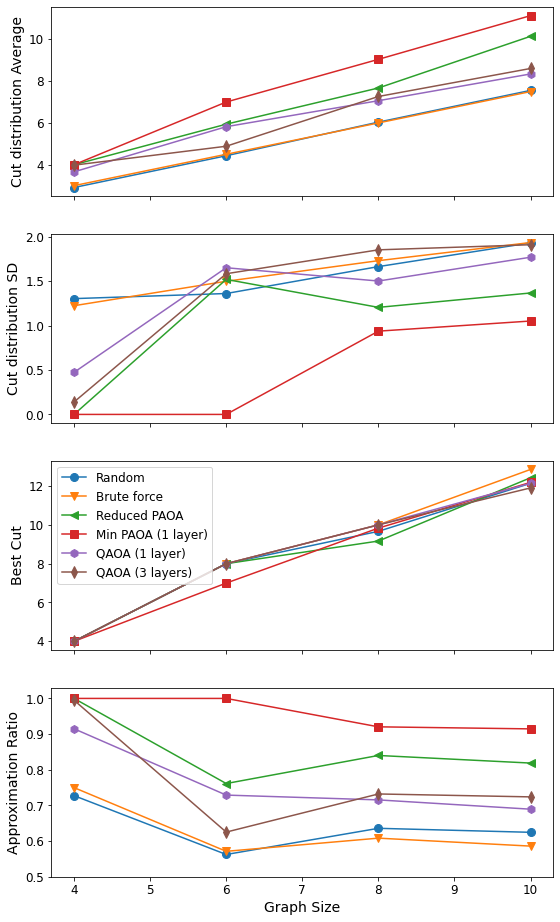

In [ ]:
fig, axs = plt.subplots(nrows=4, ncols=1,sharex=True,figsize=(9,4*4))
# Default parameters, uniform grid

marker_list = ['o','v', '<','s', 'h', 'd', 'x']

for ax, comparison in zip(axs.flat, ['Average', 'Variance', 'Best', 'Cost']):
    for mdx, method in enumerate(['Random', 'Brute force','Reduced PAOA', 'Min PAOA (1 layer)','QAOA (1 layer)','QAOA (3 layers)']):
    #['Random', 'Brute force', 'PAOA','Reduced PAOA', 'Min PAOA (1 layer)','Min PAOA (3 layers)','QAOA (1 layer)','QAOA (3 layers)']:
        new = results.loc[(method)]
        if comparison == 'Variance':
            ax.plot(new.index.values,np.sqrt(new[comparison]),'-',label=method, marker=marker_list[mdx], markersize=8)
        elif comparison == 'Best':
            ax.plot(new.index.values,new[comparison],'-',label=method, marker=marker_list[mdx], markersize=8)
        else:
            ax.plot(new.index.values,new[comparison],'-',label=method, marker=marker_list[mdx], markersize=8)
    if comparison == 'Average':
        ax.set_ylabel('Cut distribution Average')
    if comparison == 'Variance':
        ax.set_ylabel('Cut distribution SD')
    if comparison == 'Best':
        ax.set_ylabel('Best Cut')
    if comparison == 'Cost':
        ax.set_ylabel('Approximation Ratio')
        ax.set_ylim([0.5,1.03])

axs[3].set_xlabel('Graph Size')
axs[2].legend(loc='upper left') # %, bbox_to_anchor=(1, 0.5))

plt.savefig('small_graph_comparison.png', dpi=300, bbox_inches='tight')
plt.savefig('small_graph_comparison.pdf', bbox_inches='tight')

plt.show()

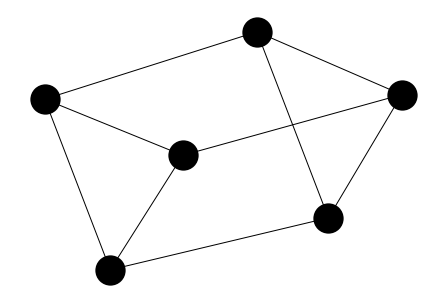

In [ ]:
GG = nx.generators.random_graphs.random_regular_graph(3, 6)

# Define visualization options for the graph nodes and edges
options = {"node_size": 800, "edgecolors": "k", "linewidths": 2.0}

# Draw the graph with black nodes and the defined options
nx.draw(GG, node_color='k', **options)

plt.show()